<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [3]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [4]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [62]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Functions

In [511]:
def scatter(x, y, df, cluster, figsize):
    sel_df = df[df['baseline_cluster'] == cluster]
    fig, ax = plt.subplots(figsize=figsize)
    sns.regplot(x=x, y=y, data=sel_df, ax=ax, y_jitter=0.5, scatter_kws={'alpha':0.3})
    plt.title("{}: {} vs {}".format(cluster, x, y))

In [512]:
def build_partial_corr(corr_df, target, covar, method='pearson', padjust='fdr_bh', pval=0.05, covar_name=None):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    
    corr_df (pd.DataFrame): correlation frame, assuming each row is an observation
    target (str): targe column, can be a string prefix or suffix
    covar (list): a list of covariates to control for
    covar_name (str): optional name for covariates
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=covar, method=method)
    _, p_adj = pg.multicomp(partial_corr['p-unc'].values, alpha=pval, method=padjust)
    partial_corr['p-corr'] = p_adj
    
    partial_corr = partial_corr.loc[(partial_corr['p-corr'] < pval) & (~partial_corr['X'].str.contains(target)) & (partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-corr']
    if covar_name is not None:
        partial_corr['covar'] = covar_name
    
    
    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]
    
    # drop the controlling covars for the raw pairwise correlation
    pairwise_corr = pg.pairwise_corr(data=corr_df.drop(covar, axis='columns'), method=method, padjust=padjust)
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-corr']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl', 'n']], on=['X', 'Y'], how='left').sort_values('p_ctl')
    return partial_corr.style.set_caption(method)

# Load Data

In [7]:
baseline_redcap_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

baseline_redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

baseline_redcap_df['pid'] = baseline_redcap_df['study_id'].map(baseline_redcap_dict)

def pad_pid(row):
    if len(row['pid']) < 8:
        return ('0' * (8-len(row['pid']))) + row['pid']
    else:
        return row['pid']

baseline_redcap_df['pid'] = baseline_redcap_df['pid'].astype(str)
baseline_redcap_df['pid'] = baseline_redcap_df.apply(pad_pid, axis=1)

age_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['age']))
# 1 is male, 0 is female
gender_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['demo_gender']))

In [149]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

# Survey Descriptives

In [11]:
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

phq_df = phq_df[phq_df['pid'].isin(cluster_df['pid'])]
phq_df['baseline_cluster'] = phq_df['pid'].map(cluster_dict)

In [12]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)


## PHQ 

### Investigating high baseline PHQs

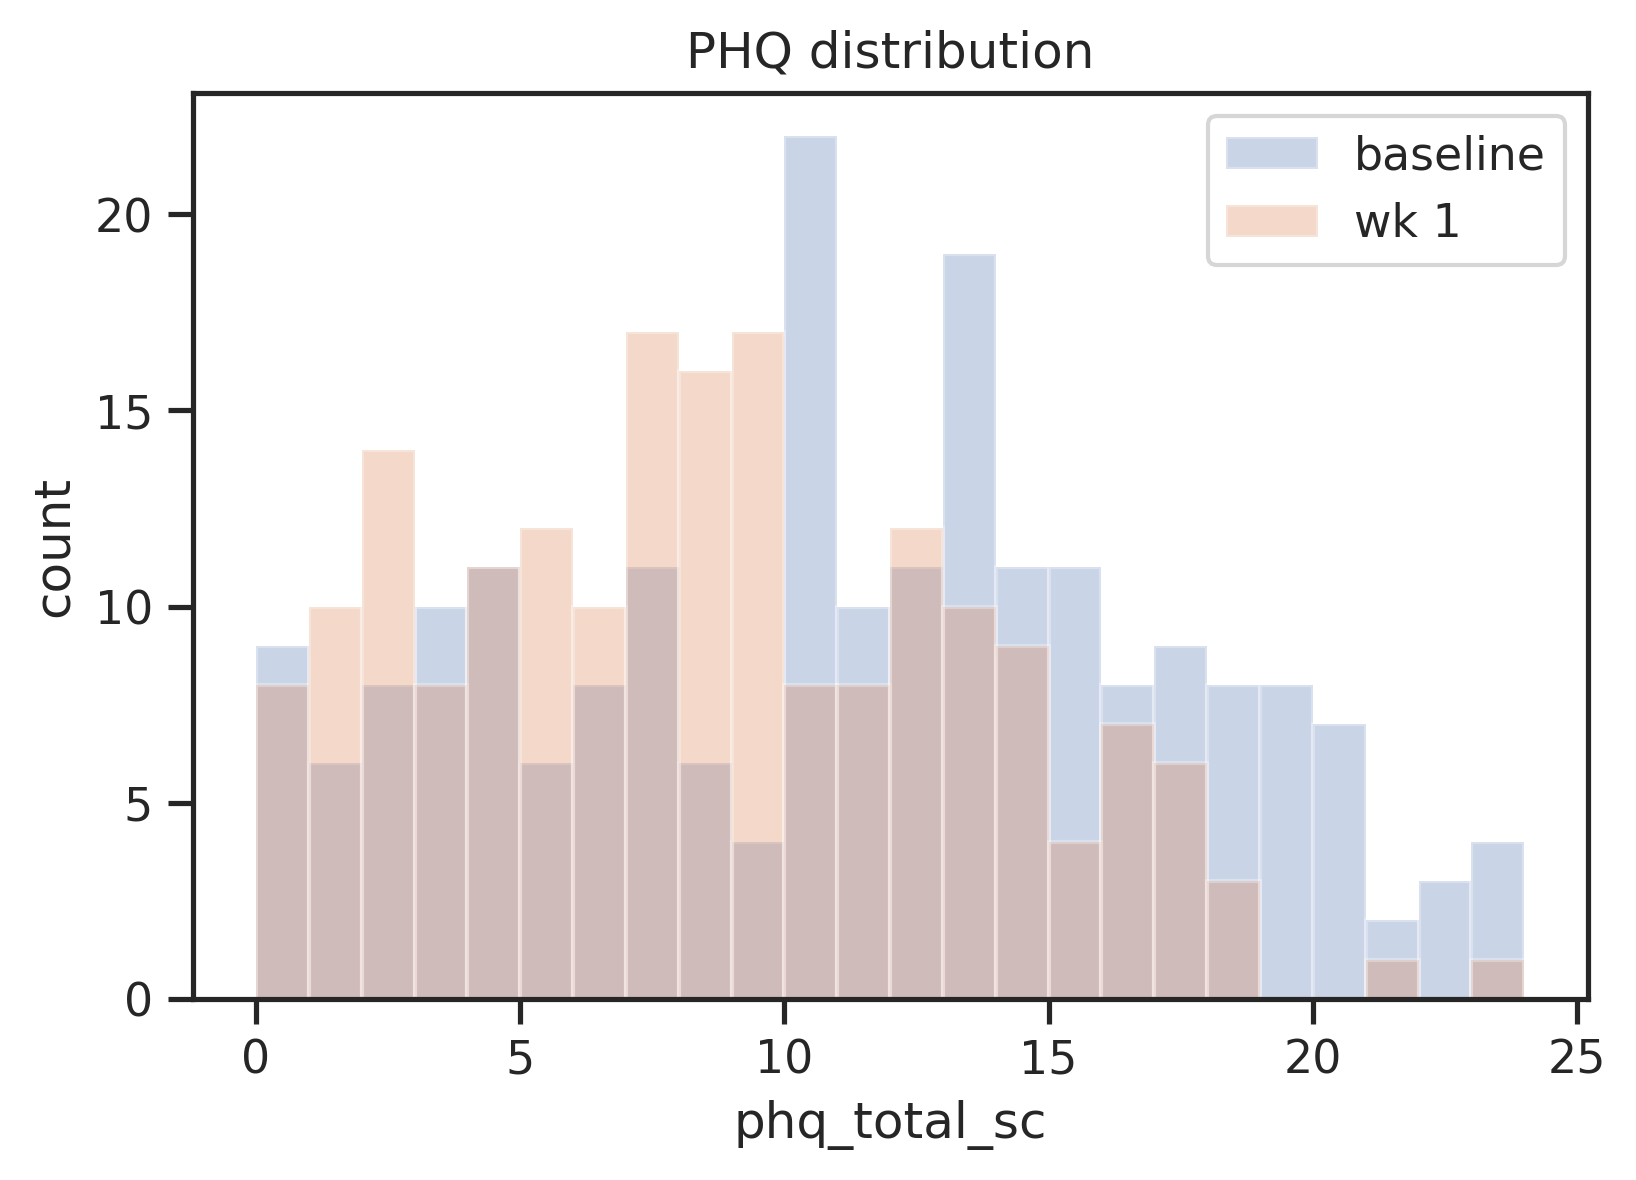

In [88]:
fig, ax = plt.subplots()
baseline_phq = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']
sns.distplot(baseline_phq['phq_total_sc'], bins=24, label="baseline", kde=False, ax=ax, 
             hist_kws = {'alpha': 0.3})

wk1_phq = phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']
wk1_phq = wk1_phq.drop_duplicates(subset=['pid'], keep='first')
sns.distplot(wk1_phq['phq_total_sc'], bins=24,  label="wk 1", kde=False, ax=ax,
             hist_kws = {'alpha': 0.3})
plt.title("PHQ distribution")
plt.ylabel("count")
plt.legend()
plt.show()

In [89]:
# take the baseline average of the missing pids week by week
baseline_pids = baseline_phq['pid'].unique()

missing_df = pd.DataFrame()
for event in list(event_dict.keys())[1:]:
    wk_df = phq_df[phq_df['redcap_event_name'] == event]
    wk_df = wk_df.drop_duplicates(subset=['pid'])
    wk_pids = wk_df['pid'].unique()
    missing_pids = [x for x in baseline_pids if x not in wk_pids]
    #print(missing_pids)
    desc_df = pd.DataFrame({event[:-6] + "_missing": baseline_phq[baseline_phq['pid'].isin(missing_pids)]['phq_total_sc'].describe()})
    missing_df = pd.concat([missing_df, desc_df], axis=1)
    #display(missing_df)

In [90]:
baseline_descr = pd.DataFrame({'baseline_all' : baseline_phq['phq_total_sc'].describe()})

pd.concat([baseline_descr, missing_df], axis=1)

baseline_all  week_1_missing  week_4_missing  week_7_missing  \
count    212.000000       20.000000       55.000000       34.000000   
mean      10.768868       11.700000       11.363636       12.088235   
std        6.064298        5.831854        6.648207        6.770559   
min        0.000000        3.000000        0.000000        0.000000   
25%        6.000000        8.250000        6.000000        9.250000   
50%       11.000000       11.500000       11.000000       12.000000   
75%       15.000000       16.000000       17.000000       17.750000   
max       24.000000       24.000000       23.000000       24.000000   

       week_10_missing  week_13_missing  week_16_missing  
count        27.000000        31.000000        36.000000  
mean         12.814815        11.645161        12.138889  
std           6.928409         7.007369         7.115989  
min           0.000000         0.000000         0.000000  
25%          10.000000         7.000000         8.000000  
50%          13.000000        12.000000        12.500000  
75%          18.000000        16.500000        17.250000  
max          24.000000        24.000000        24.000000

# SPIN

In [212]:
state_df = pd.read_pickle("ls_data/state_all.df")
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

state_df = state_df[state_df['pid'].isin(cluster_df['pid'])]
state_df['baseline_cluster'] = state_df['pid'].map(cluster_dict)

In [213]:
spin_cols = state_df.columns[state_df.columns.str.contains('spin')][1:]
state_df[spin_cols].describe()

spin_01      spin_02      spin_03      spin_04      spin_05  \
count  1192.000000  1192.000000  1192.000000  1192.000000  1192.000000   
mean      1.867450     1.988255     1.510906     1.565436     1.853188   
std      28.927528    28.930413     1.320210     1.279856     1.366908   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     1.000000   
50%       1.000000     1.000000     1.000000     1.000000     2.000000   
75%       2.000000     2.000000     3.000000     3.000000     3.000000   
max     999.000000   999.000000     4.000000     4.000000     4.000000   

           spin_06      spin_07      spin_08      spin_09      spin_10  \
count  1192.000000  1192.000000  1192.000000  1192.000000  1192.000000   
mean      2.462248     1.159396     3.362416     2.758389     1.194631   
std      28.918170     1.304811    40.859299    28.917271     1.224863   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     1.000000     0.000000   
50%       1.000000     1.000000     1.000000     2.000000     1.000000   
75%       3.000000     2.000000     3.000000     3.000000     2.000000   
max     999.000000     4.000000   999.000000   999.000000     4.000000   

           spin_11      spin_12      spin_13      spin_14      spin_15  \
count  1192.000000  1192.000000  1192.000000  1192.000000  1192.000000   
mean      2.714765     1.585570     0.733221     1.495805     1.587248   
std      28.921838     1.353936     1.121189     1.318976     1.388125   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       2.000000     1.000000     0.000000     1.000000     1.000000   
75%       3.000000     3.000000     1.000000     2.000000     3.000000   
max     999.000000     4.000000     4.000000     4.000000     4.000000   

           spin_16      spin_17  
count  1192.000000  1192.000000  
mean      0.921980     1.059564  
std       1.150966     1.292220  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     1.000000  
75%       2.000000     2.000000  
max       4.000000     4.000000

In [214]:
# impute 999s with median, only a few
display(state_df[state_df[spin_cols] > 4][spin_cols].describe())
state_df = state_df.replace(to_replace=999, value=1)

spin_01  spin_02  spin_03  spin_04  spin_05  spin_06  spin_07  spin_08  \
count      1.0      1.0      0.0      0.0      0.0      1.0      0.0      2.0   
mean     999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   
std        NaN      NaN      NaN      NaN      NaN      NaN      NaN      0.0   
min      999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   
25%      999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   
50%      999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   
75%      999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   
max      999.0    999.0      NaN      NaN      NaN    999.0      NaN    999.0   

       spin_09  spin_10  spin_11  spin_12  spin_13  spin_14  spin_15  spin_16  \
count      1.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
mean     999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   
std        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
min      999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   
25%      999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   
50%      999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   
75%      999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   
max      999.0      NaN    999.0      NaN      NaN      NaN      NaN      NaN   

       spin_17  
count      0.0  
mean       NaN  
std        NaN  
min        NaN  
25%        NaN  
50%        NaN  
75%        NaN  
max        NaN

In [215]:
state_df['spin_total'] = state_df[spin_cols].sum(axis=1, skipna=False)
state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

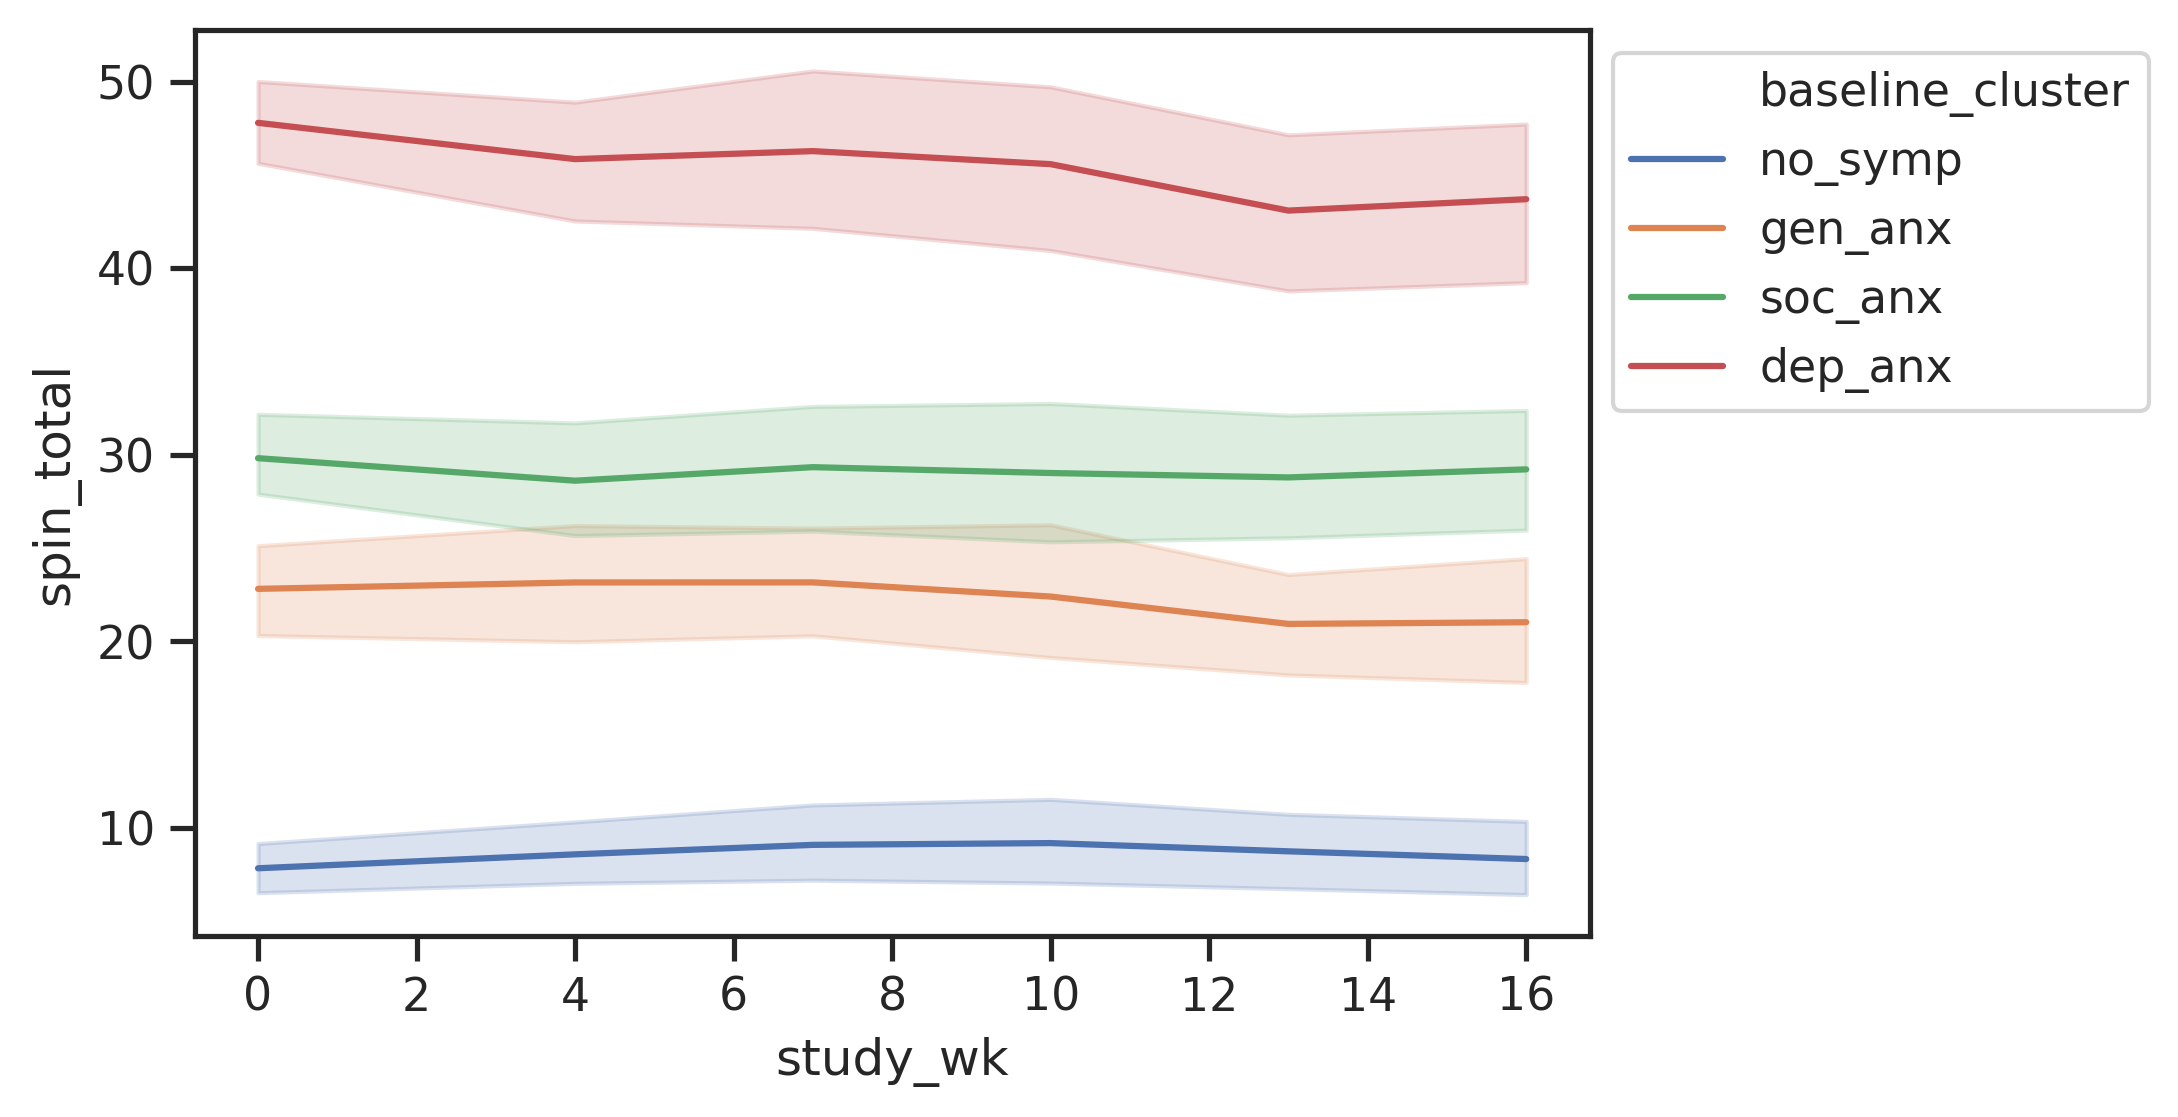

In [216]:
state_df['spin_start'] = pd.to_datetime(state_df['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_total", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=state_df)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

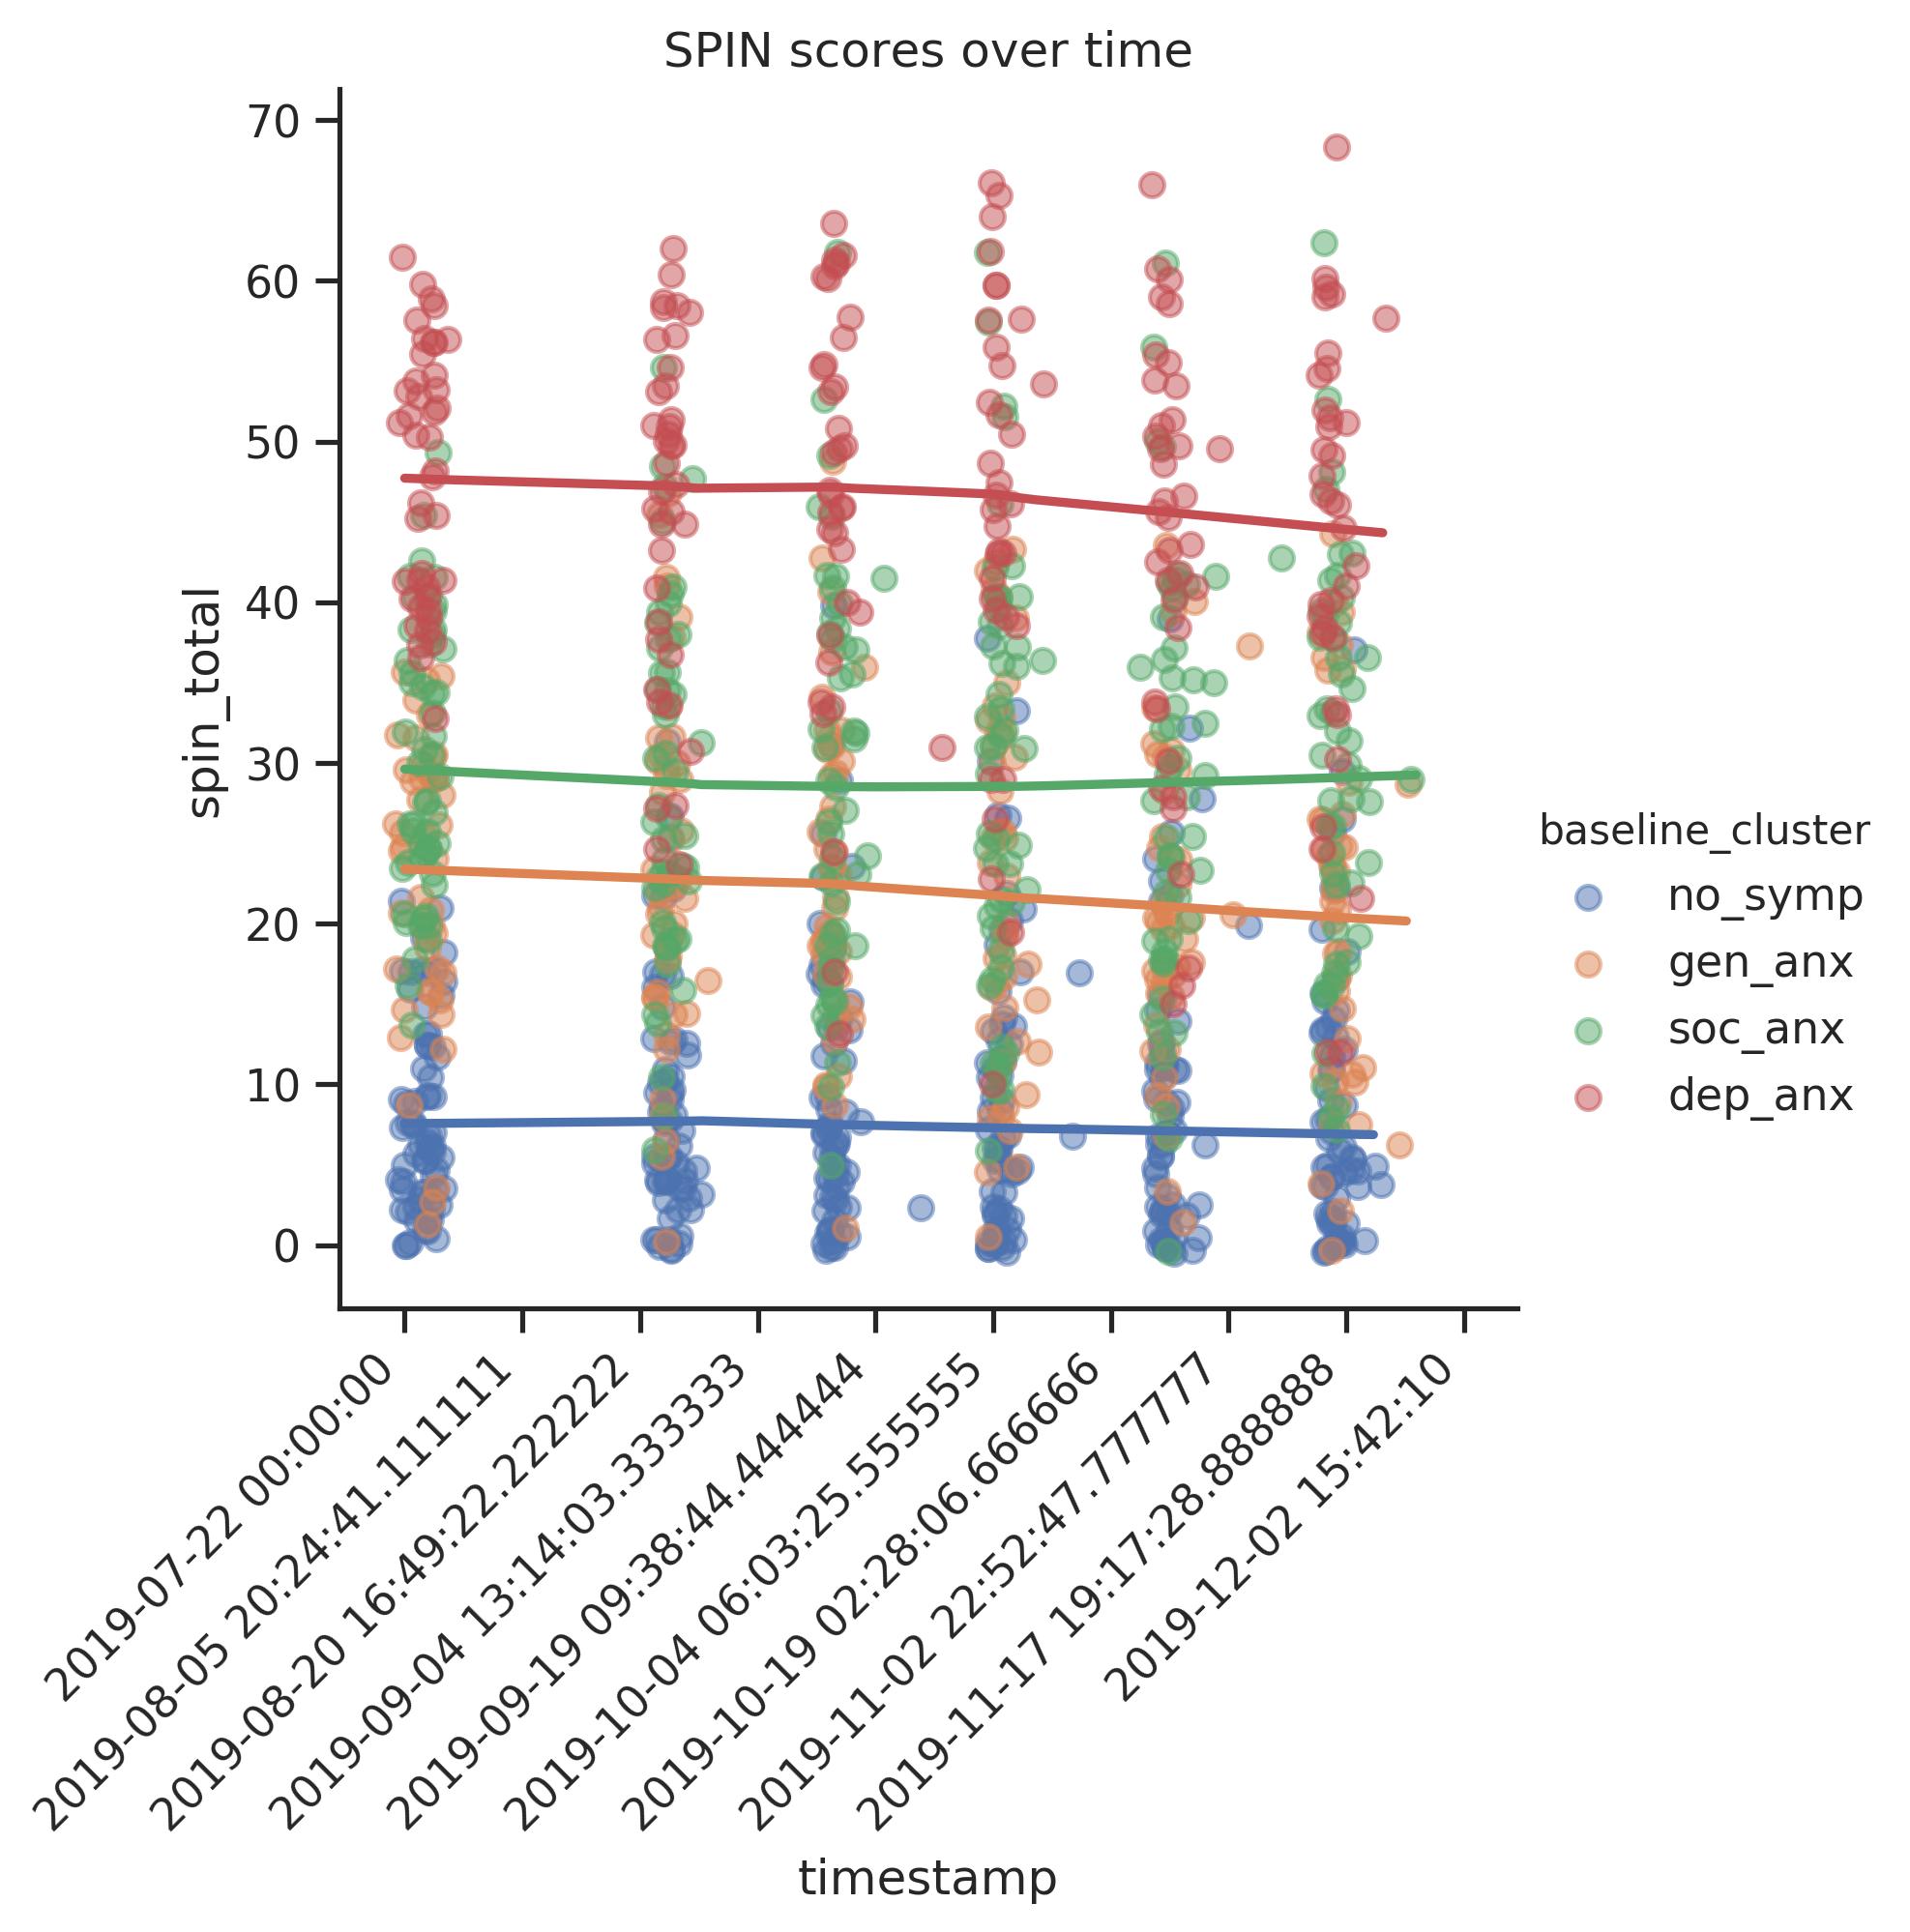

In [217]:
state_df['timestamp'] = (state_df['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='spin_total', 
           data=state_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(state_df['timestamp'].min(), state_df['timestamp'].max(), 10)
idx = pd.date_range(state_df['spin_start'].min(), state_df['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
plt.title("SPIN scores over time")
plt.show()

# GAD

In [218]:
gad_cols = state_df.columns[state_df.columns.str.contains('gad')][1:]
gad_cols = gad_cols.drop('gad08')
state_df[gad_cols].describe()

state_df = state_df[state_df['pid'].isin(cluster_df['pid'])]
state_df['baseline_cluster'] = state_df['pid'].map(cluster_dict)

In [219]:
# impute 99s with median, only a few
display(state_df[state_df[gad_cols] > 4][gad_cols].describe())
state_df = state_df.replace(to_replace=99, value=1)

gad01  gad02  gad03  gad04  gad05  gad06  gad07
count    0.0    0.0    0.0    0.0    1.0    1.0    0.0
mean     NaN    NaN    NaN    NaN   99.0   99.0    NaN
std      NaN    NaN    NaN    NaN    NaN    NaN    NaN
min      NaN    NaN    NaN    NaN   99.0   99.0    NaN
25%      NaN    NaN    NaN    NaN   99.0   99.0    NaN
50%      NaN    NaN    NaN    NaN   99.0   99.0    NaN
75%      NaN    NaN    NaN    NaN   99.0   99.0    NaN
max      NaN    NaN    NaN    NaN   99.0   99.0    NaN

In [220]:
state_df['gad_total'] = state_df[gad_cols].sum(axis=1, skipna=False)
state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

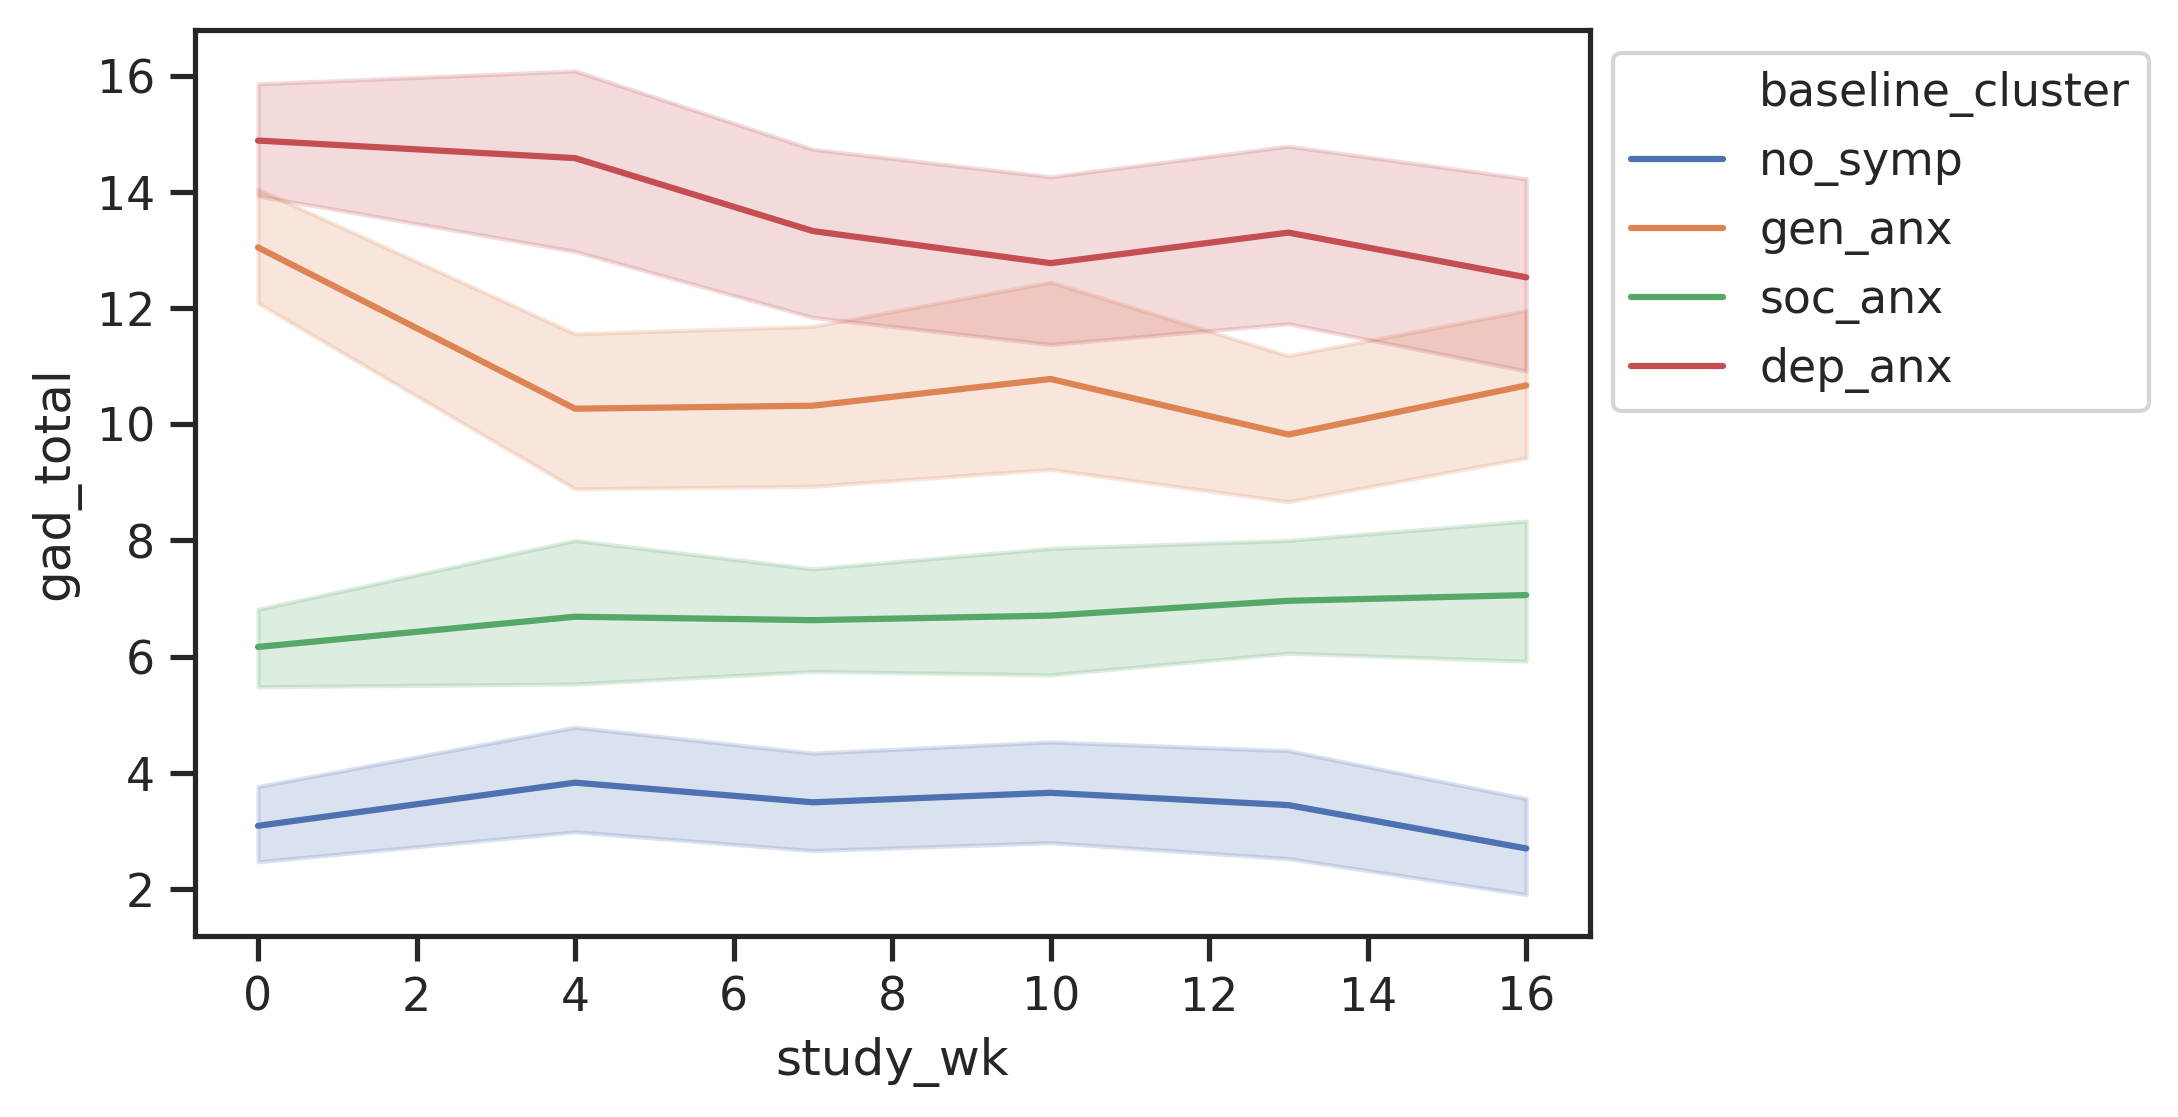

In [221]:
state_df['gad_start'] = pd.to_datetime(state_df['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_total", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=state_df)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

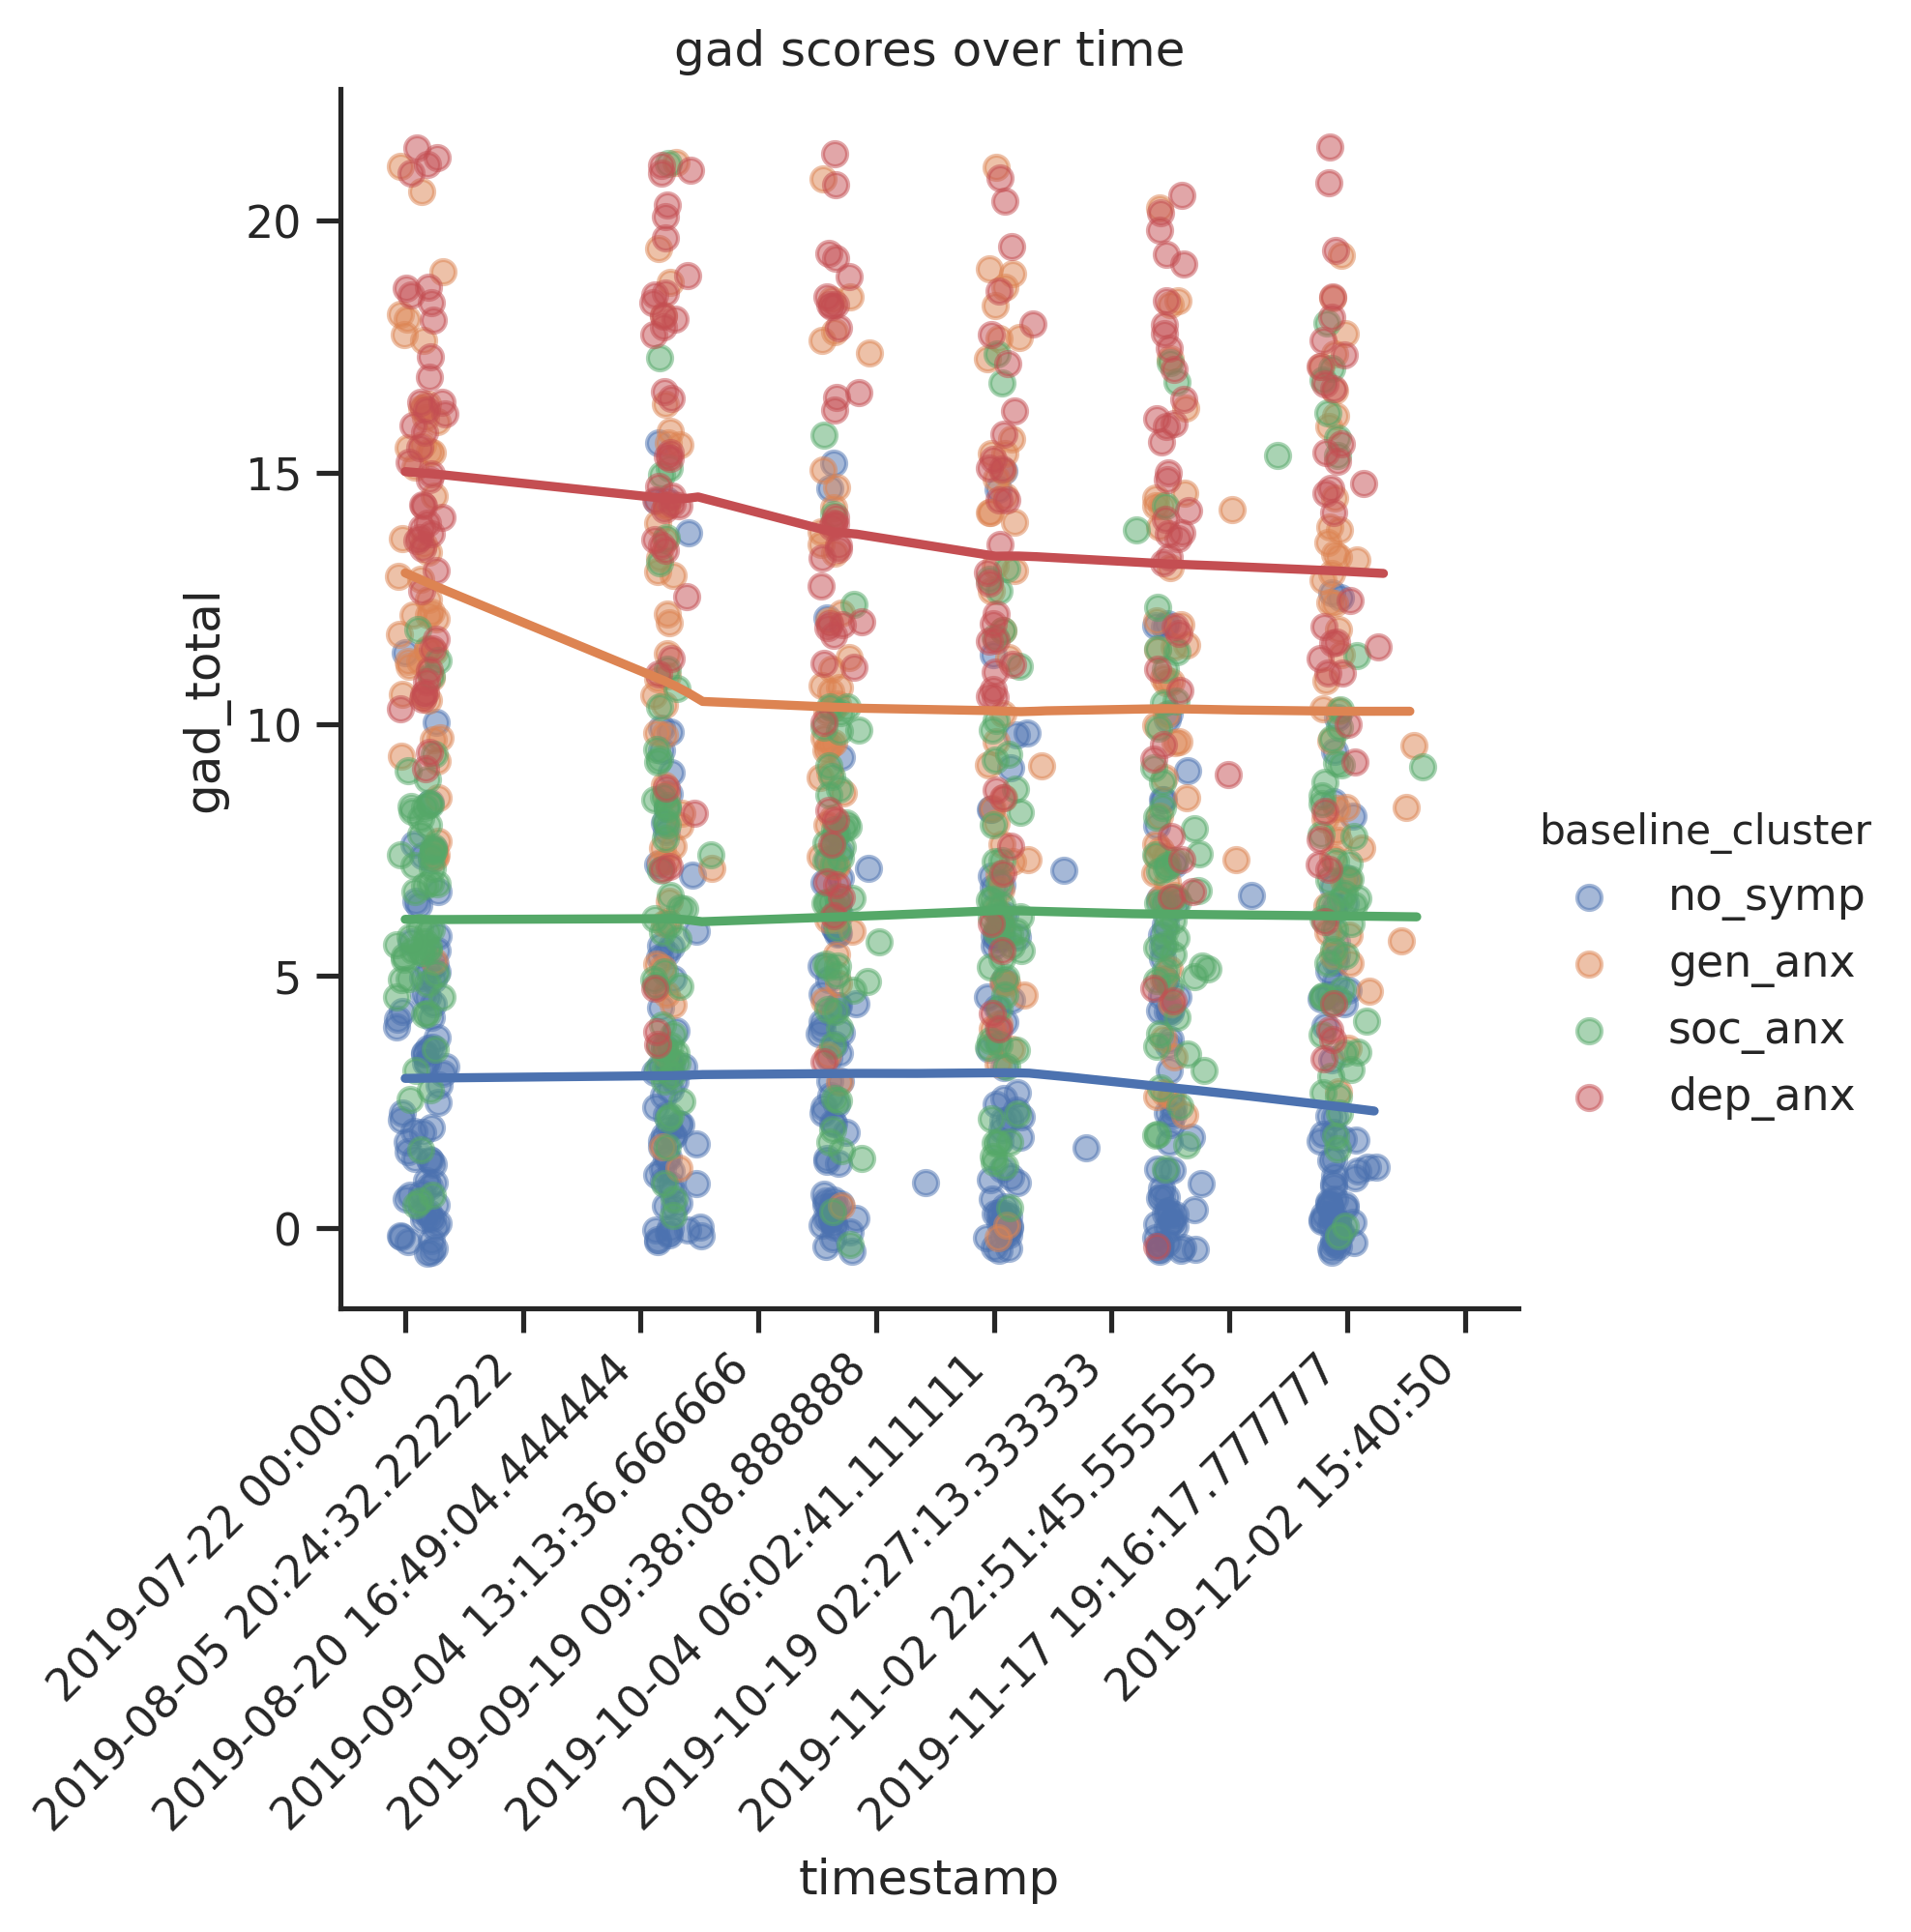

In [222]:
state_df['timestamp'] = (state_df['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='gad_total', 
           data=state_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(state_df['timestamp'].min(), state_df['timestamp'].max(), 10)
idx = pd.date_range(state_df['gad_start'].min(), state_df['gad_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
plt.title("gad scores over time")
plt.show()

# Shift DataFrame Construction

In [235]:
def build_fill_shift_df(shift_df, target, wks = [1,4,7,10,13,16], impute_mean=False):
    """Constructs a full shifted DataFrame with missing survey idxs filled with mean or nans.
    
    Args:
        shift_df (pd.df): the shifted DataFrame
        target (str): the target survey column (eg phq_total_sc)
        impute_mean (bool): whether or not to fill missing surveys with the individual's mean PHQ score
    Returns:
        fill_shift_df (pd.df): the filled DataFrame, with all events represented for each individual
    """
    
    fill_shift_df = pd.DataFrame()

    for pid, group in shift_df.groupby('pid'):
        group = group.reset_index(drop=True)
        group_mean = group[target].mean()
        for idx, wk in enumerate(wks):
            cur_event = "week_{}_arm_1".format(wk)

            sel = group[group['redcap_event_name'] == cur_event]
            if sel.shape[0] > 0:
                sel_idx = sel.index[0]
                fill_shift_df = fill_shift_df.append(group.iloc[sel_idx, :])
            # else we have to fill an empty row in the DataFrame    
            else:
                empty = pd.DataFrame(index=[0], columns=group.columns)
                empty['redcap_event_name'] = cur_event
                
                if impute_mean:
                    fill_val = group_mean
                else:
                    fill_val = np.nan
                    
                empty[target] = fill_val
                empty['pid'] = pid
                fill_shift_df = fill_shift_df.append(empty)
                
    fill_shift_df['survey_idx'] = fill_shift_df.groupby('pid').cumcount()+1
    
    return fill_shift_df

## SPIN

In [224]:
spin_shift_df = state_df.copy()

In [225]:
# map cluster assignments
spin_shift_df['cluster'] = spin_shift_df['pid'].map(cluster_dict)
spin_shift_df = spin_shift_df.sort_values(by=['pid', 'spin_start'])

spin_shift_df = spin_shift_df[spin_shift_df['redcap_event_name'] != 'week_0_arm_1']
spin_shift_df['spin_start'] = pd.to_datetime(spin_shift_df['spin_start'])
spin_shift_df['spin_start_shift'] = spin_shift_df.groupby('pid')['spin_start'].shift(1)
spin_shift_df['diff'] = spin_shift_df['spin_start'] - spin_shift_df['spin_start_shift']

In [226]:
spin_shift_df[['pid', 'redcap_event_name', 'spin_start', 'spin_start_shift', 'diff']].head()

pid redcap_event_name          spin_start    spin_start_shift  \
405  00746649      week_4_arm_1 2019-08-23 19:07:47                 NaT   
406  00746649      week_7_arm_1 2019-09-14 15:42:28 2019-08-23 19:07:47   
407  00746649     week_10_arm_1 2019-10-04 16:28:17 2019-09-14 15:42:28   
78   00746649     week_13_arm_1 2019-10-25 22:41:12 2019-10-04 16:28:17   
79   00746649     week_16_arm_1 2019-11-15 10:41:55 2019-10-25 22:41:12   

                diff  
405              NaT  
406 21 days 20:34:41  
407 20 days 00:45:49  
78  21 days 06:12:55  
79  20 days 12:00:43

In [227]:
spin_shift_df[spin_shift_df['diff'] < pd.to_timedelta(14, unit='d')]

pid redcap_event_name           gad_start  gad01  gad02  gad03  \
859   18740846     week_10_arm_1 2019-10-04 12:47:45    1.0    0.0    0.0   
111   19410615     week_16_arm_1 2019-11-16 23:08:20    3.0    3.0    3.0   
1107  24936642     week_10_arm_1 2019-10-04 18:12:04    0.0    0.0    0.0   
355   45433155     week_16_arm_1 2019-11-17 05:35:18    2.0    1.0    0.0   
389   50931782     week_16_arm_1 2019-11-15 20:41:30    3.0    2.0    2.0   
518   59654069     week_13_arm_1 2019-10-25 10:31:11    0.0    0.0    1.0   
2774  62463869      week_7_arm_1 2019-09-13 11:51:18    2.0    1.0    1.0   
2359  73326278     week_10_arm_1 2019-10-28 16:05:30    2.0    2.0    2.0   
196   74575289     week_13_arm_1 2019-10-26 12:47:04    1.0    1.0    1.0   
2783  84877086     week_10_arm_1 2019-10-04 16:44:49    1.0    0.0    1.0   

      gad04  gad05  gad06  gad07  ...  spin_16 spin_17  baseline_cluster  \
859     1.0    1.0    1.0    0.0  ...      0.0     0.0           no_symp   
111     3.0    1.0    3.0    3.0  ...      3.0     0.0           gen_anx   
1107    0.0    0.0    0.0    0.0  ...      0.0     0.0           no_symp   
355     2.0    0.0    0.0    0.0  ...      1.0     0.0           no_symp   
389     2.0    2.0    3.0    2.0  ...      3.0     1.0           soc_anx   
518     0.0    0.0    1.0    0.0  ...      0.0     1.0           no_symp   
2774    2.0    2.0    1.0    0.0  ...      0.0     3.0           gen_anx   
2359    2.0    2.0    2.0    2.0  ...      1.0     2.0           dep_anx   
196     1.0    0.0    1.0    0.0  ...      0.0     0.0           no_symp   
2783    2.0    0.0    3.0    0.0  ...      1.0     3.0           soc_anx   

      spin_total study_wk     timestamp  gad_total  cluster  \
859          0.0       10  1.570193e+09        4.0  no_symp   
111         40.0       16  1.573946e+09       19.0  gen_anx   
1107         1.0       10  1.570213e+09        0.0  no_symp   
355         18.0       16  1.573969e+09        5.0  no_symp   
389         39.0       16  1.573850e+09       16.0  soc_anx   
518         11.0       13  1.571999e+09        2.0  no_symp   
2774        24.0        7  1.568375e+09        9.0  gen_anx   
2359        38.0       10  1.572279e+09       14.0  dep_anx   
196          6.0       13  1.572094e+09        5.0  no_symp   
2783        36.0       10  1.570207e+09        7.0  soc_anx   

        spin_start_shift             diff  
859  2019-10-04 12:39:34  0 days 00:12:18  
111  2019-11-04 12:21:39 12 days 11:01:26  
1107 2019-09-24 14:32:37 10 days 03:46:22  
355  2019-11-05 09:23:53 11 days 20:13:37  
389  2019-11-08 20:50:22  6 days 23:54:24  
518  2019-10-14 01:50:16 11 days 08:42:56  
2774 2019-09-13 11:45:31  0 days 00:11:42  
2359 2019-10-27 12:33:11  1 days 03:34:33  
196  2019-10-15 09:11:34 11 days 03:40:41  
2783 2019-10-04 16:37:34  5 days 22:01:32  

[10 rows x 76 columns]

### observations to drop:

- 18740846, wk7
- 62463869, wk4
- 73326278, wk10

In [230]:
print(spin_shift_df.shape)
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '18740846') & (spin_shift_df['redcap_event_name'] == 'week_7_arm_1'))]
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '62463869') & (spin_shift_df['redcap_event_name'] == 'week_4_arm_1'))]
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '73326278') & (spin_shift_df['redcap_event_name'] == 'week_10_arm_1'))]
print(spin_shift_df.shape)

(983, 76)
(980, 76)


In [236]:
%%time

spin_fill_df = build_fill_shift_df(spin_shift_df, 'spin_total', wks=[4,7,10,13,16])

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.3 s


In [246]:
spin_fill_df.to_pickle("ls_data/state_cluster_shift.df")

# Load Data

**note**: sourced originally from lifesense_cluster_change_over_time, under "Correlates Over Time" heading

In [255]:
# build cal_daily
all_cal = pd.read_pickle("wave1_features/cal_hr.df")
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)

display(cal_daily.head())

pid       date  tot_call_count  tot_call_duration  is_wkday
0  00746649 2019-07-23              12               1814       1.0
1  00746649 2019-07-24              15               4572       1.0
2  00746649 2019-07-25              20               2363       1.0
3  00746649 2019-07-26              15               8063       1.0
4  00746649 2019-07-27              10               1748       0.0

In [256]:
# build sms_daily
all_sms = pd.read_pickle("wave1_features/sms_hr.df")
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily["is_wkday"] = (pd.to_datetime(sms_daily['date']).dt.dayofweek < 5).astype(float)

display(sms_daily.head())

pid       date  tot_sms_count  tot_sms_length  in_sms_count  \
0  00746649 2019-07-23             22            1738          22.0   
1  00746649 2019-07-24             24            1464          24.0   
2  00746649 2019-07-25             14             936          14.0   
3  00746649 2019-07-26             23            2135          23.0   
4  00746649 2019-07-27             21             990          21.0   

   in_sms_length  out_sms_count  out_sms_length  is_wkday  
0         1738.0            0.0             0.0       1.0  
1         1464.0            0.0             0.0       1.0  
2          936.0            0.0             0.0       1.0  
3         2135.0            0.0             0.0       1.0  
4          990.0            0.0             0.0       0.0

In [257]:
# build fga_daily
all_fga = pd.read_pickle("wave1_features/fga_hr.df")
all_fga['all_browser'] = all_fga['browser'] + all_fga['chrome']
all_fga['date'] = all_fga['hr'].dt.floor('d')
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)

display(fga_daily.head())

pid       date  katana   orca  messaging  launcher  chrome   email  \
0  00746649 2019-07-23     0.0    0.0     3380.0    1753.0  1490.0  1113.0   
1  00746649 2019-07-24     0.0  105.0     1888.0    2831.0   965.0   713.0   
2  00746649 2019-07-25     0.0  135.0     5835.0    1826.0    98.0   770.0   
3  00746649 2019-07-26     0.0  301.0     5288.0    1986.0   195.0  1362.0   
4  00746649 2019-07-27     0.0    0.0     3166.0     686.0     0.0   110.0   

   instagram  youtube    maps  snapchat  browser  all_browser  is_wkday  
0      211.0   1080.0   240.0       0.0    165.0       1655.0       1.0  
1     1203.0      0.0     0.0       0.0    931.0       1896.0       1.0  
2      368.0      0.0    73.0       0.0    509.0        607.0       1.0  
3      842.0      0.0  1410.0       0.0   1065.0       1260.0       1.0  
4     3310.0      0.0   847.0       0.0      0.0          0.0       0.0

In [422]:
%%time
# build sloc_daily
all_sloc = pd.read_pickle("wave1_features/sloc_hr.df")
all_sloc['date'] = all_sloc['hr'].dt.floor('d')

CPU times: user 353 ms, sys: 54.4 s, total: 54.8 s
Wall time: 56.5 s


In [423]:
%%time

sloc_cols = list(all_sloc.columns[all_sloc.columns.str.endswith('dur')])
all_sloc[sloc_cols] = all_sloc[sloc_cols].clip(0, 100000000)
sloc_daily = all_sloc.groupby(['pid', 'date']).sum()
sloc_daily = sloc_daily.reset_index()
sloc_daily["is_wkday"] = (pd.to_datetime(sloc_daily['date']).dt.dayofweek < 5).astype(float)

display(sloc_daily.head())

pid       date  food_dur  home_dur  work_dur  exercise_dur  \
0  00746649 2019-07-23       0.0   21869.0       0.0           0.0   
1  00746649 2019-07-24       0.0   54305.0    7379.0           0.0   
2  00746649 2019-07-25       0.0   48121.0       0.0           0.0   
3  00746649 2019-07-26       0.0   49696.0       0.0        3824.0   
4  00746649 2019-07-27       0.0   28339.0       0.0         536.0   

   anothers_home_dur  religion_dur  travel_dur  shopping_dur  ...  \
0                0.0           0.0         0.0           0.0  ...   
1                0.0           0.0         0.0           0.0  ...   
2                0.0         753.0         0.0           0.0  ...   
3             3726.0           0.0         0.0        3790.0  ...   
4                0.0           0.0         0.0           0.0  ...   

   n/a_religion  n/a_travel  n/a_shopping  n/a_errand  n/a_health  \
0             0           0             0           1           2   
1             0           0             0           0           1   
2             1           0             0           0           1   
3             0           0             2           0           1   
4             0           0             0           0           0   

   n/a_education  n/a_entertainment  n/a_other  tot_tansitions  is_wkday  
0              0                  0          0               9       1.0  
1              0                  0          1              13       1.0  
2              0                  1          1              10       1.0  
3              0                  1          1              17       1.0  
4              0                  0          0               6       0.0  

[5 rows x 200 columns]

CPU times: user 5.44 s, sys: 17.9 s, total: 23.3 s
Wall time: 20.3 s


In [424]:
drop_cols = sloc_daily.columns[sloc_daily.columns.str.contains('n/a')]
sloc_daily = sloc_daily.drop(drop_cols, axis='columns')

In [544]:
# load fus and circ data
fus_daily = pd.read_pickle("wave1_features/fus_gad_start_14_-1.df")
circ_dict = pickle.load(open("wave1_features/circ_gad_start_14_-1.dict", "rb"))

In [545]:
# correction for Series values in list, though it doesn't seem to have affected anything??
new_dict = {}
for col, vals in circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    new_dict[col] = new_vals
circ_dict = new_dict

## Build Sequence DF

In [546]:
def build_col_dict(cols, feat_df, seq_df, target, transform_log=False, pre_days=3, post_days=3):
    """Builds a (col, [vals]) dictionary for the given features.
    
    """
    col_dict = {}

    for col in cols:
        col_dict[col] = []

    for idx, row in seq_df.iterrows():
        if pd.isna(row[target]):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(pre_days, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(post_days, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

In [547]:
# columns
sms_cols = ['tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length', 'out_sms_count', 'out_sms_length']
cal_cols = ['tot_call_count', 'tot_call_duration']
fga_cols = ['katana', 'orca', 'messaging', 'email', 'instagram', 'youtube', 'maps', 'snapchat', 'browser', 'chrome']

circ_cols = ['circ_movt_tot', 'circ_movt_wkday', 'circ_movt_wkend']
fus_cols = list(fus_daily.columns[(fus_daily.columns.str.endswith('total') | fus_daily.columns.str.endswith('wkend') | fus_daily.columns.str.endswith('wkday')) & ~fus_daily.columns.str.startswith('date')])
sloc_cols = list(sloc_daily.columns.drop(['pid', 'date', 'is_wkday']))

#sloc_cols = list(sloc_daily.columns[sloc_daily.columns.str.endswith('dur')])

## Digital Markers to State

In [548]:
spin_fill_df['date'] = spin_fill_df['spin_start'].dt.normalize()

### Calculate shifted change

In [549]:
spin_fill_df['spin_total_shift'] = spin_fill_df.groupby('pid')['spin_total'].shift(1)
spin_fill_df['spin_diff'] = spin_fill_df['spin_total'] - spin_fill_df['spin_total_shift']

In [550]:
spin_fill_df['gad_total_shift'] = spin_fill_df.groupby('pid')['gad_total'].shift(1)
spin_fill_df['gad_diff'] = spin_fill_df['gad_total'] - spin_fill_df['gad_total_shift']

In [551]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
cal_dict = build_col_dict(cal_cols, cal_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
fga_dict = build_col_dict(fga_cols, fga_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)
sloc_dict = build_col_dict(sloc_cols, sloc_daily, spin_fill_df, 'spin_start', pre_days=14, post_days=-1)

CPU times: user 49.3 s, sys: 89.5 ms, total: 49.4 s
Wall time: 49.5 s


# Feature Aggregation

In [552]:
def ortho_rotation(components, method='varimax', tol=1e-6, max_iter=100):
    """Return rotated components.
    
    https://github.com/scikit-learn/scikit-learn/pull/11064/files
    """
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = np.diag((comp_rot ** 2).sum(axis=0)) / nrow
            tmp = np.dot(comp_rot, tmp)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(
            np.dot(components.T, comp_rot ** 3 - tmp))
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return np.dot(components, rotation_matrix).T


def plot_PCA_components(pca_transformer, n_comps, cols, title):
    """Plots PCA components"""
    n_cols = len(cols)
    
    sns.heatmap(np.transpose(pca_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
    plt.ylim(0,n_cols)
    plt.xlim(0,n_comps)
    plt.yticks(np.arange(0.5,n_cols), cols, rotation='horizontal')
    plt.xticks(np.arange(0.5, n_comps), np.arange(1, n_comps+1))
    plt.xlabel("Components")
    plt.title(title)
    plt.show()
    
def plot_varimax(pca_transformer, n_comps, cols, title):
    """Plots varimax rotation"""
    varimax = ortho_rotation(pca_transformer.components_.T)

    plt.rcParams["figure.figsize"] = [20,12]
    sns.heatmap(np.transpose(varimax), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
    plt.ylim(0,n_cols)
    plt.xlim(0,n_comps)
    plt.yticks(np.arange(0.5,n_cols), cols, rotation='horizontal')
    plt.xticks(np.arange(0.5, n_comps), np.arange(1, n_comps+1))
    plt.xlabel("Components")
    plt.title(title)
    plt.show()
    
def get_var_explained(pca_transformer):
    var_df = pd.Series(pca_transformer.explained_variance_ratio_).to_frame()
    var_df.columns = ['var_explained']
    return var_df

In [553]:
dig_state_df = spin_fill_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_state_df[col] = vals

# merge fused location       
dig_state_df = dig_state_df.merge(fus_daily, how='left', on=['pid', 'study_wk'])
dig_state_df = dig_state_df.replace([np.inf, -np.inf], np.nan)

dig_state_df.head()

baseline_cluster  cluster              diff  gad01  gad02  gad03  gad04  \
0          dep_anx  dep_anx               NaT    3.0    3.0    3.0    3.0   
1          dep_anx  dep_anx  21 days 20:34:41    2.0    2.0    2.0    2.0   
2          dep_anx  dep_anx  20 days 00:45:49    3.0    3.0    3.0    3.0   
3          dep_anx  dep_anx  21 days 06:12:55    3.0    2.0    2.0    2.0   
4          dep_anx  dep_anx  20 days 12:00:43    1.0    2.0    2.0    3.0   

   gad05  gad06  gad07  ...  entropy_wkend loc_var_total  loc_var_wkday  \
0    3.0    3.0    2.0  ...       0.126300     -3.758927      -3.494088   
1    2.0    2.0    2.0  ...       0.695747     -1.785284      -4.420466   
2    3.0    3.0    3.0  ...       0.542493     -4.591384      -4.414591   
3    2.0    3.0    3.0  ...       0.554698     -3.616418      -4.349368   
4    2.0    3.0    2.0  ...       0.768601     -3.288352      -3.095763   

  loc_var_wkend  norm_entropy_total  norm_entropy_wkday  norm_entropy_wkend  \
0     -6.734655            0.171893            0.194581            0.114963   
1     -0.527020            0.219056            0.201583            0.279989   
2     -5.370500            0.256387            0.273201            0.278786   
3     -3.050339            0.274213            0.248815            0.344653   
4     -4.142046            0.259338            0.218621            0.349806   

   velocity_total  velocity_wkday  velocity_wkend  
0        4.403619        5.896776        1.040765  
1        6.999583        4.347594       13.629558  
2        5.126712        4.901078        5.647615  
3        4.690188        4.792503        4.439534  
4        7.050477        7.132282        6.853812  

[5 rows x 293 columns]

## Foreground Application Aggregation

### Unit Weighting

In [554]:
active_apps = ['messaging', 'email', 'maps']
passive_apps = ['chrome', 'youtube', 'browser']
social_apps = ['orca','katana', 'instagram', 'snapchat']

agg_df = dig_state_df.copy()
agg_df[fga_cols] = (agg_df[fga_cols] - agg_df[fga_cols].mean()) / agg_df[fga_cols].std()
agg_df['active_apps_agg'] = agg_df[active_apps].mean(axis=1)
agg_df['passive_apps_agg'] = agg_df[passive_apps].mean(axis=1)
agg_df['social_apps_agg'] = agg_df[social_apps].mean(axis=1)

In [555]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


fga_pca_df = dig_state_df.copy()

# fillna with 0
#fga_pca_df[fga_cols] = fga_pca_df.groupby('pid')[fga_cols].transform(lambda x: x.fillna(0))

fga_pca_df[fga_cols] = StandardScaler().fit_transform(fga_pca_df[fga_cols])

fga_pca_df = fga_pca_df.dropna(how='any', subset=fga_cols)

n_comps = 5
n_cols = len(fga_cols)
fga_transformer = PCA(n_components=n_comps, random_state=0)
fga_transformed = fga_transformer.fit_transform(fga_pca_df[fga_cols])

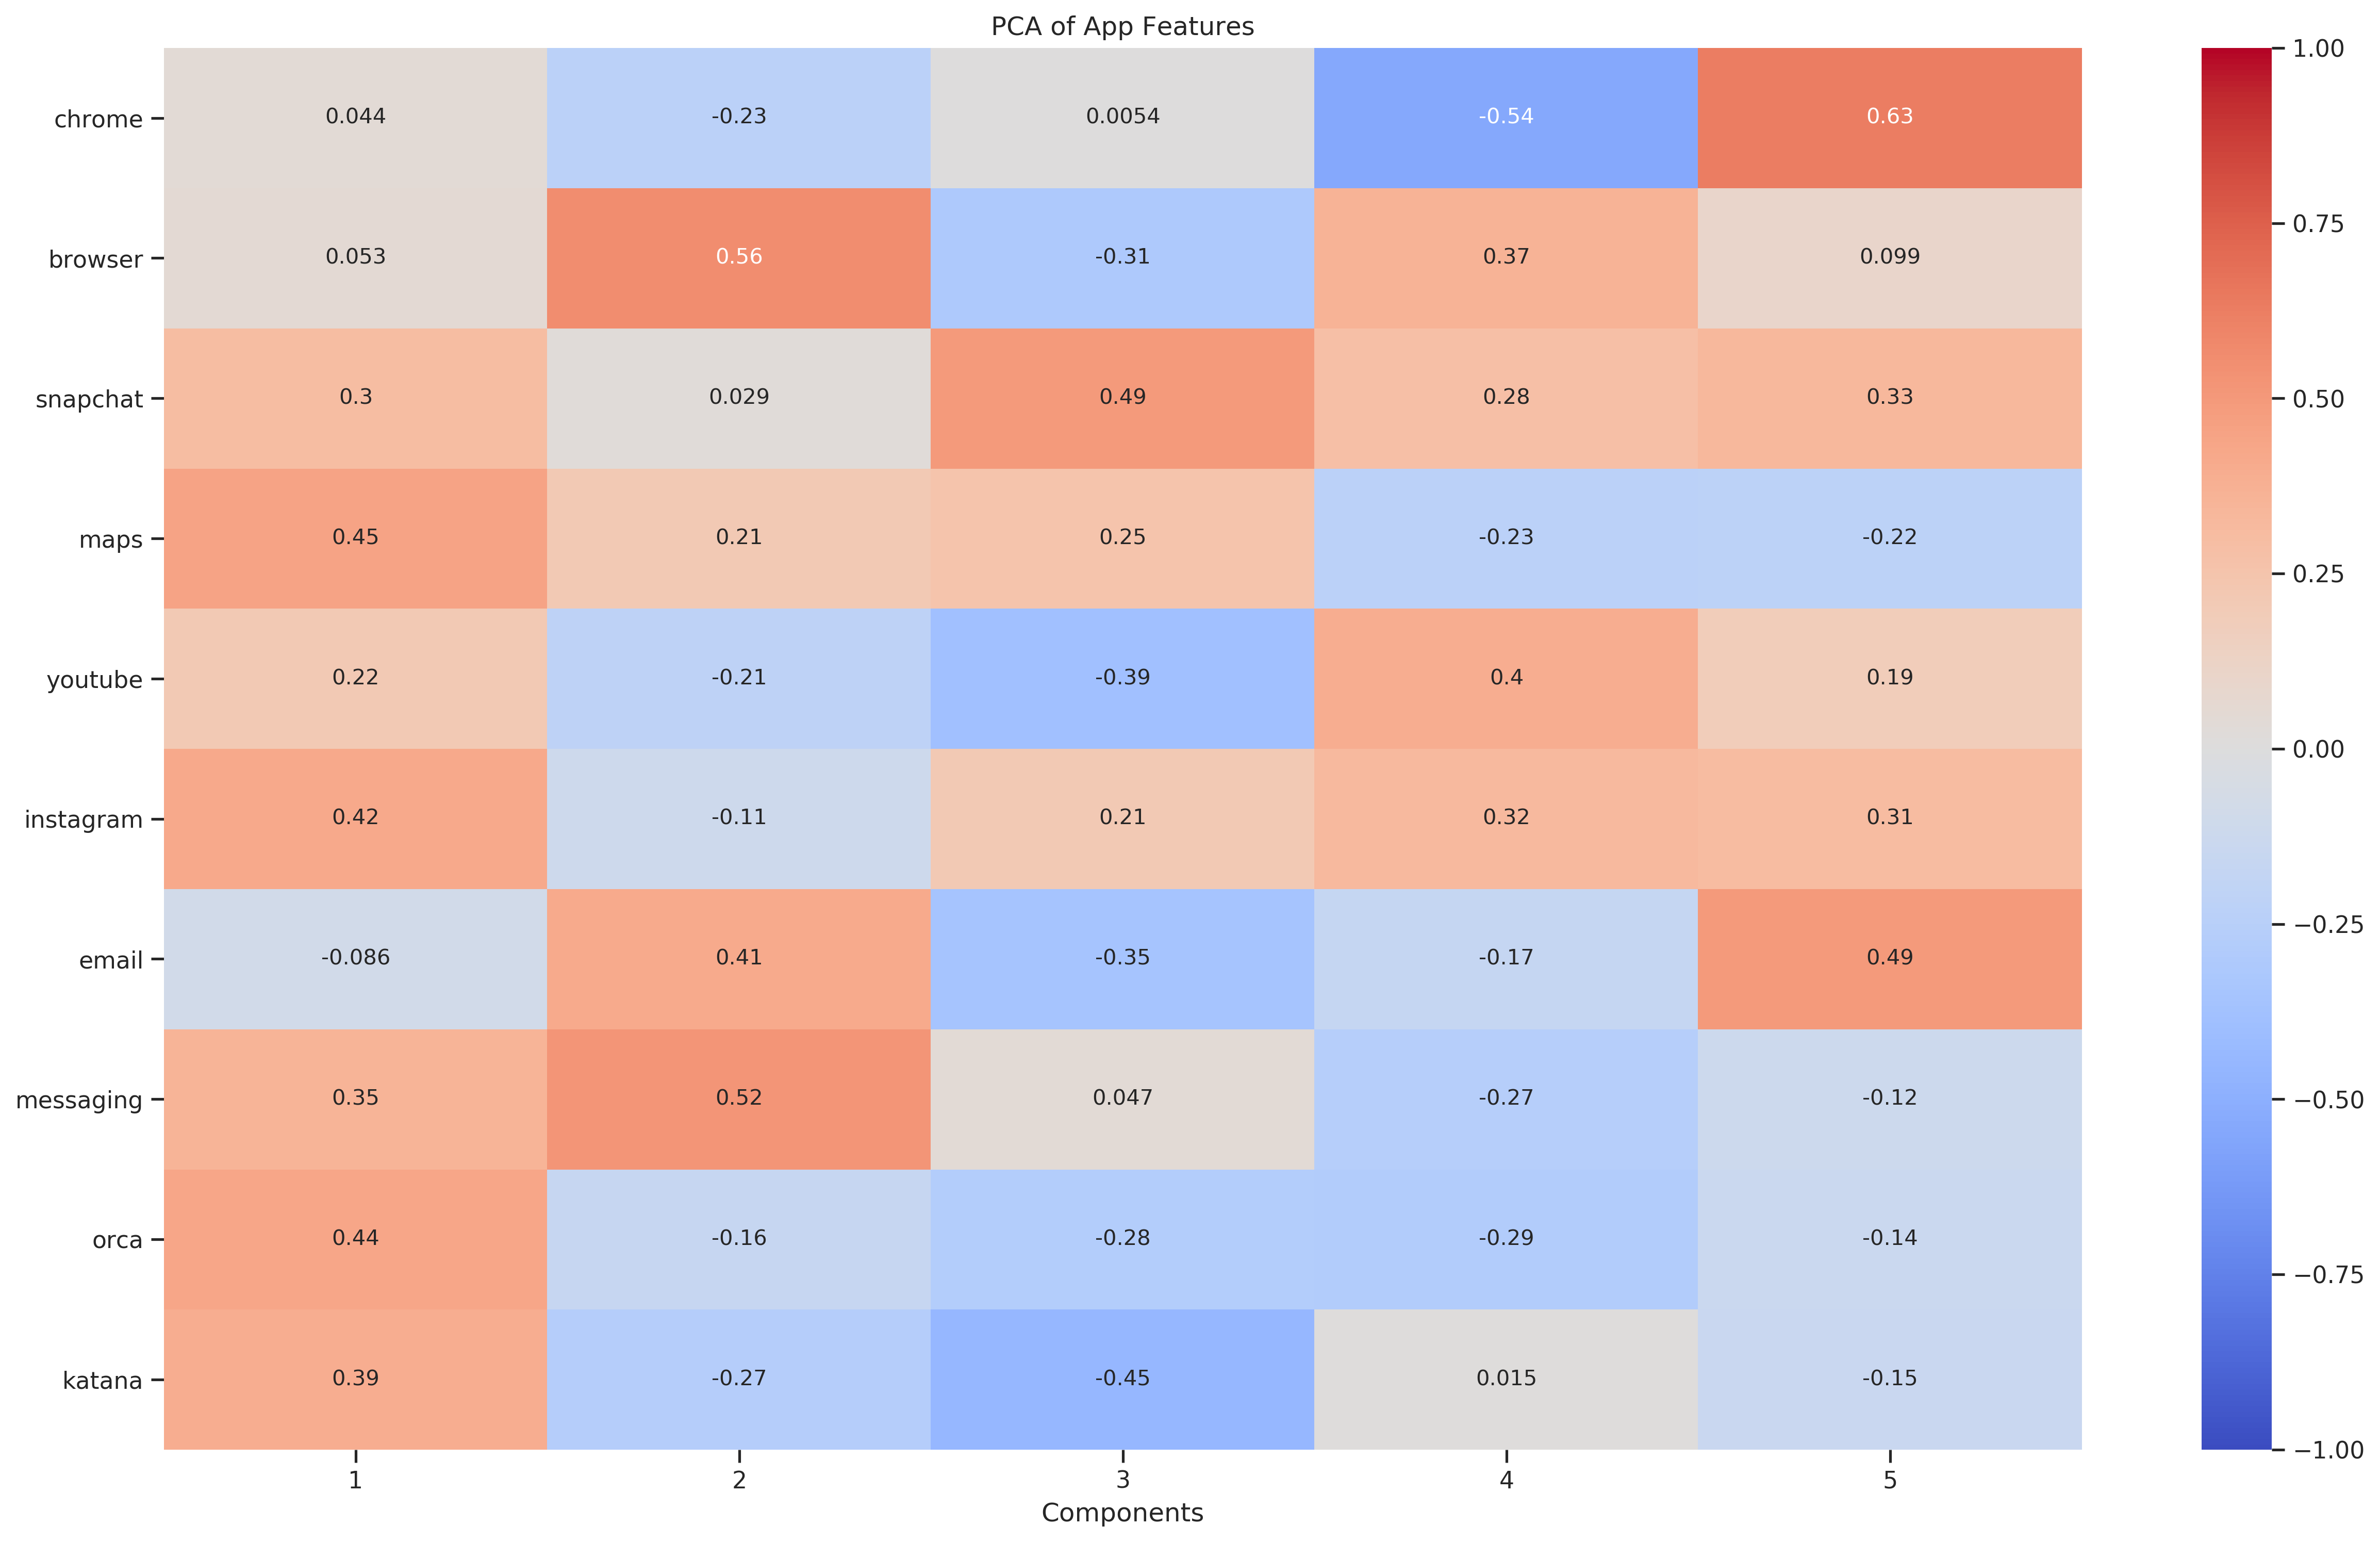

In [556]:
plot_PCA_components(fga_transformer, n_comps, fga_cols, "PCA of App Features")

In [557]:
var_df = pd.Series(fga_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df

var_explained
0       0.151812
1       0.127953
2       0.122201
3       0.113489
4       0.099319

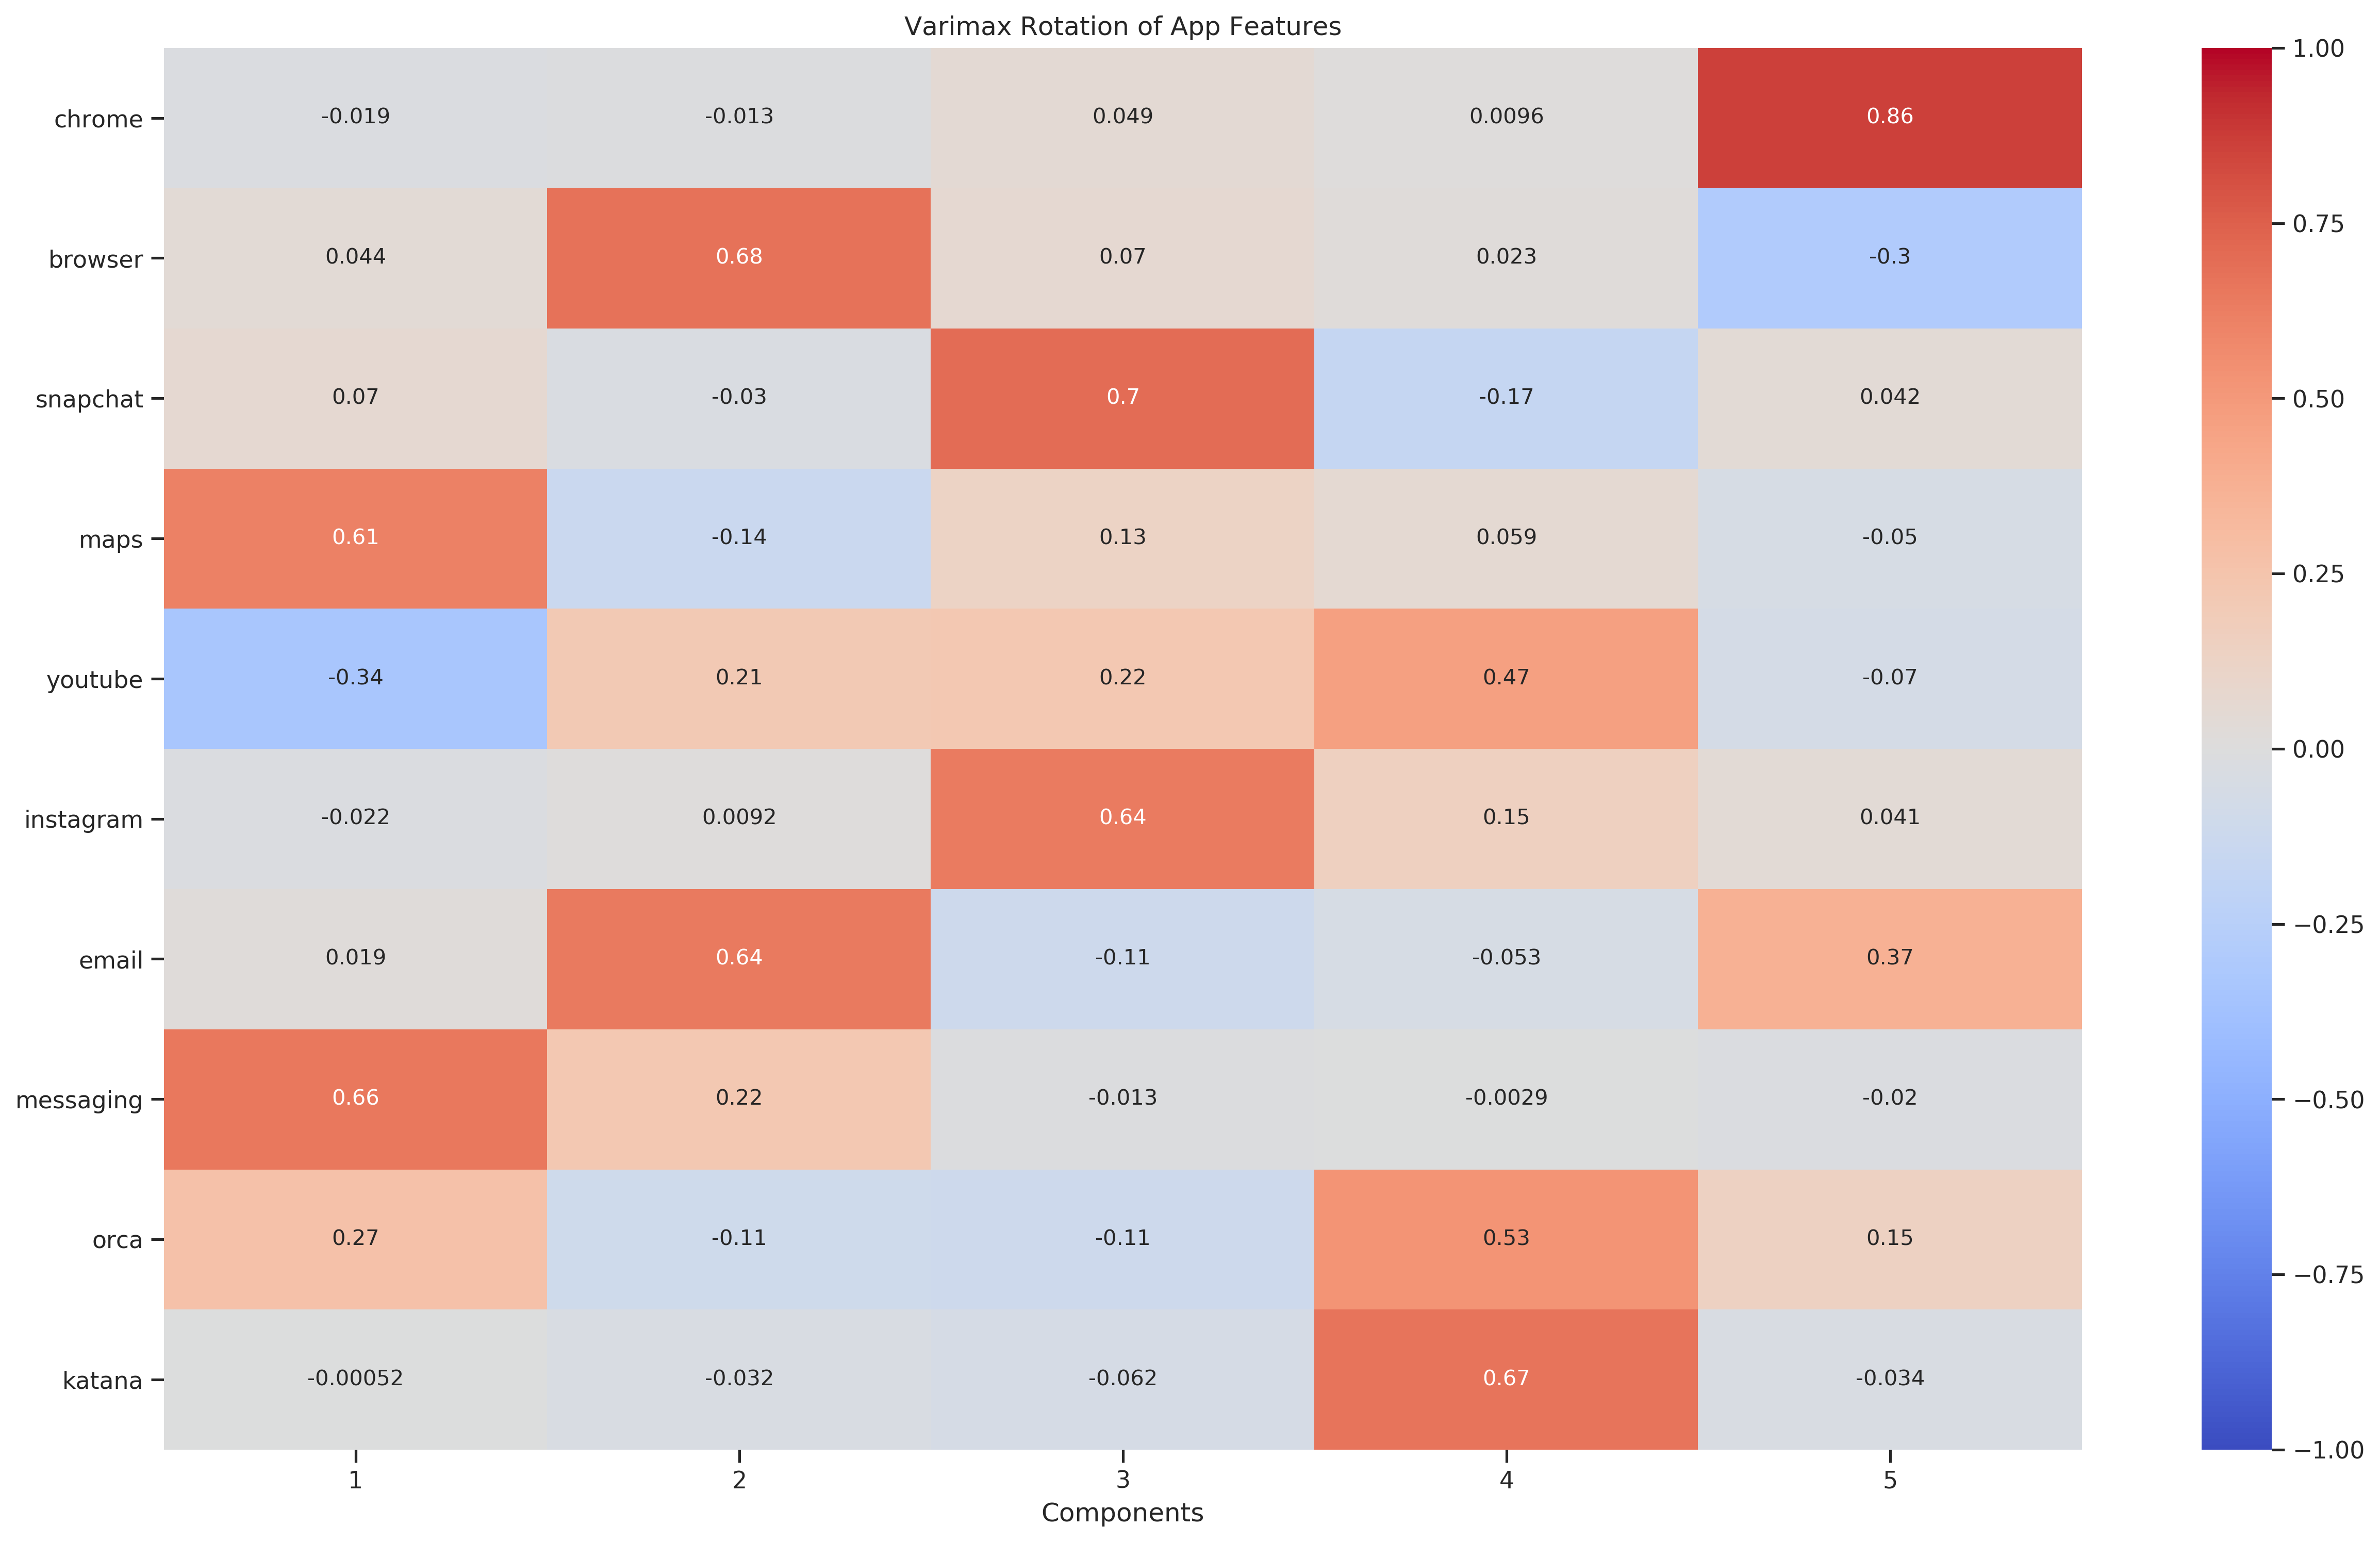

In [558]:
plot_varimax(fga_transformer, n_comps, fga_cols, "Varimax Rotation of App Features")

In [559]:
id_cols = ['pid', 'study_wk']
pc_cols = ['fga_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
fga_pc = pd.DataFrame(fga_transformed,
                      columns=pc_cols)
fga_pca_df = fga_pca_df.reset_index(drop=True)
fga_pca_df = pd.concat([fga_pca_df, fga_pc], axis=1)
agg_df = agg_df.merge(fga_pca_df[id_cols + pc_cols], how='left', on=id_cols)

## Semantic Location

In [560]:
sloc_pca_df = dig_state_df.copy()

sloc_dur_cols = sloc_daily.columns[sloc_daily.columns.str.endswith('dur')]

sloc_pca_df[sloc_dur_cols] = StandardScaler().fit_transform(sloc_pca_df[sloc_dur_cols])

sloc_pca_df = sloc_pca_df.dropna(how='any', subset=sloc_dur_cols)

n_comps = 4

n_cols = len(sloc_dur_cols)
sloc_transformer = PCA(n_components=n_comps, random_state=0)
sloc_transformed = sloc_transformer.fit_transform(sloc_pca_df[sloc_dur_cols])

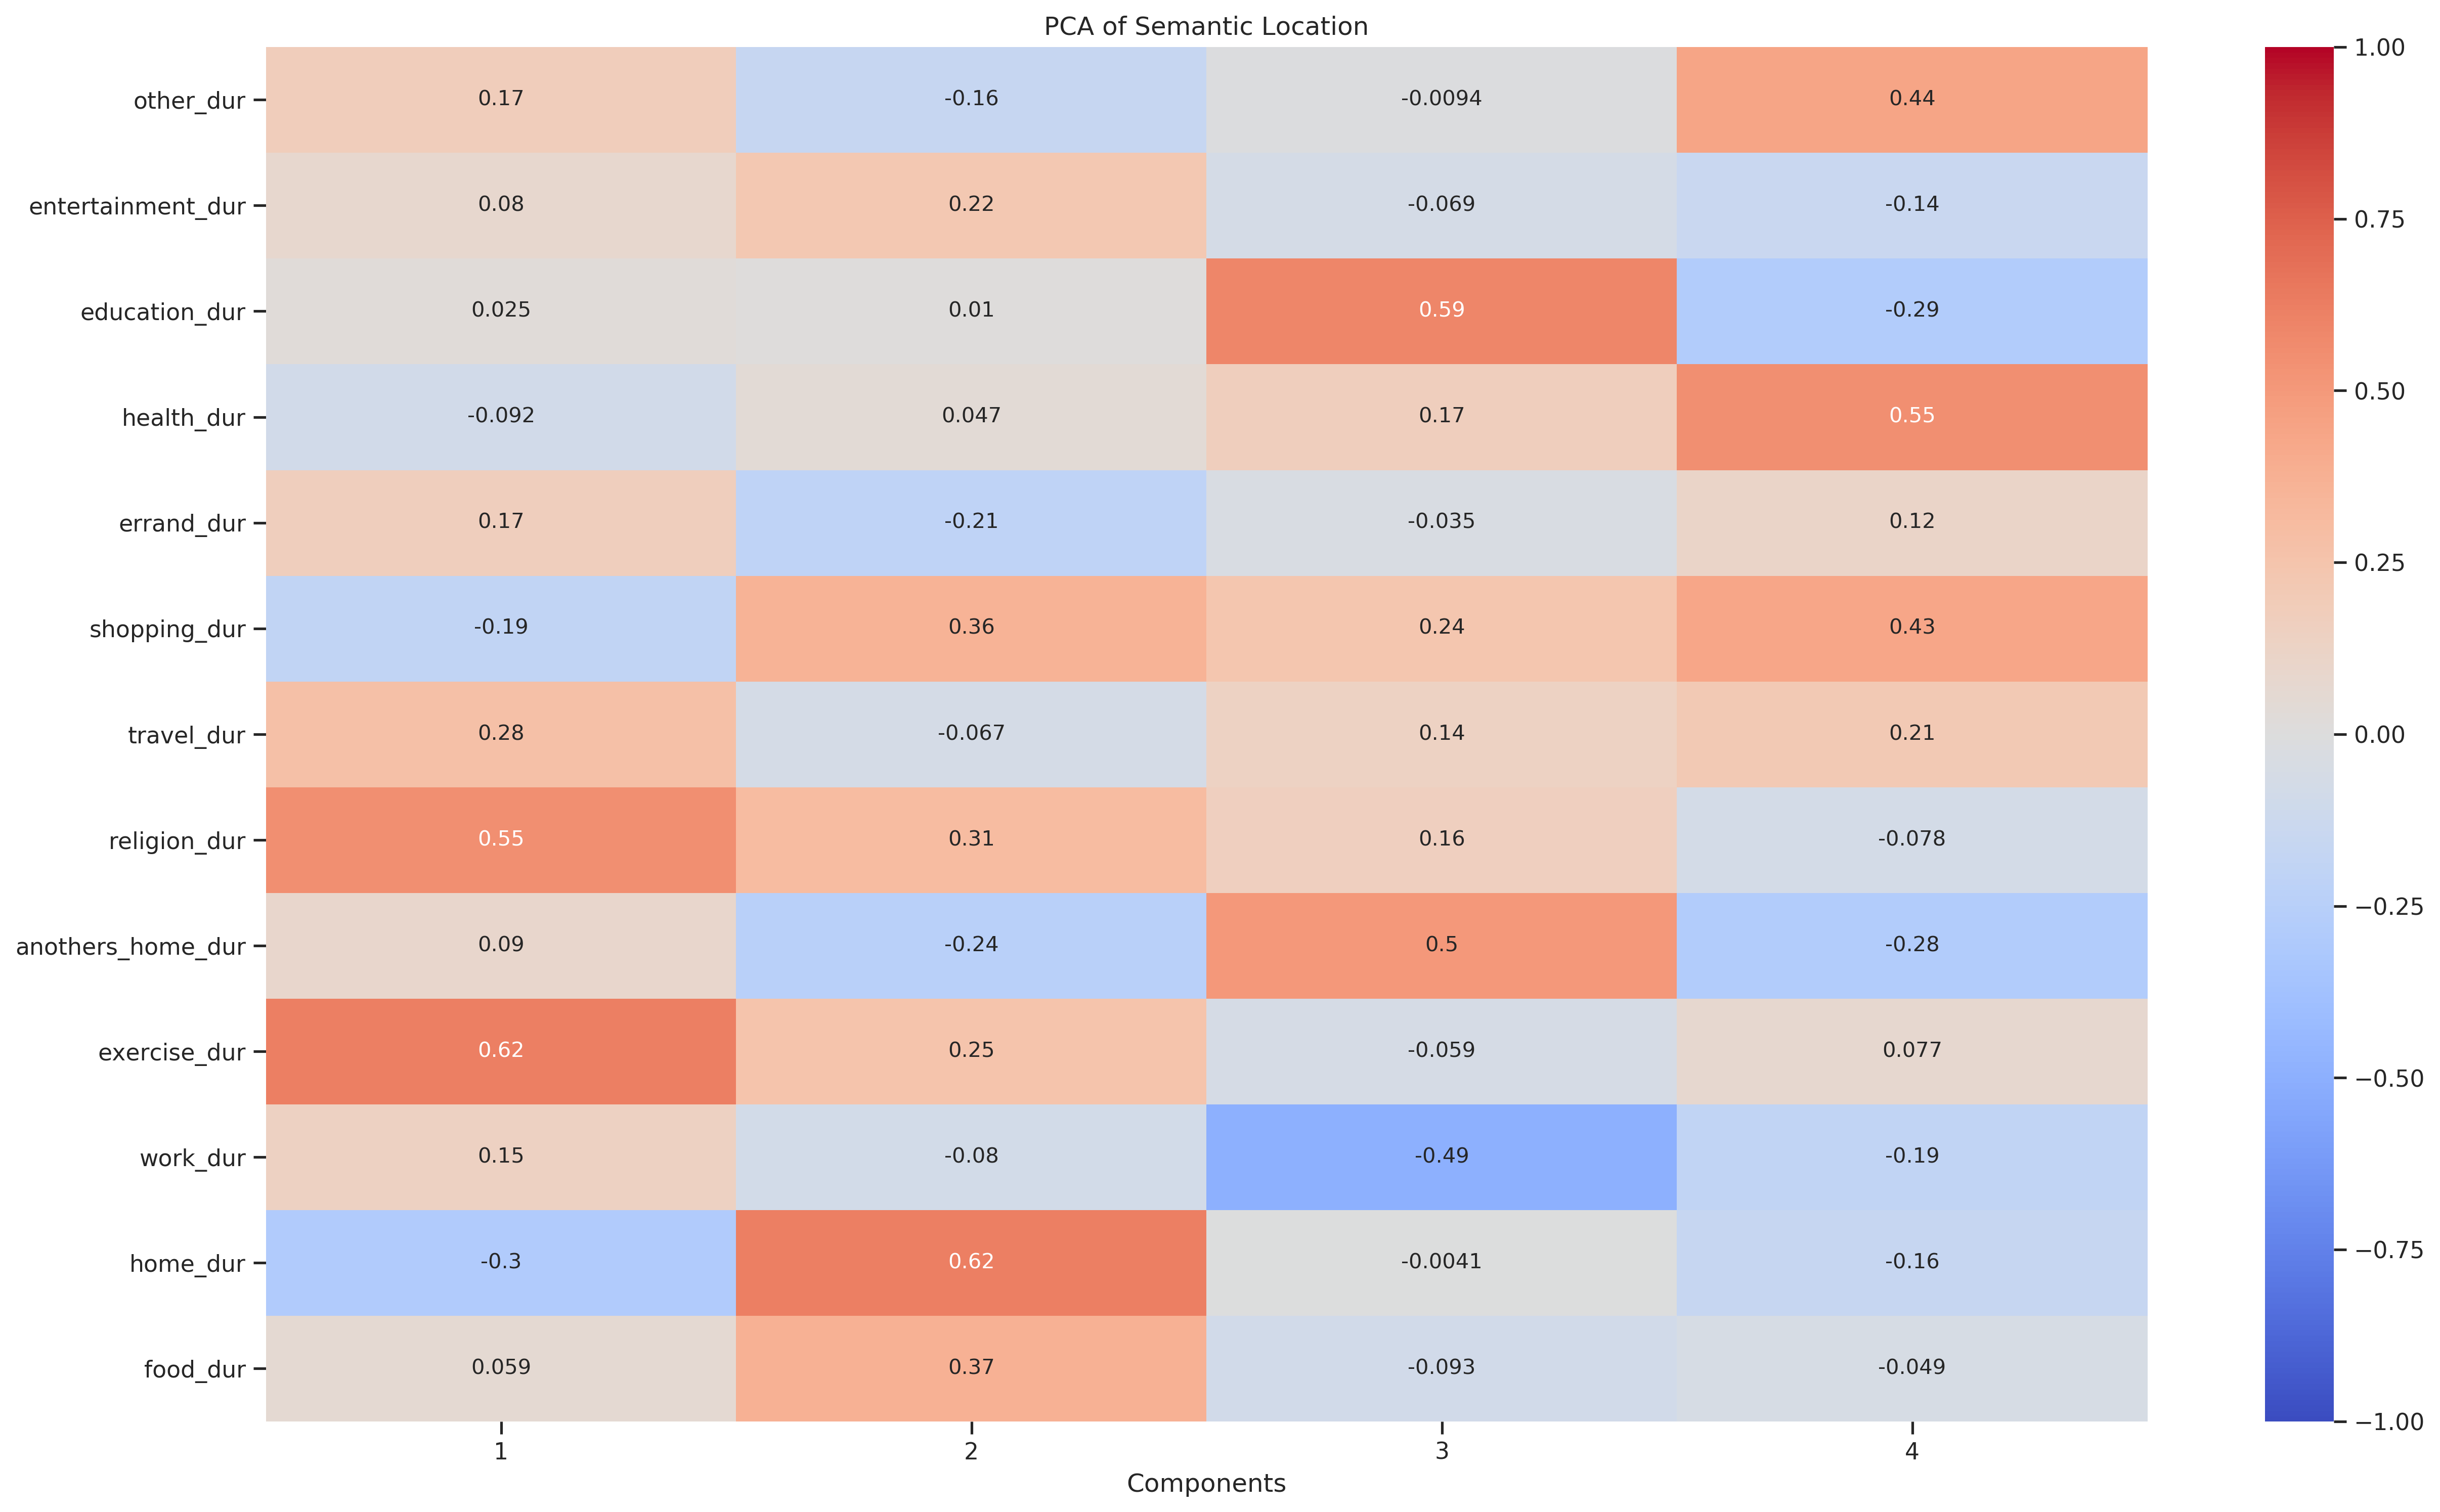

In [561]:
plot_PCA_components(sloc_transformer, n_comps, sloc_dur_cols, "PCA of Semantic Location")

In [562]:
get_var_explained(sloc_transformer)

var_explained
0       0.124920
1       0.110971
2       0.094249
3       0.088658

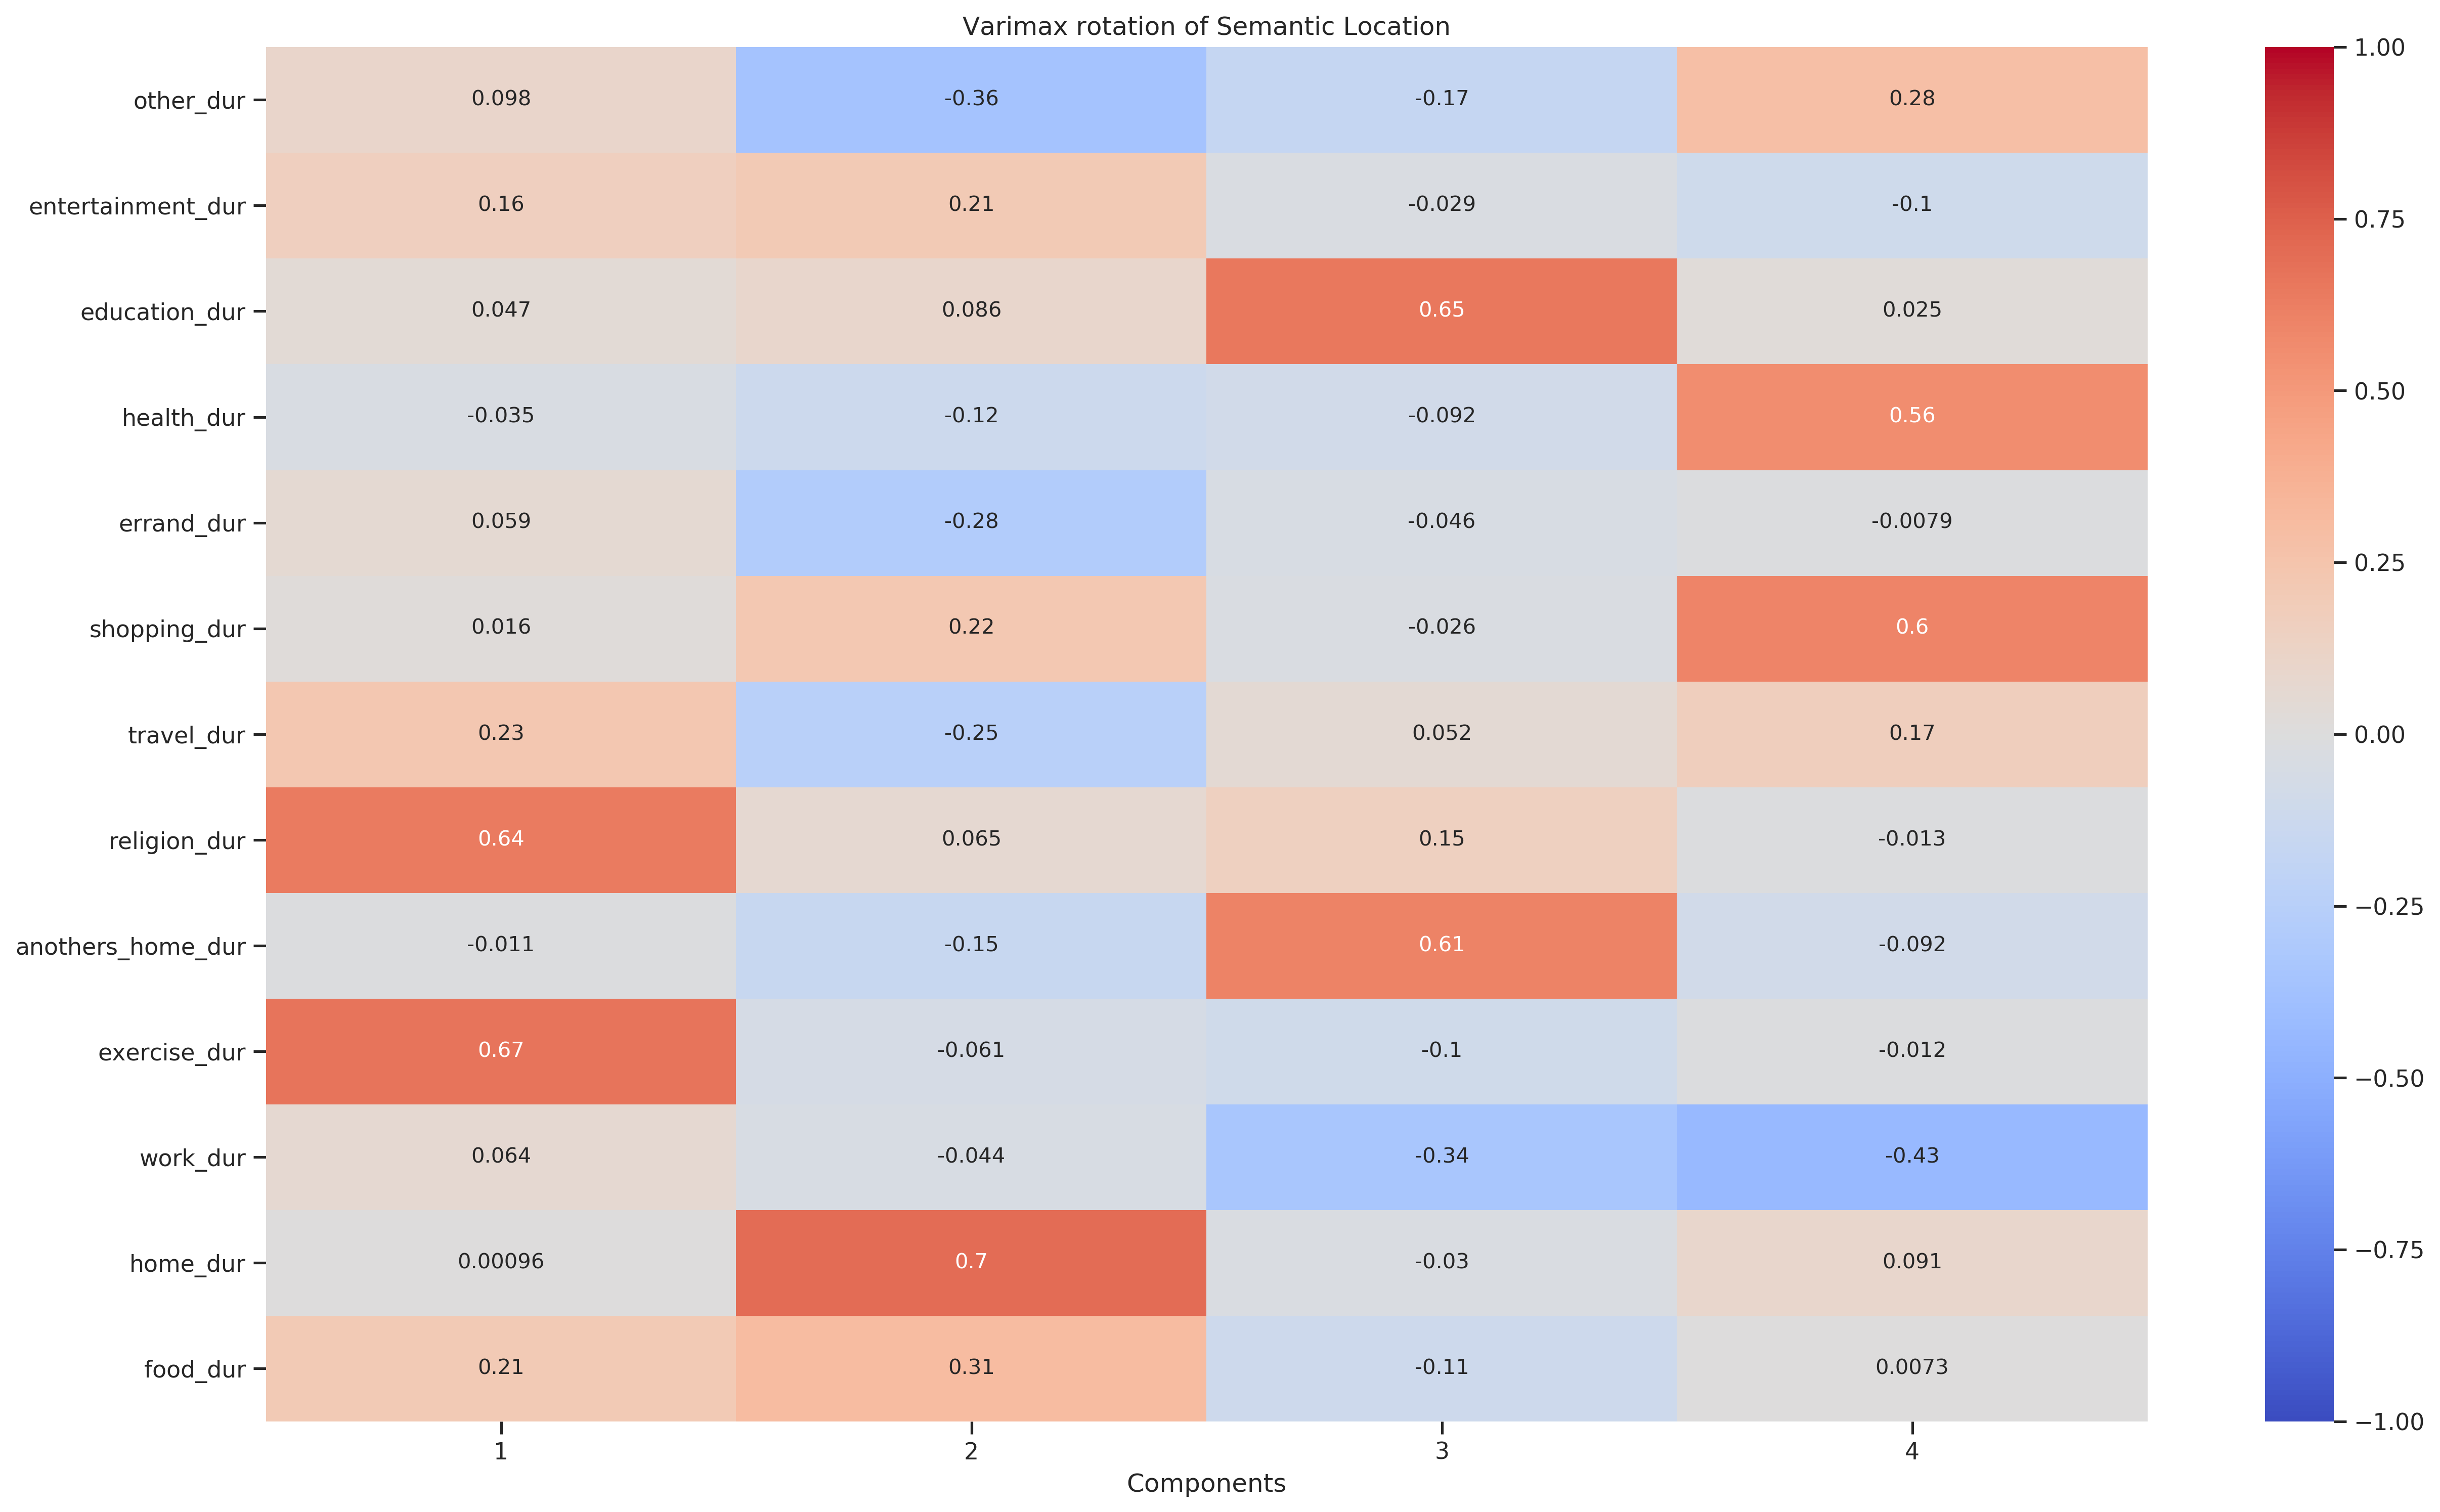

In [563]:
plot_varimax(sloc_transformer, n_comps, sloc_dur_cols, "Varimax rotation of Semantic Location")

In [564]:
pc_cols = ['sloc_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
sloc_pc = pd.DataFrame(sloc_transformed,
                      columns=pc_cols)
sloc_pca_df = sloc_pca_df.reset_index(drop=True)
sloc_pca_df = pd.concat([sloc_pca_df, sloc_pc], axis=1)
agg_df = agg_df.merge(sloc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

## Semantic Location Transitions

- TODO

## Communication

In [565]:
comm_pca_df = dig_state_df.copy()
comm_cols = cal_cols + sms_cols

comm_pca_df[comm_cols] = StandardScaler().fit_transform(comm_pca_df[comm_cols])
comm_pca_df = comm_pca_df.dropna(how='any', subset=comm_cols)

n_comps = 2

n_cols = len(comm_cols)
comm_transformer = PCA(n_components=n_comps, random_state=0)
comm_transformed = comm_transformer.fit_transform(comm_pca_df[comm_cols])

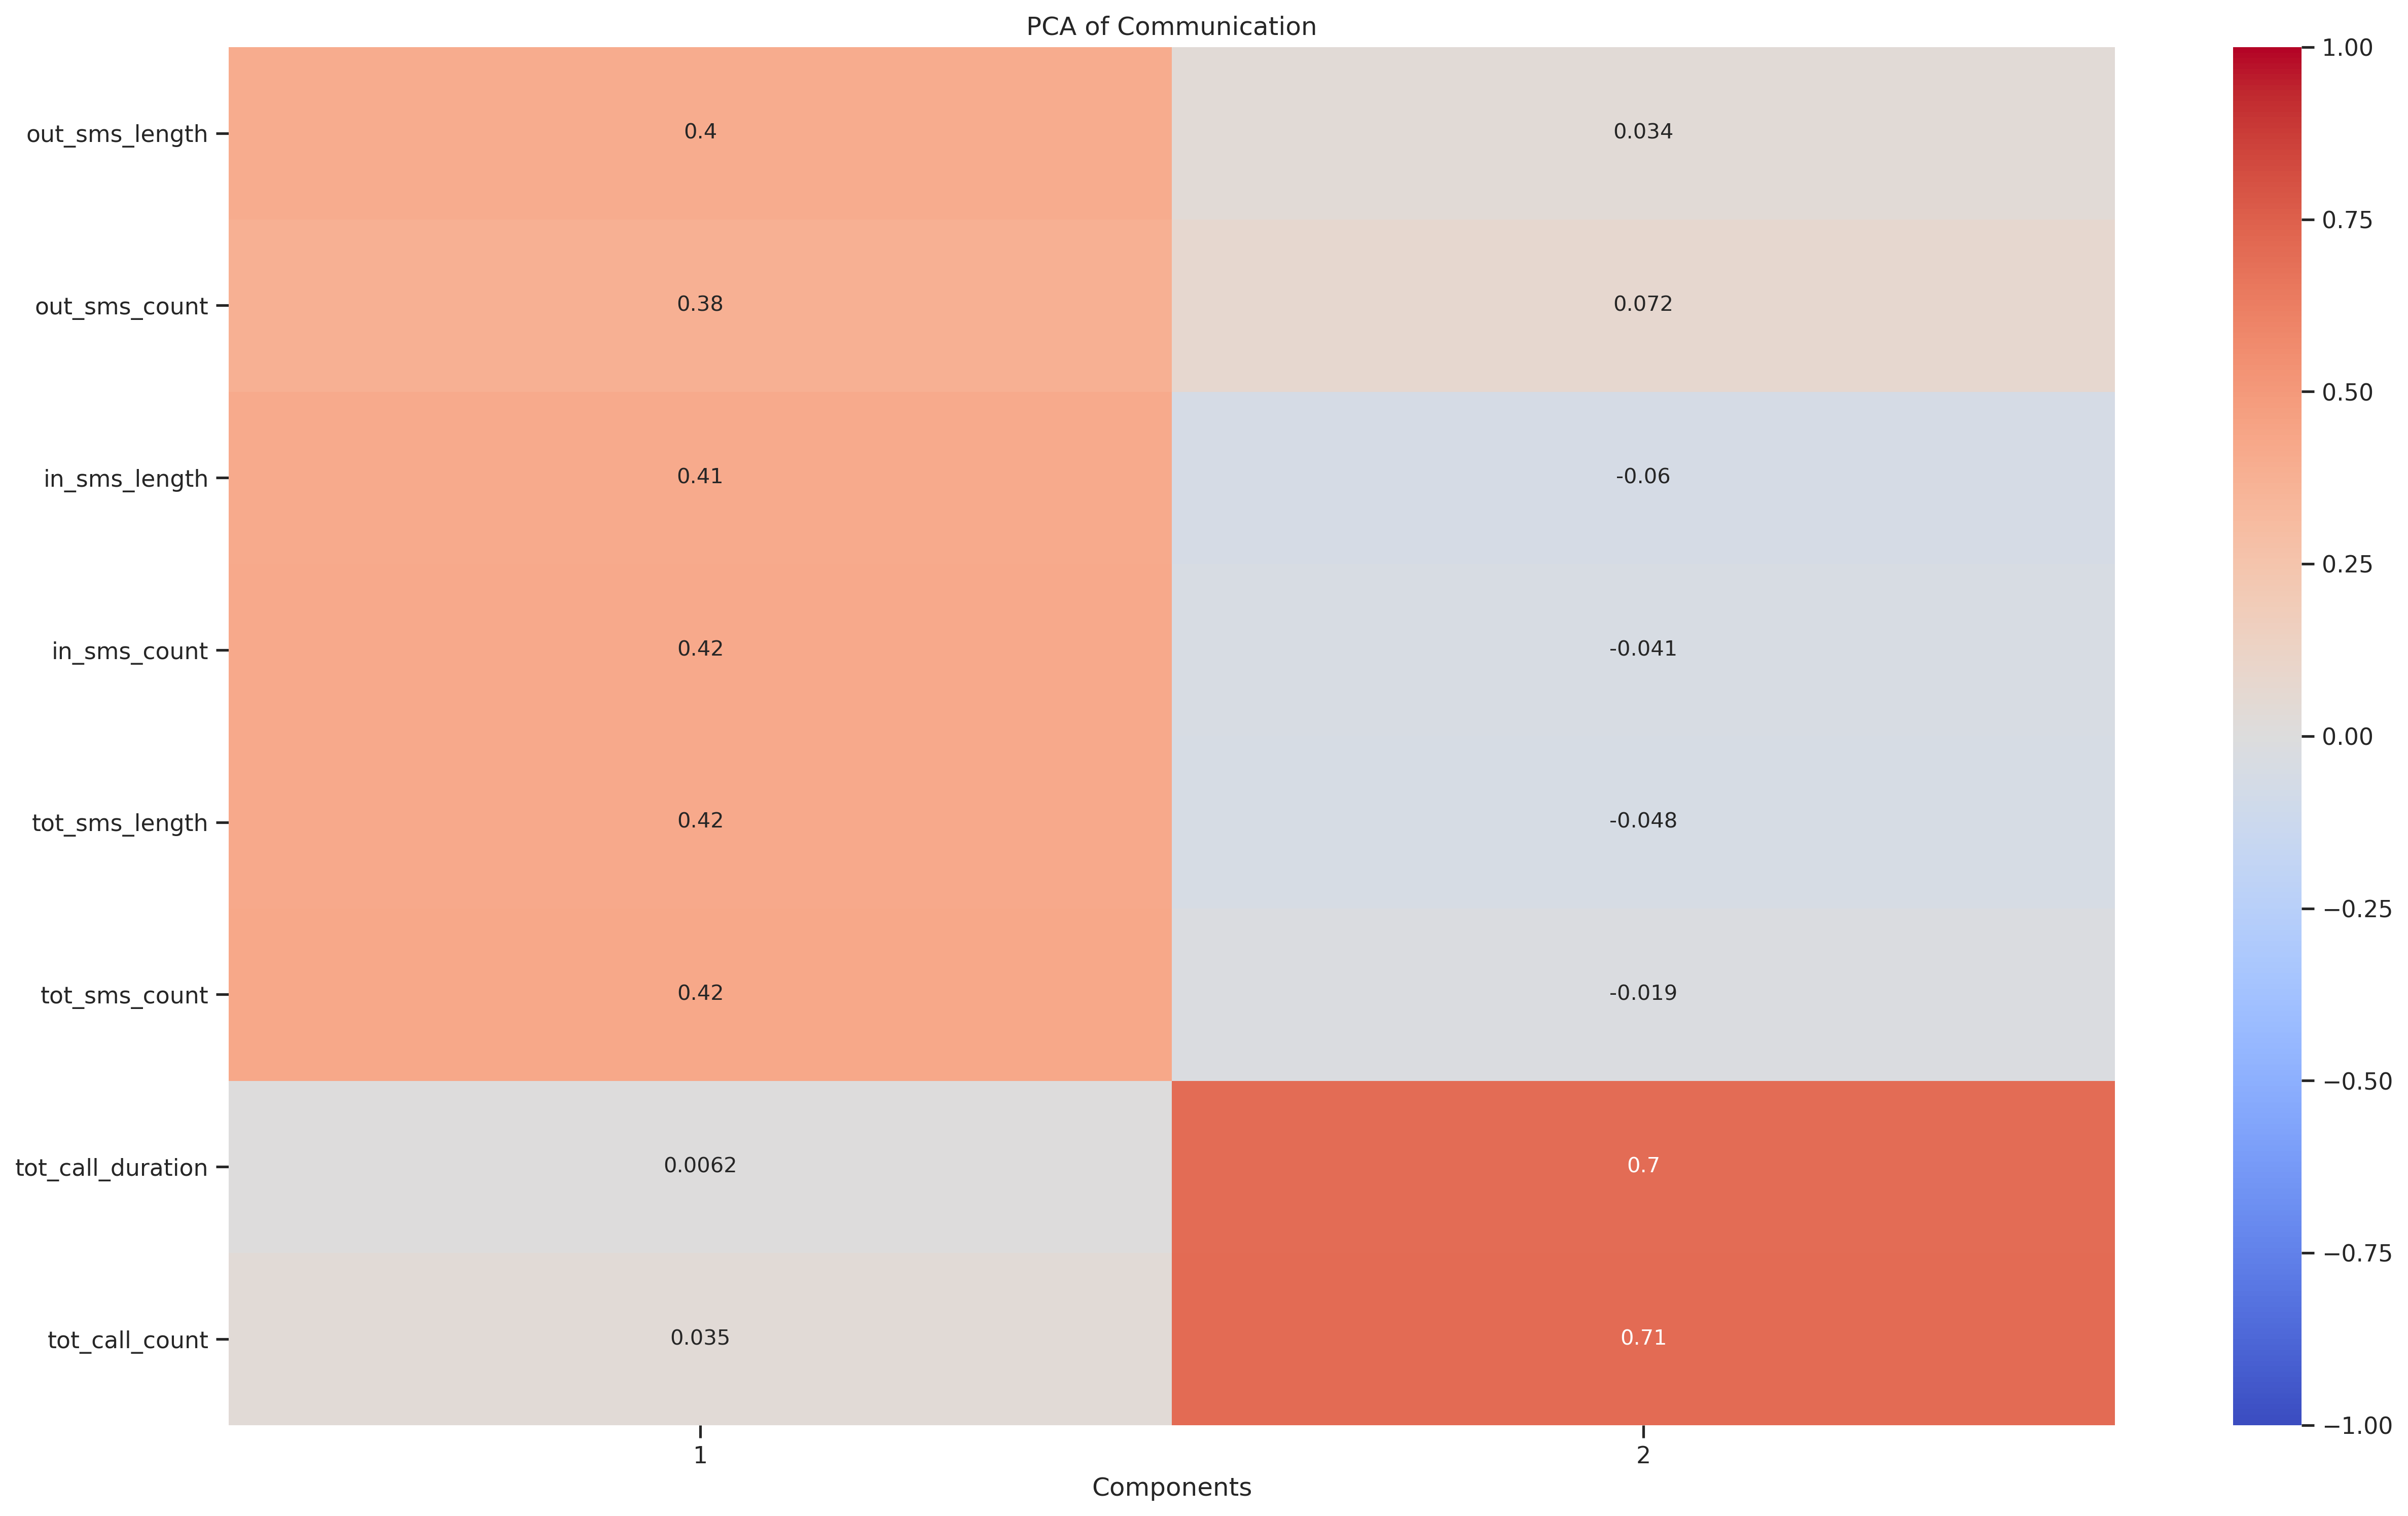

In [566]:
plot_PCA_components(comm_transformer, n_comps, comm_cols, "PCA of Communication")

In [567]:
get_var_explained(comm_transformer)

var_explained
0       0.689875
1       0.165154

In [568]:
agg_df[sms_cols] = (agg_df[sms_cols] - agg_df[sms_cols].mean()) / agg_df[sms_cols].std()
agg_df[cal_cols] = (agg_df[cal_cols] - agg_df[cal_cols].mean()) / agg_df[cal_cols].std()
agg_df['sms_agg'] = agg_df[sms_cols].mean(axis=1)
agg_df['cal_agg'] = agg_df[cal_cols].mean(axis=1)

## Fused Location

In [569]:
loc_pca_df = dig_state_df.copy()
loc_cols = circ_cols + fus_cols

# fillna with participant mean
#loc_pca_df[loc_cols] = loc_pca_df.groupby('pid')[loc_cols].transform(lambda x: x.fillna(x.mean()))

loc_pca_df[loc_cols] = StandardScaler().fit_transform(loc_pca_df[loc_cols])


#loc_pca_df[loc_cols] = (loc_pca_df[loc_cols] - loc_pca_df[loc_cols].mean()) / loc_pca_df[loc_cols].std()

loc_pca_df = loc_pca_df.dropna(how='any', subset=loc_cols)
#loc_pca_df = loc_pca_df[~loc_pca_df['katana'].isna()]

n_comps = 3

n_cols = len(loc_cols)
loc_transformer = PCA(n_components=n_comps, random_state=0)
loc_transformed = loc_transformer.fit_transform(loc_pca_df[loc_cols])

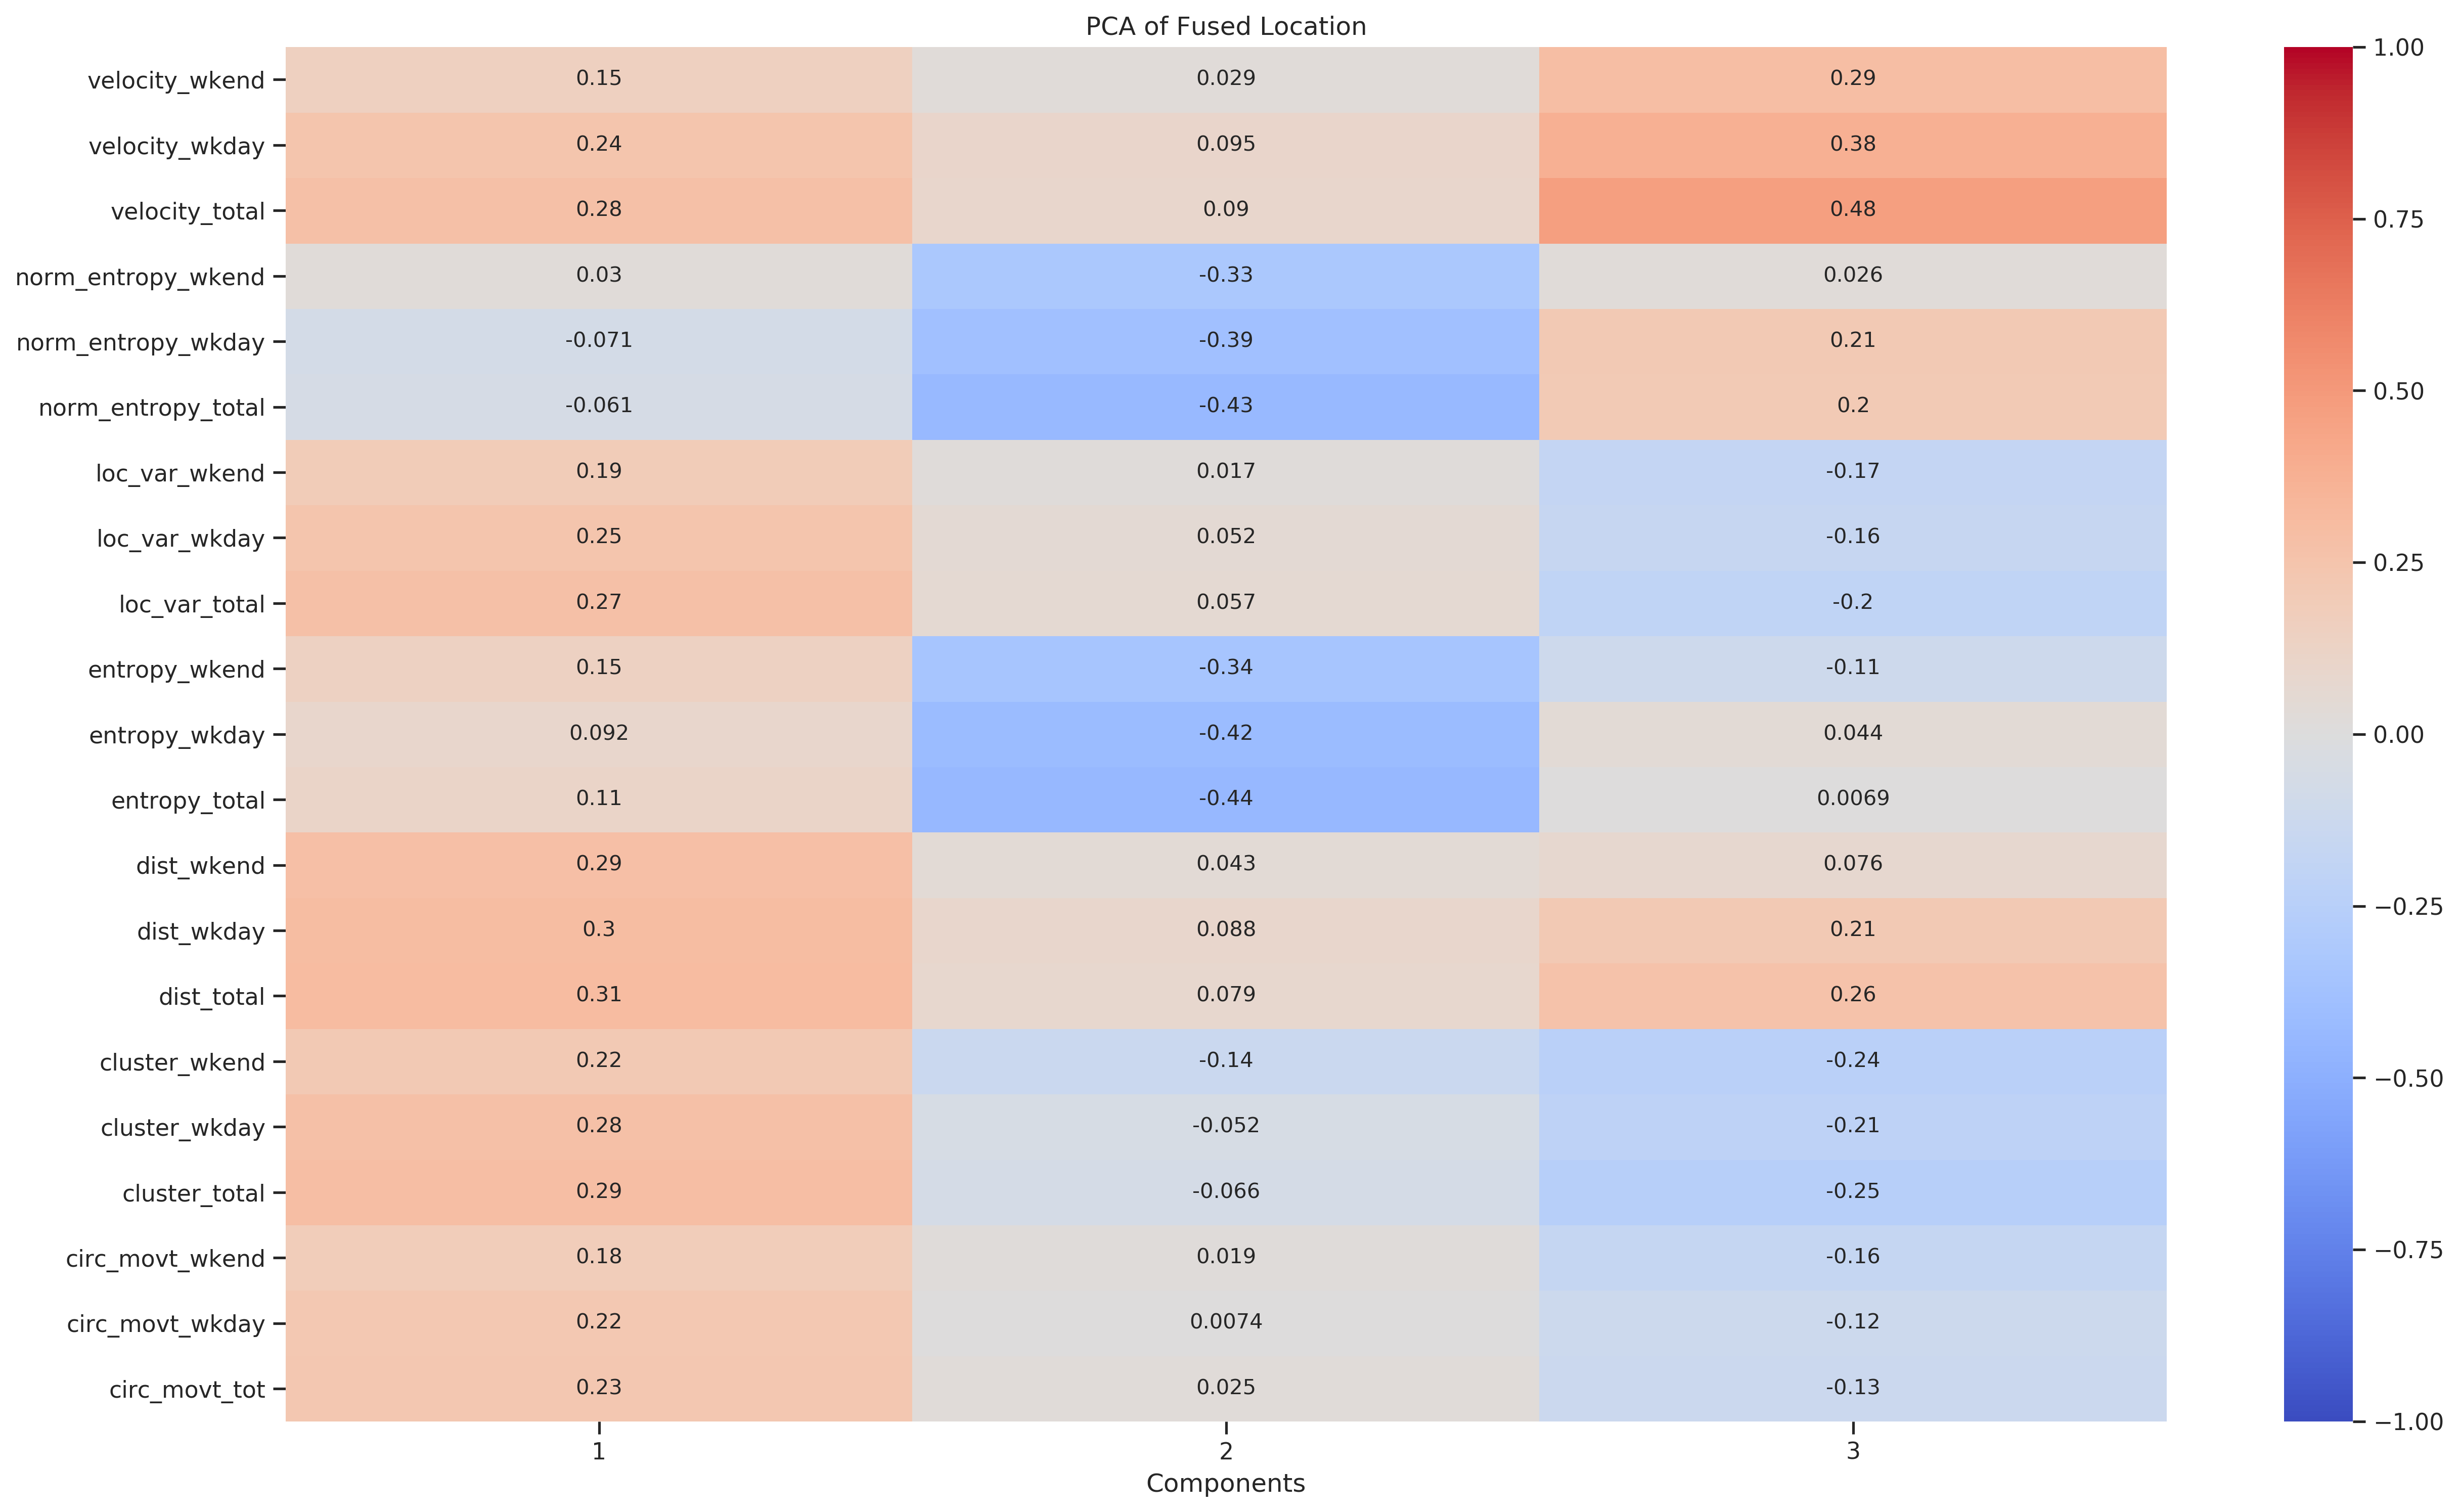

In [570]:
plot_PCA_components(loc_transformer, n_comps, loc_cols, "PCA of Fused Location")

In [571]:
get_var_explained(loc_transformer)

var_explained
0       0.382082
1       0.169574
2       0.128463

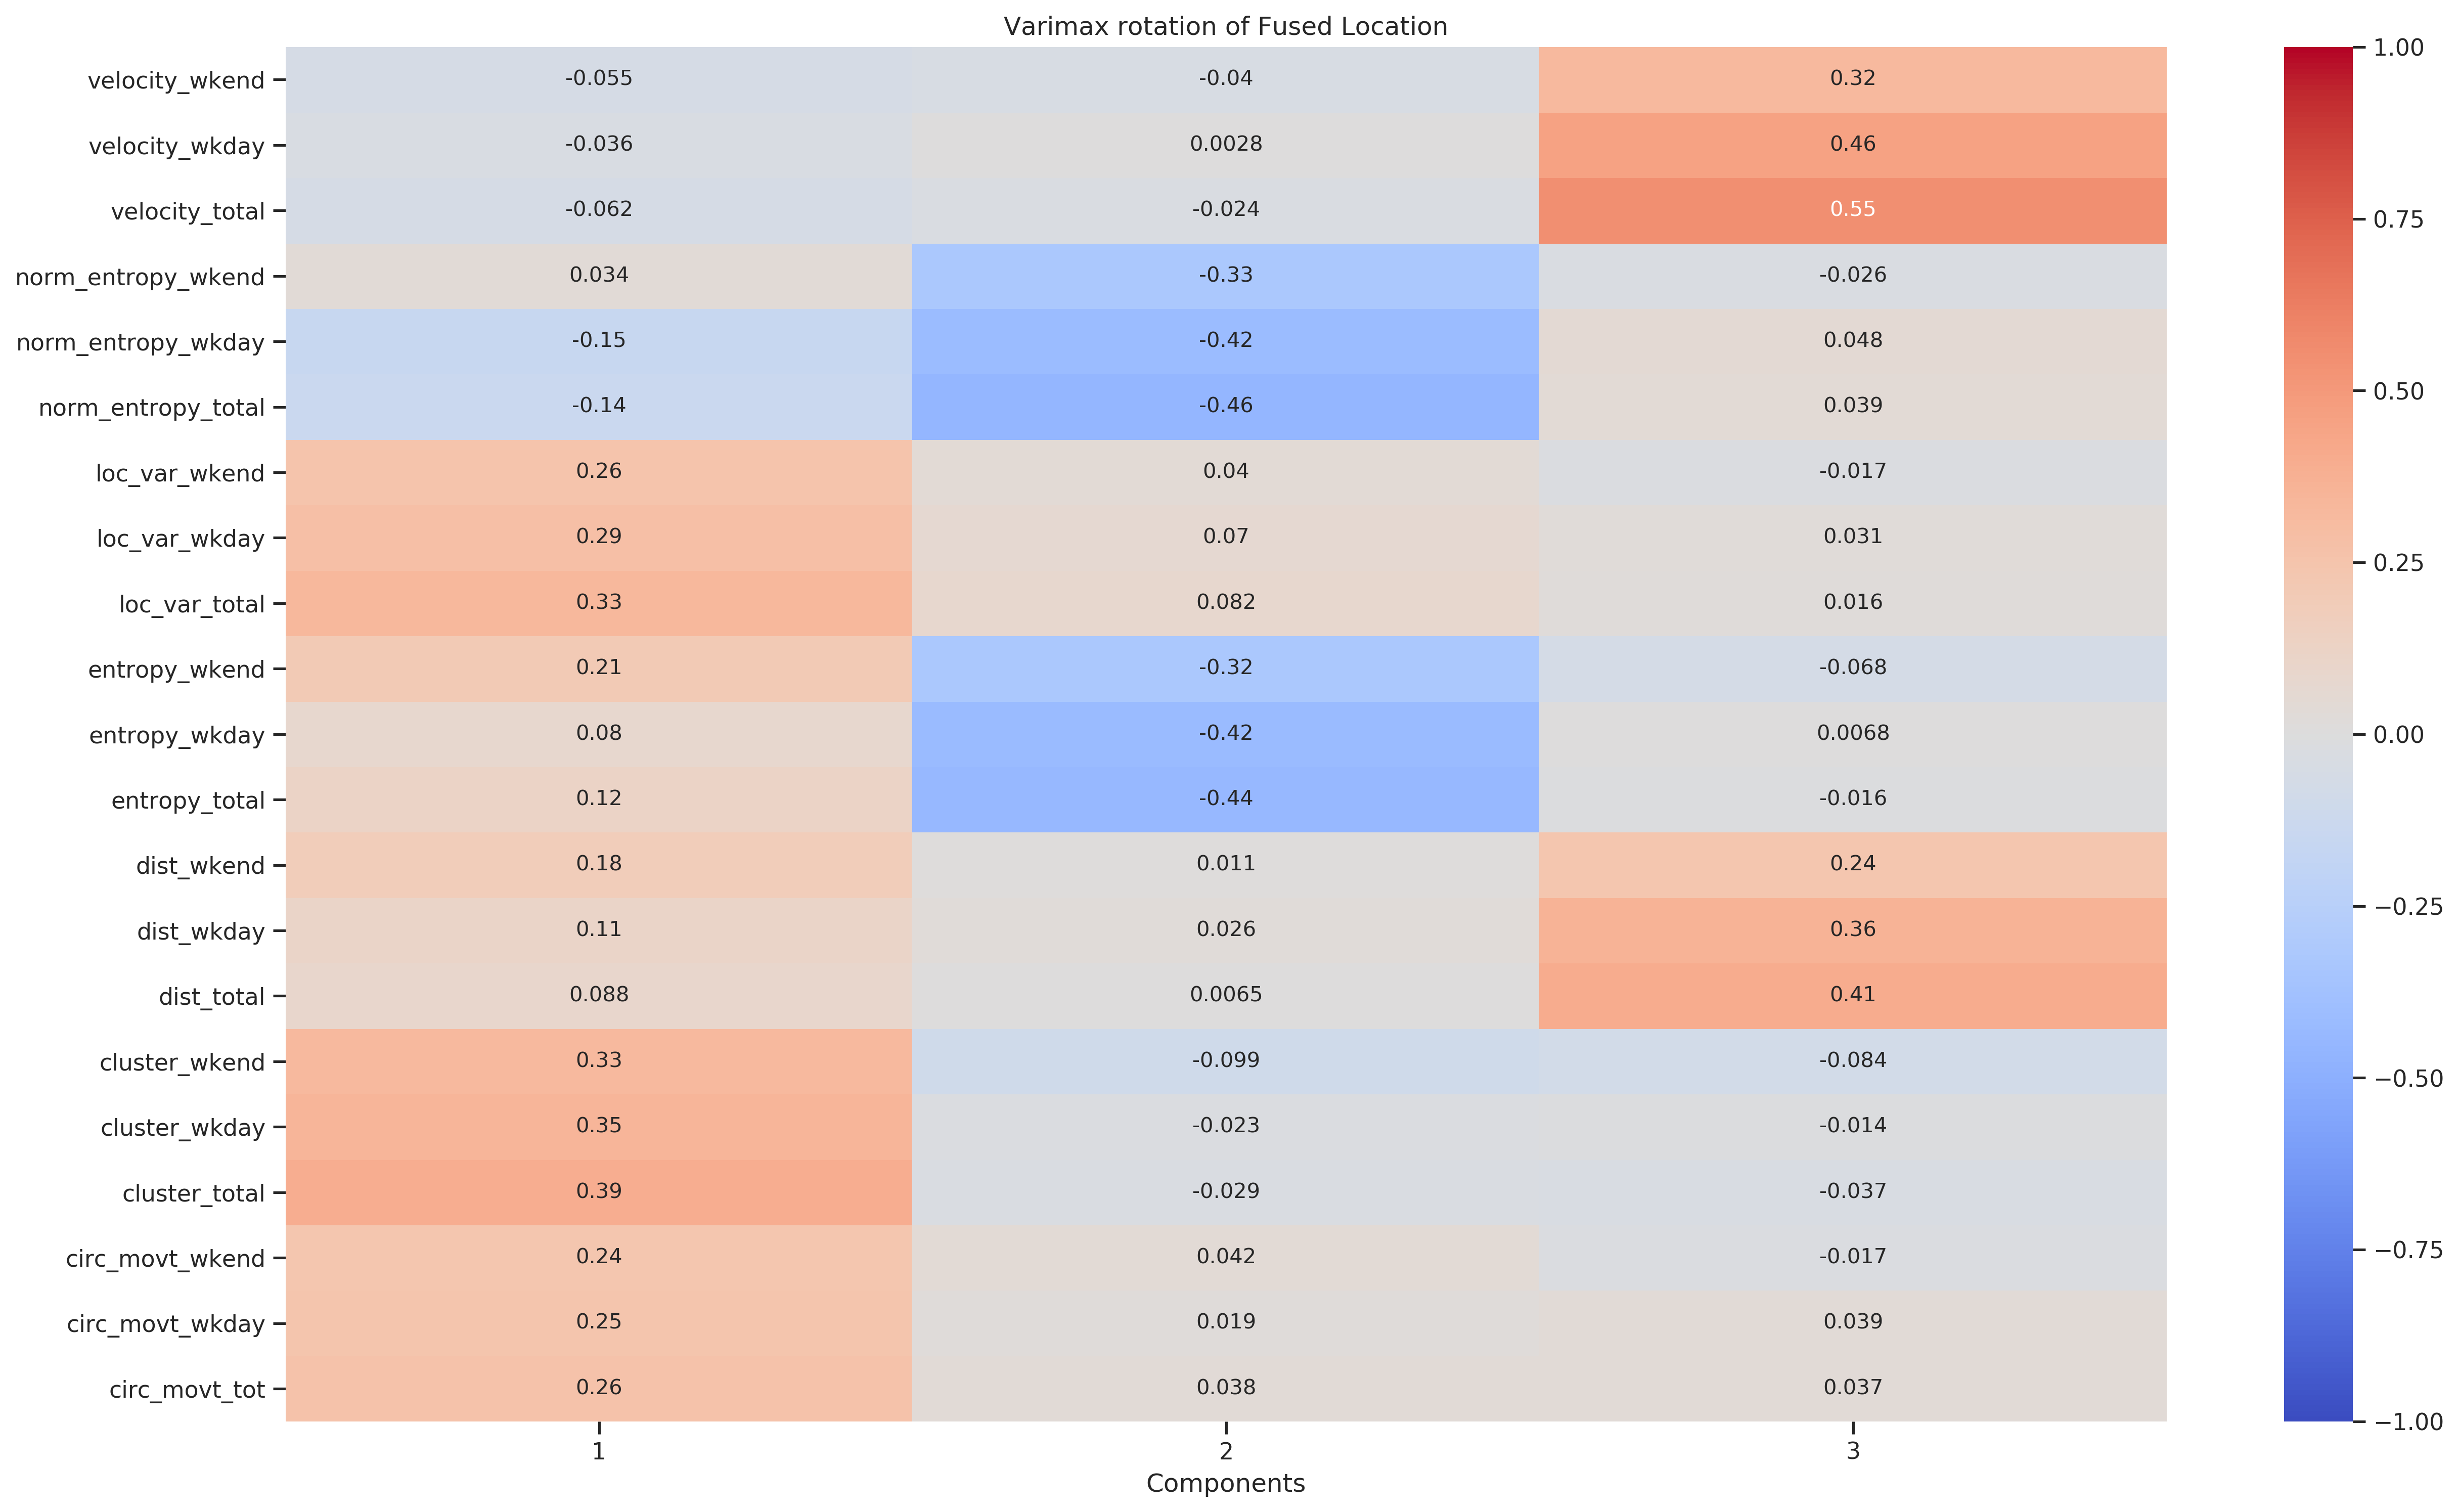

In [572]:
plot_varimax(loc_transformer, n_comps, loc_cols, "Varimax rotation of Fused Location")

In [573]:
pc_cols = ['loc_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
loc_pc = pd.DataFrame(loc_transformed,
                      columns=pc_cols)
loc_pca_df = loc_pca_df.reset_index(drop=True)
loc_pca_df = pd.concat([loc_pca_df, loc_pc], axis=1)
agg_df = agg_df.merge(loc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

# Change in Sensors

In [574]:
agg_cols = agg_df.columns[agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [575]:
agg_df[agg_cols_shift] = agg_df.groupby('pid')[agg_cols].shift(1)

In [576]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    agg_df[change] = agg_df[cur] - agg_df[prev]

In [577]:
agg_df['gad_diff'].describe()

count    772.000000
mean      -0.107513
std        3.695631
min      -14.000000
25%       -2.000000
50%        0.000000
75%        2.000000
max       15.000000
Name: gad_diff, dtype: float64

In [578]:
agg_df['spin_diff'].describe()

count    771.000000
mean      -0.155642
std        6.563112
min      -30.000000
25%       -3.000000
50%        0.000000
75%        3.000000
max       36.000000
Name: spin_diff, dtype: float64

## SPIN

### Simple Correlation

#### Full population

In [579]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['spin_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


X          Y    n      r    p-corr p-adjust
1  passive_apps_agg_change  spin_diff  767  0.104  0.064177   fdr_bh

Spearman


X          Y    n      r   p-corr p-adjust
1  passive_apps_agg_change  spin_diff  767  0.115  0.02448   fdr_bh

#### no_symp

In [580]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### soc_anx

In [581]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


X          Y    n      r    p-corr p-adjust
1   passive_apps_agg_change  spin_diff  202  0.224  0.023506   fdr_bh
11      sloc_pc4_agg_change  spin_diff  202 -0.196  0.044517   fdr_bh

Spearman


X          Y    n      r    p-corr p-adjust
1  passive_apps_agg_change  spin_diff  202  0.195  0.092459   fdr_bh

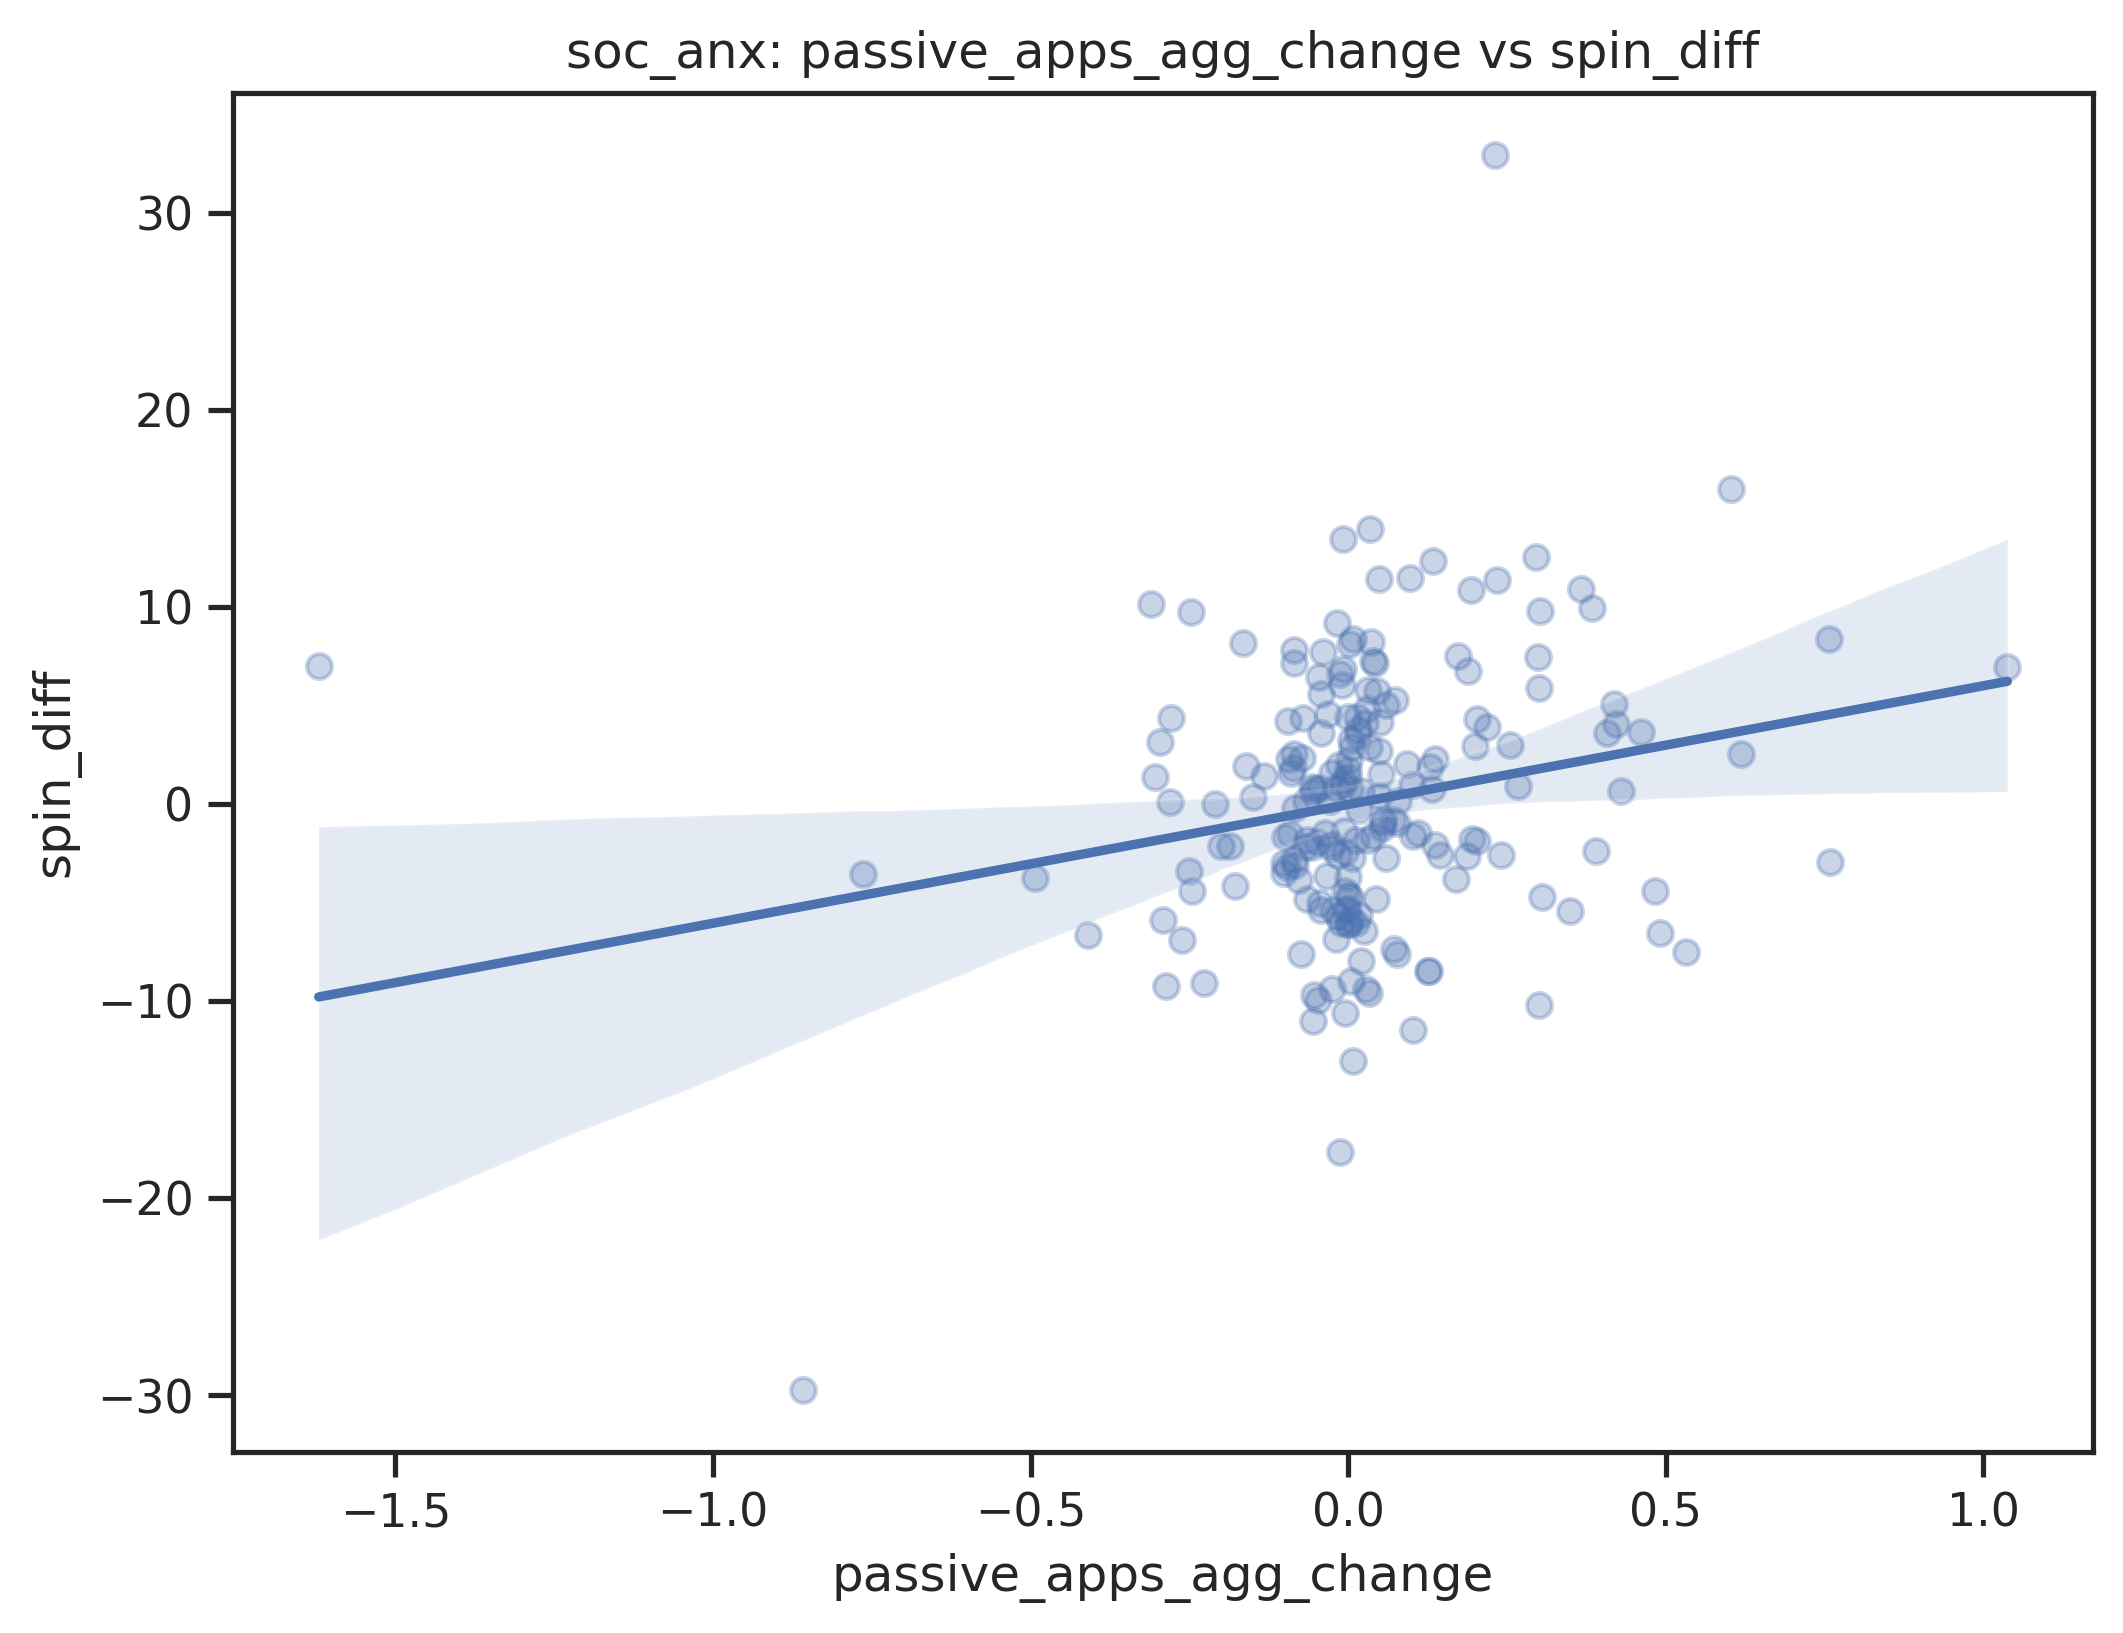

In [582]:
scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

#### gen_anx

In [592]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X          Y    n      r    p-corr p-adjust
4  fga_pc2_agg_change  spin_diff  175 -0.218  0.063313   fdr_bh

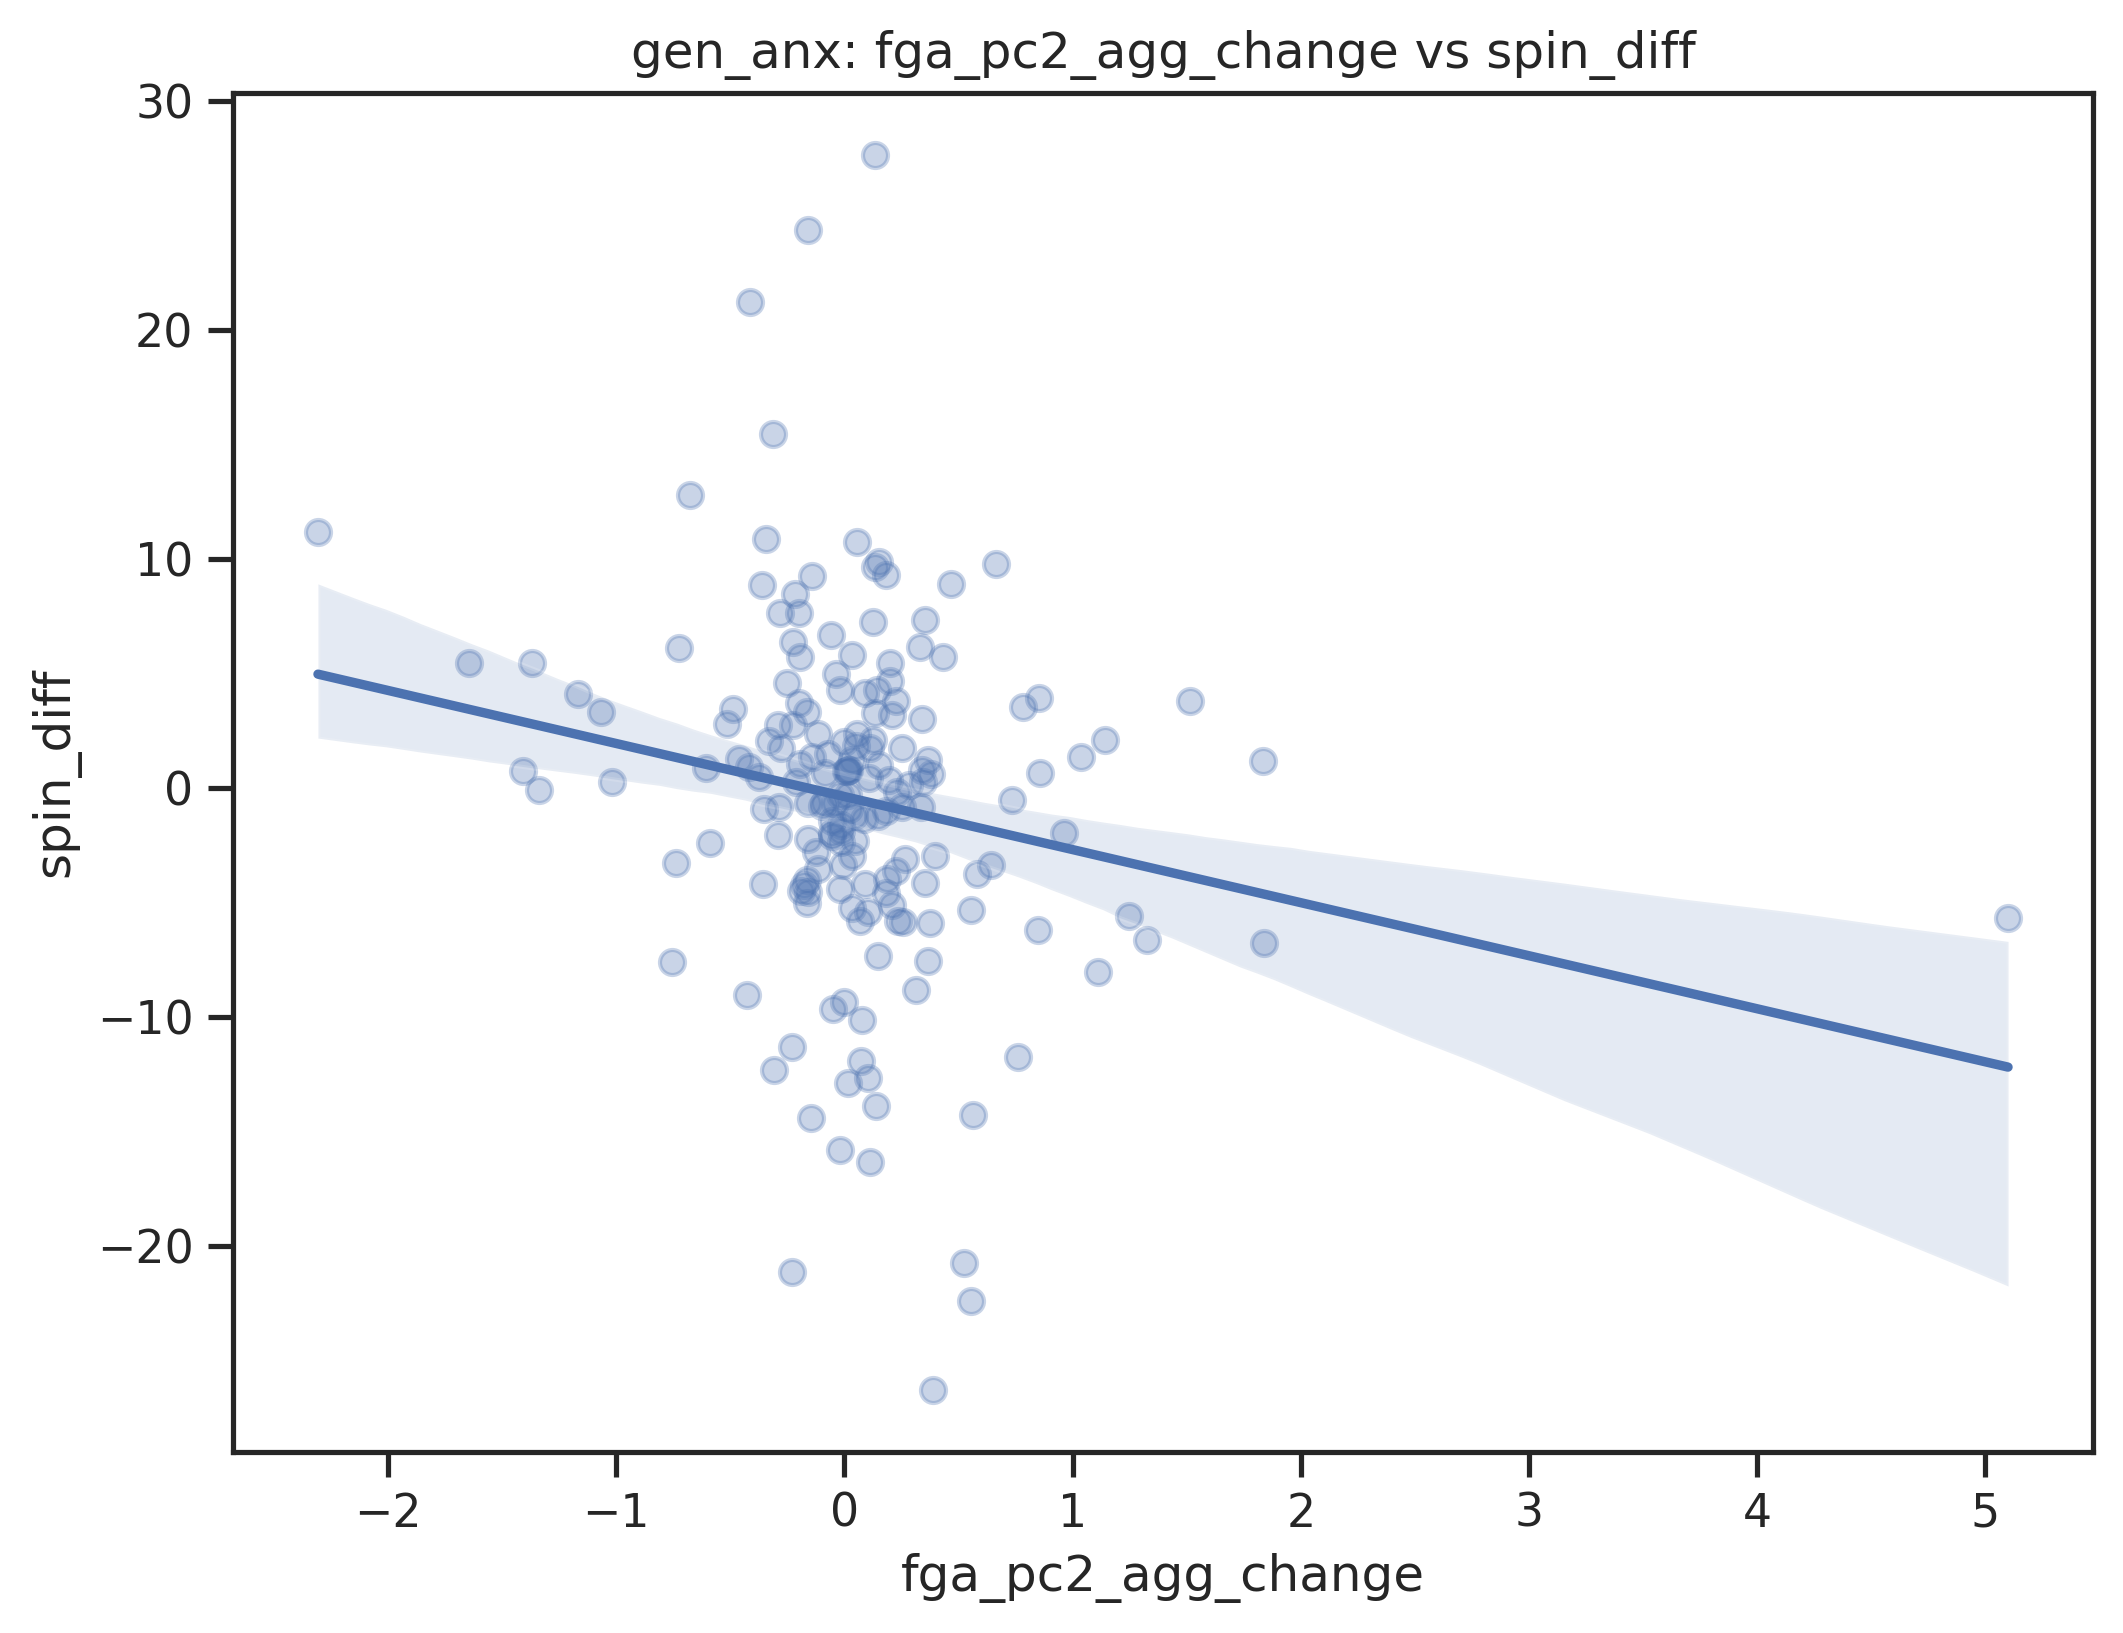

In [595]:
scatter('fga_pc2_agg_change', 'spin_diff', sel_state_df, 'gen_anx', (8,6))

#### dep_anx

In [584]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['spin_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr'))

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


Empty DataFrame
Columns: [X, Y, method, tail, n, r, CI95%, r2, adj_r2, z, p-unc, p-corr, p-adjust, power]
Index: []

## GAD

### Simple Correlation

#### Full population

In [585]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['gad_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X         Y    n      r    p-corr p-adjust
13          cal_agg_change  gad_diff  758  0.114  0.029436   fdr_bh
0   active_apps_agg_change  gad_diff  768  0.100  0.038535   fdr_bh
4       fga_pc2_agg_change  gad_diff  768  0.098  0.038535   fdr_bh

#### no_symp

In [586]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### soc_anx

In [587]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X         Y    n      r    p-corr p-adjust
0  active_apps_agg_change  gad_diff  202  0.199  0.076667   fdr_bh

#### gen_anx

In [588]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X         Y    n      r    p-corr p-adjust
0  active_apps_agg_change  gad_diff  176  0.240  0.011131   fdr_bh
4      fga_pc2_agg_change  gad_diff  176  0.248  0.011131   fdr_bh
5      fga_pc3_agg_change  gad_diff  176  0.197  0.049059   fdr_bh

#### dep_anx

In [589]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['gad_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X         Y    n      r    p-corr p-adjust
2  social_apps_agg_change  gad_diff  138 -0.259  0.036956   fdr_bh
3      fga_pc1_agg_change  gad_diff  138 -0.218  0.087351   fdr_bh

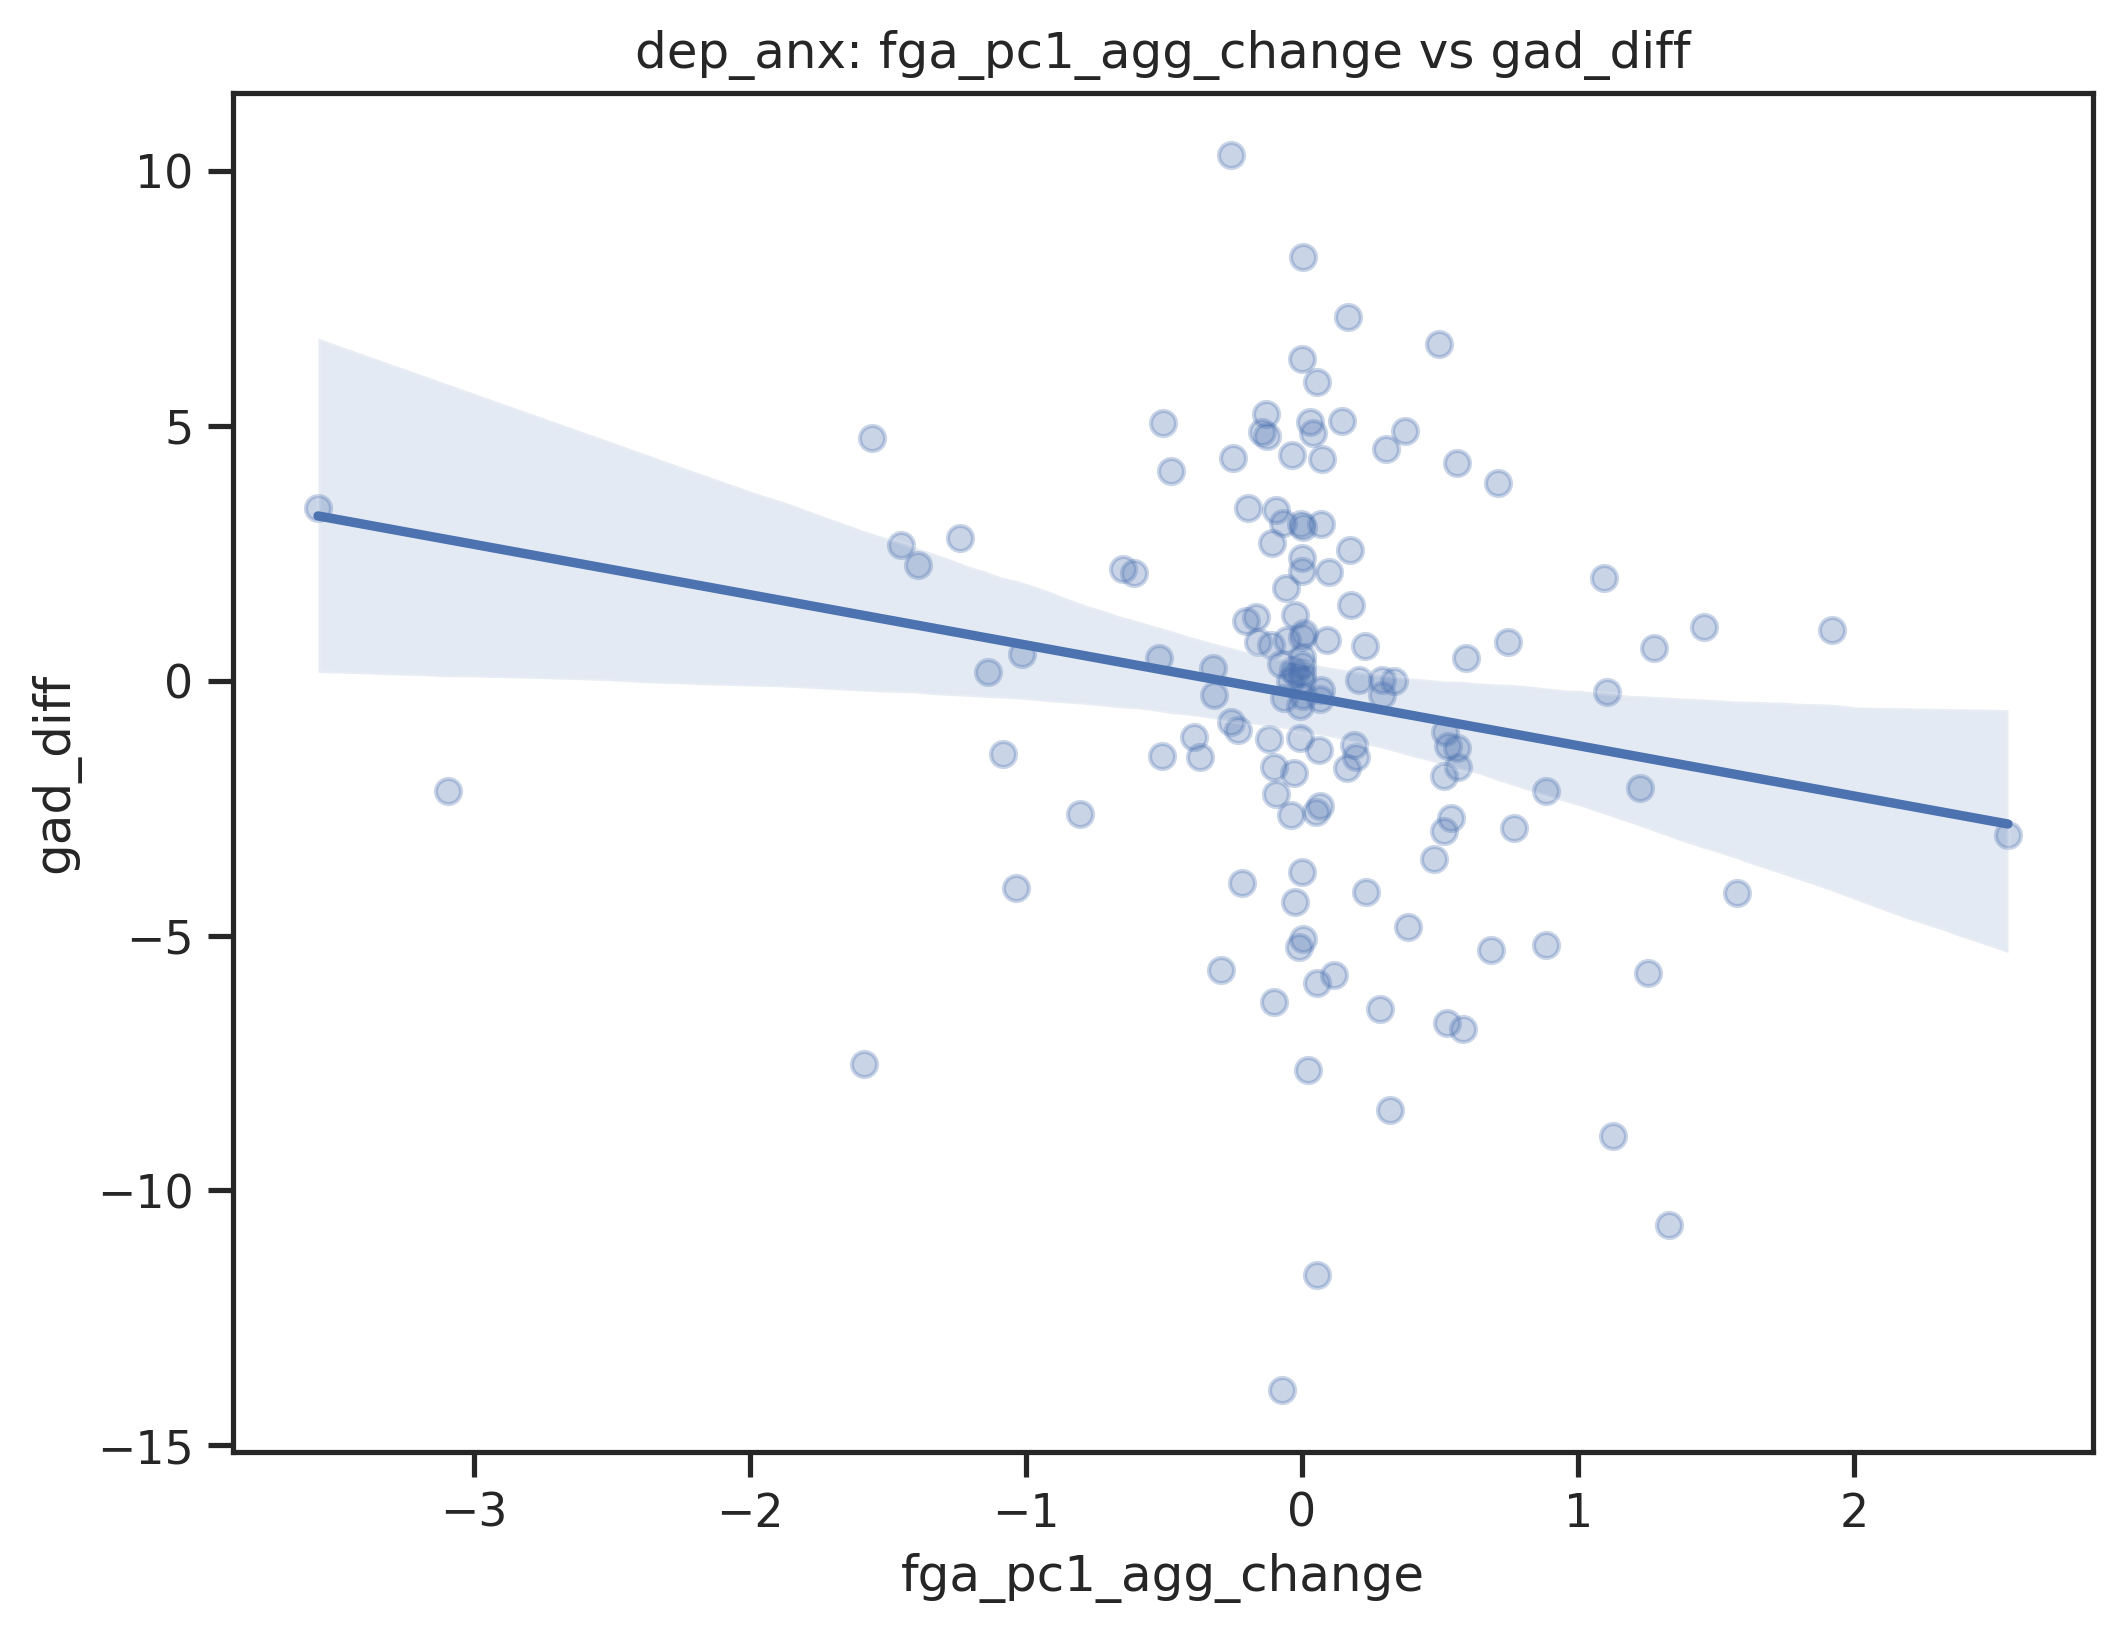

In [598]:
scatter('fga_pc1_agg_change', 'gad_diff', agg_df, 'dep_anx', (8,6))

# PHQ: 14 day lookback

In [513]:
shift_df = pd.read_pickle("ls_data/phq_cluster_shift.df")

In [514]:
# load fus and circ data
fus_daily = pd.read_pickle("wave1_features/fus_phq_start_14_-1.df")
circ_dict = pickle.load(open("wave1_features/circ_phq_start_14_-1.dict", "rb"))

In [515]:
# correction for Series values in list, though it doesn't seem to have affected anything??
new_dict = {}
for col, vals in circ_dict.items():
    new_vals = []
    for v in vals:
        if isinstance(v, pd.Series):
            new_vals.append(v[0])
        else:
            new_vals.append(v)
    new_dict[col] = new_vals
circ_dict = new_dict

In [516]:
shift_df['date'] = shift_df['phq_start'].dt.normalize()

In [517]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
cal_dict = build_col_dict(cal_cols, cal_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
#fus_dict = build_col_dict(fus_cols, fus_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
fga_dict = build_col_dict(fga_cols, fga_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
sloc_dict = build_col_dict(sloc_cols, sloc_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)

CPU times: user 53.9 s, sys: 11.5 ms, total: 54 s
Wall time: 54 s


In [518]:
phq_state_df = shift_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, circ_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        phq_state_df[col] = vals
phq_state_df = phq_state_df.merge(fus_daily, how='left', on=['pid', 'study_wk'])
phq_state_df = phq_state_df.replace([np.inf, -np.inf], np.nan)

phq_state_df.head()

cluster              diff  mean_phq phq01_sc phq02_sc phq03_sc phq04_sc  \
0      3.0               NaT  9.714286        1        2        1        2   
1      3.0  20 days 19:32:10  9.714286        1        2        2        2   
2      3.0  21 days 00:04:12  9.714286        1        1        2        1   
3      3.0  21 days 02:46:57  9.714286        1        1        3        2   
4      3.0  20 days 21:08:34  9.714286        1        1        3        3   

  phq05_sc phq06_sc phq07_sc  ... entropy_wkend loc_var_total loc_var_wkday  \
0        0        1        0  ...      0.475579     -3.270545     -2.933953   
1        0        1        1  ...      0.316461     -3.992103     -3.525627   
2        0        1        1  ...      0.614245     -4.514528     -4.420466   
3        0        1        1  ...      0.313577     -4.964505     -4.796124   
4        1        2        2  ...      0.602098     -3.686849     -4.510184   

  loc_var_wkend  norm_entropy_total norm_entropy_wkday norm_entropy_wkend  \
0     -5.241677            0.276144           0.301766           0.265426   
1     -6.091229            0.210504           0.220220           0.196628   
2     -4.855950            0.238564           0.201583           0.315659   
3     -5.919636            0.245505           0.267644           0.194837   
4     -3.103347            0.278194           0.269323           0.336037   

   velocity_total  velocity_wkday velocity_wkend  
0        7.228884        8.305369       4.826638  
1        5.144077        6.141039       2.649001  
2        5.056099        4.347594       6.839301  
3        3.989529        4.033579       3.825982  
4        4.790311        4.550216       5.398051  

[5 rows x 236 columns]

## Feature Aggregation

### fga

In [519]:
phq_agg_df = phq_state_df.copy()
phq_agg_df[fga_cols] = (phq_agg_df[fga_cols] - phq_agg_df[fga_cols].mean()) / phq_agg_df[fga_cols].std()
phq_agg_df['active_apps_agg'] = phq_agg_df[active_apps].mean(axis=1)
phq_agg_df['passive_apps_agg'] = phq_agg_df[passive_apps].mean(axis=1)
phq_agg_df['social_apps_agg'] = phq_agg_df[social_apps].mean(axis=1)

In [520]:
fga_pca_df = phq_state_df.copy()

# fillna with 0
#fga_pca_df[fga_cols] = fga_pca_df.groupby('pid')[fga_cols].transform(lambda x: x.fillna(0))

fga_pca_df[fga_cols] = StandardScaler().fit_transform(fga_pca_df[fga_cols])

fga_pca_df = fga_pca_df.dropna(how='any', subset=fga_cols)

n_comps = 5
n_cols = len(fga_cols)
fga_transformer = PCA(n_components=n_comps, random_state=0)
fga_transformed = fga_transformer.fit_transform(fga_pca_df[fga_cols])

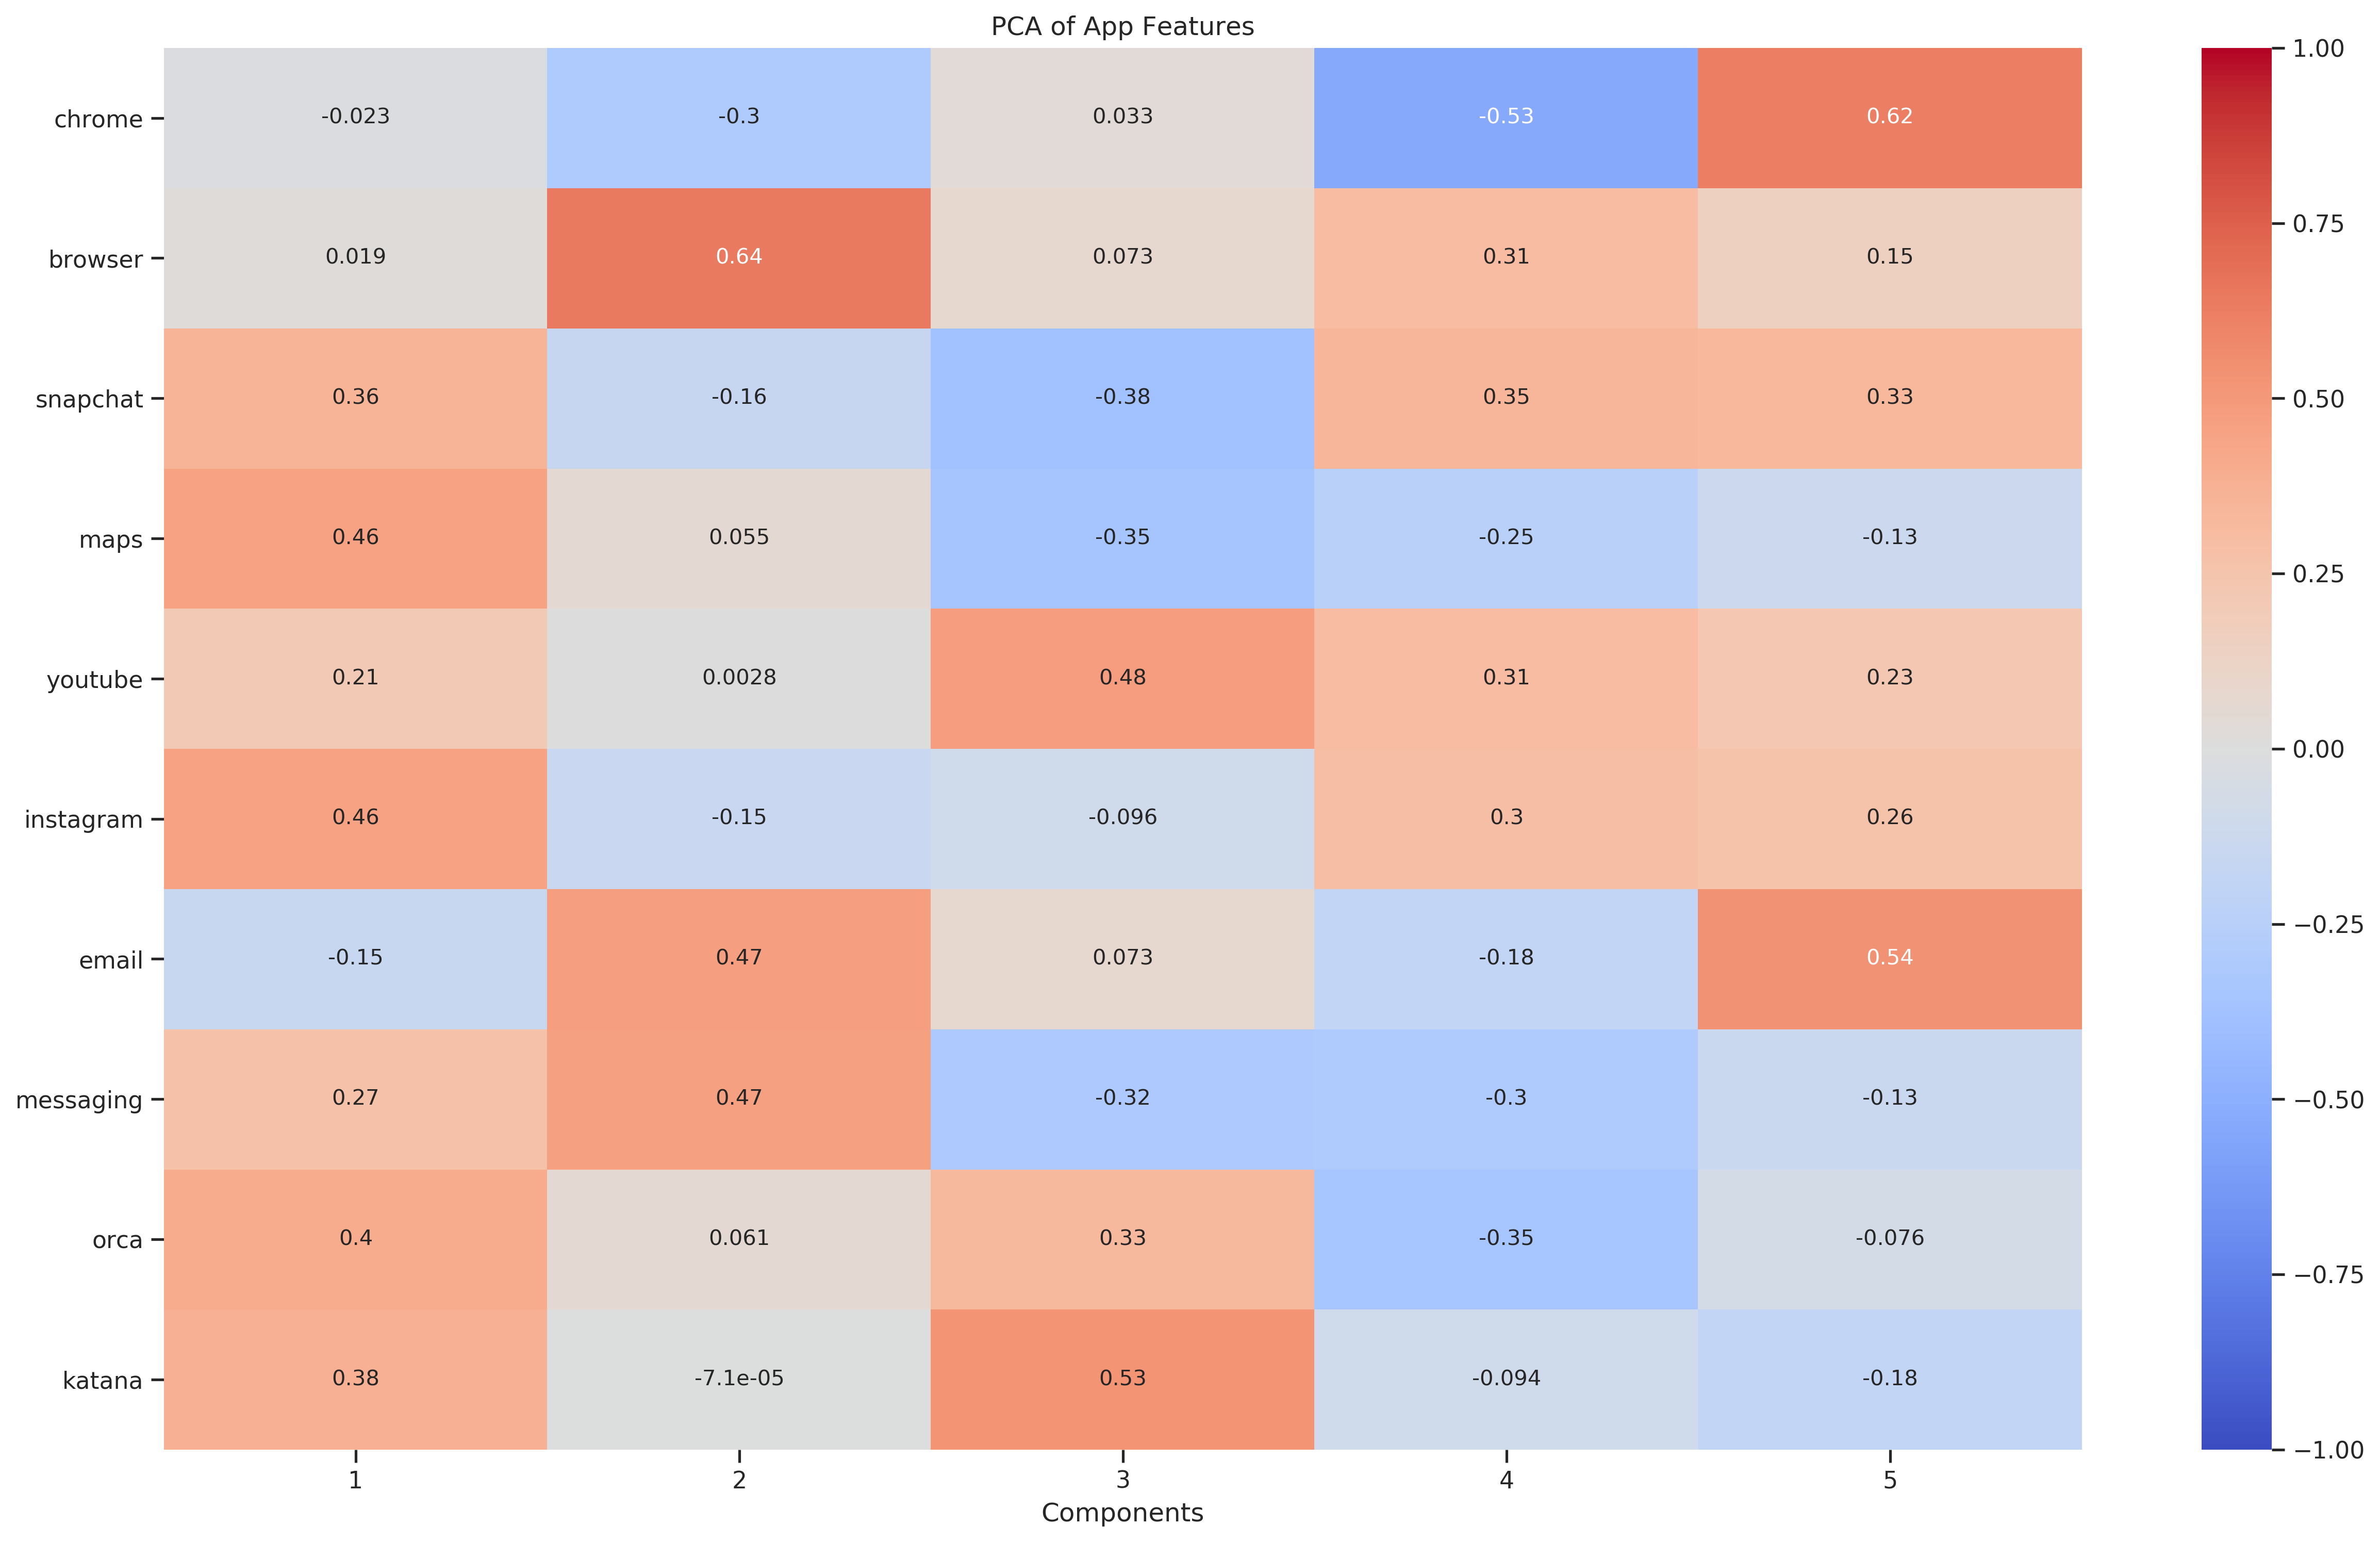

In [521]:
plot_PCA_components(fga_transformer, n_comps, fga_cols, "PCA of App Features")

In [522]:
var_df = pd.Series(fga_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df

var_explained
0       0.148740
1       0.127185
2       0.122590
3       0.112328
4       0.098905

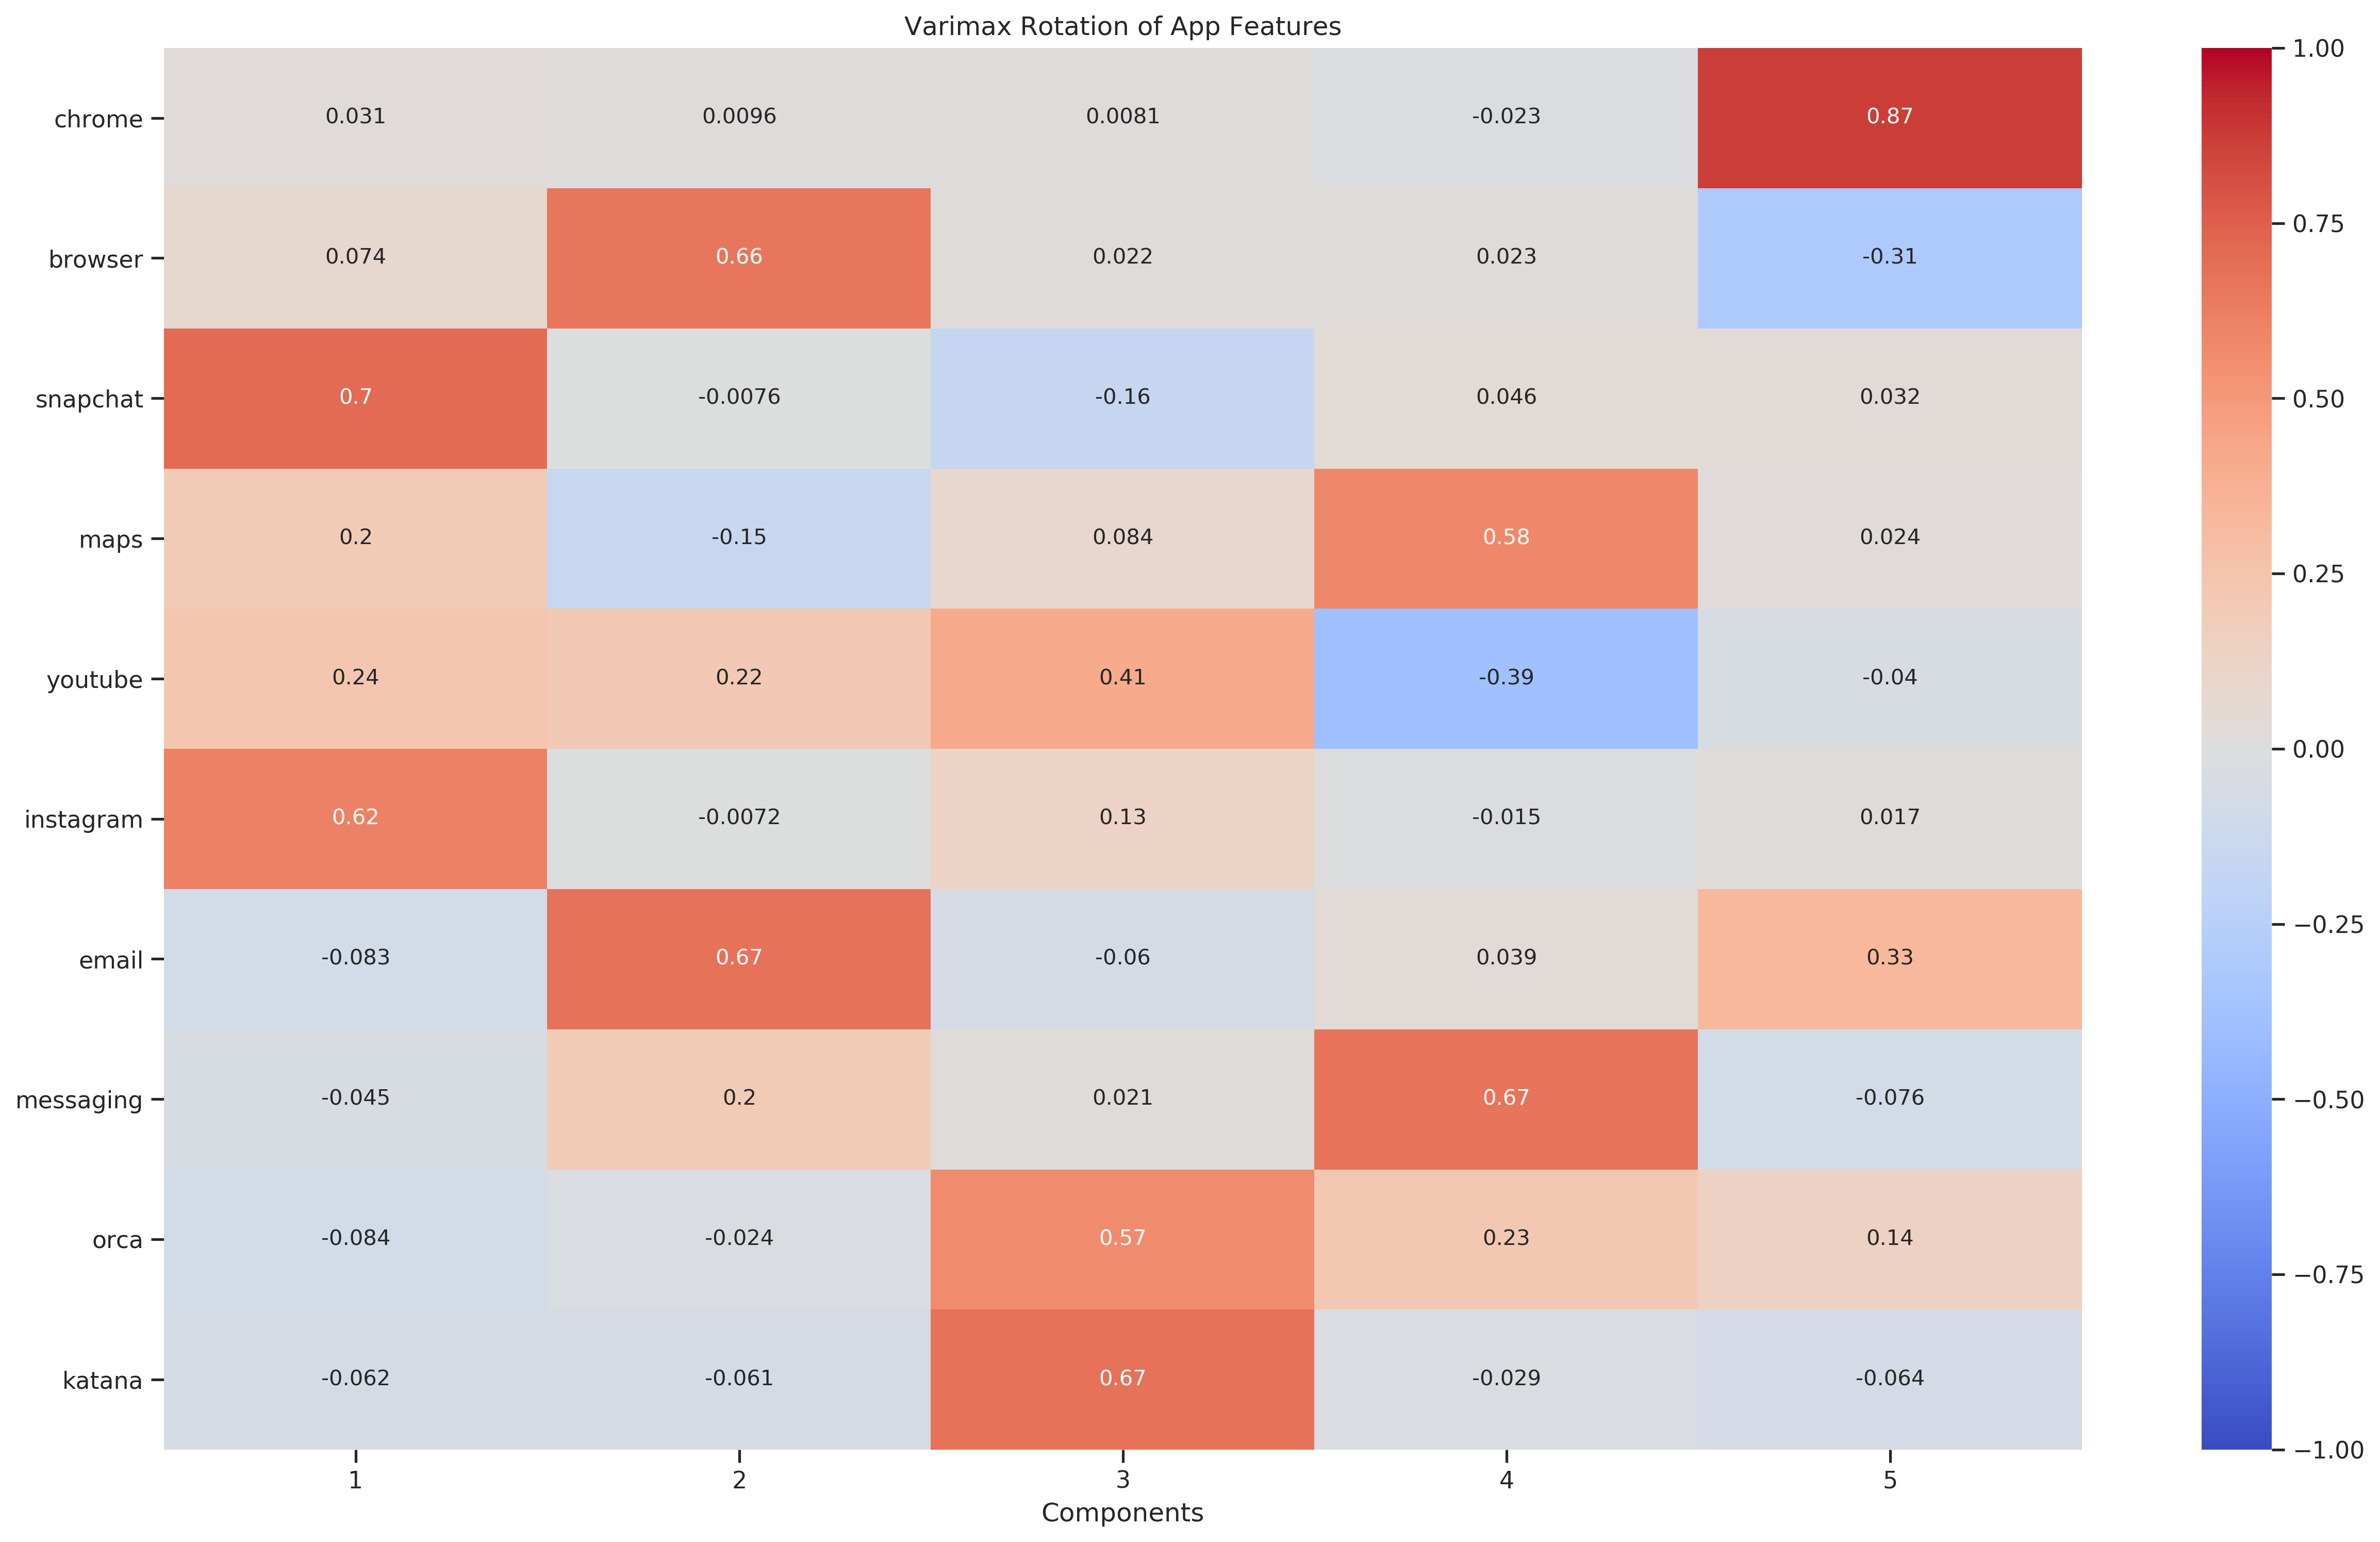

In [523]:
plot_varimax(fga_transformer, n_comps, fga_cols, "Varimax Rotation of App Features")

In [524]:
id_cols = ['pid', 'study_wk']
pc_cols = ['fga_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
fga_pc = pd.DataFrame(fga_transformed,
                      columns=pc_cols)
fga_pca_df = fga_pca_df.reset_index(drop=True)
fga_pca_df = pd.concat([fga_pca_df, fga_pc], axis=1)
phq_agg_df = phq_agg_df.merge(fga_pca_df[id_cols + pc_cols], how='left', on=id_cols)

### sloc

In [525]:
sloc_pca_df = phq_state_df.copy()

sloc_dur_cols = sloc_daily.columns[sloc_daily.columns.str.endswith('dur')]
#sloc_dur_cols = ['work_dur', 'other_dur', 'home_dur', 'food_dur', 'exercise_dur', 'anothers_home_dur']

# fillna with participant mean
#sloc_pca_df[sloc_dur_cols] = sloc_pca_df.groupby('pid')[sloc_dur_cols].transform(lambda x: x.fillna(x.mean()))

sloc_pca_df[sloc_dur_cols] = StandardScaler().fit_transform(sloc_pca_df[sloc_dur_cols])

#sloc_pca_df[sloc_dur_cols] = (sloc_pca_df[sloc_dur_cols] - sloc_pca_df[sloc_dur_cols].mean()) / sloc_pca_df[sloc_dur_cols].std()
sloc_pca_df = sloc_pca_df.dropna(how='any', subset=sloc_dur_cols)

n_comps = 4

n_cols = len(sloc_dur_cols)
sloc_transformer = PCA(n_components=n_comps, random_state=0)
sloc_transformed = sloc_transformer.fit_transform(sloc_pca_df[sloc_dur_cols])

In [526]:
pc_cols = ['sloc_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
sloc_pc = pd.DataFrame(sloc_transformed,
                      columns=pc_cols)
sloc_pca_df = sloc_pca_df.reset_index(drop=True)
sloc_pca_df = pd.concat([sloc_pca_df, sloc_pc], axis=1)
phq_agg_df = phq_agg_df.merge(sloc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

### comm

In [527]:
comm_pca_df = phq_state_df.copy()
comm_cols = cal_cols + sms_cols

# fillna with participant mean
#comm_pca_df[comm_cols] = comm_pca_df.groupby('pid')[comm_cols].transform(lambda x: x.fillna(x.mean()))

comm_pca_df[comm_cols] = StandardScaler().fit_transform(comm_pca_df[comm_cols])


#comm_pca_df[comm_cols] = (comm_pca_df[comm_cols] - comm_pca_df[comm_cols].mean()) / comm_pca_df[comm_cols].std()
comm_pca_df = comm_pca_df.dropna(how='any', subset=comm_cols)

#comm_pca_df = comm_pca_df[~comm_pca_df['katana'].isna()]

n_comps = 2

n_cols = len(comm_cols)
comm_transformer = PCA(n_components=n_comps, random_state=0)
comm_transformed = comm_transformer.fit_transform(comm_pca_df[comm_cols])

In [528]:
phq_agg_df[sms_cols] = (phq_agg_df[sms_cols] - phq_agg_df[sms_cols].mean()) / phq_agg_df[sms_cols].std()
phq_agg_df[cal_cols] = (phq_agg_df[cal_cols] - phq_agg_df[cal_cols].mean()) / phq_agg_df[cal_cols].std()
phq_agg_df['sms_agg'] = phq_agg_df[sms_cols].mean(axis=1)
phq_agg_df['cal_agg'] = phq_agg_df[cal_cols].mean(axis=1)

### fus

In [529]:
loc_pca_df = phq_state_df.copy()
loc_cols = circ_cols + fus_cols

# fillna with participant mean
#loc_pca_df[loc_cols] = loc_pca_df.groupby('pid')[loc_cols].transform(lambda x: x.fillna(x.mean()))

loc_pca_df[loc_cols] = StandardScaler().fit_transform(loc_pca_df[loc_cols])


#loc_pca_df[loc_cols] = (loc_pca_df[loc_cols] - loc_pca_df[loc_cols].mean()) / loc_pca_df[loc_cols].std()

loc_pca_df = loc_pca_df.dropna(how='any', subset=loc_cols)
#loc_pca_df = loc_pca_df[~loc_pca_df['katana'].isna()]

n_comps = 3

n_cols = len(loc_cols)
loc_transformer = PCA(n_components=n_comps, random_state=0)
loc_transformed = loc_transformer.fit_transform(loc_pca_df[loc_cols])

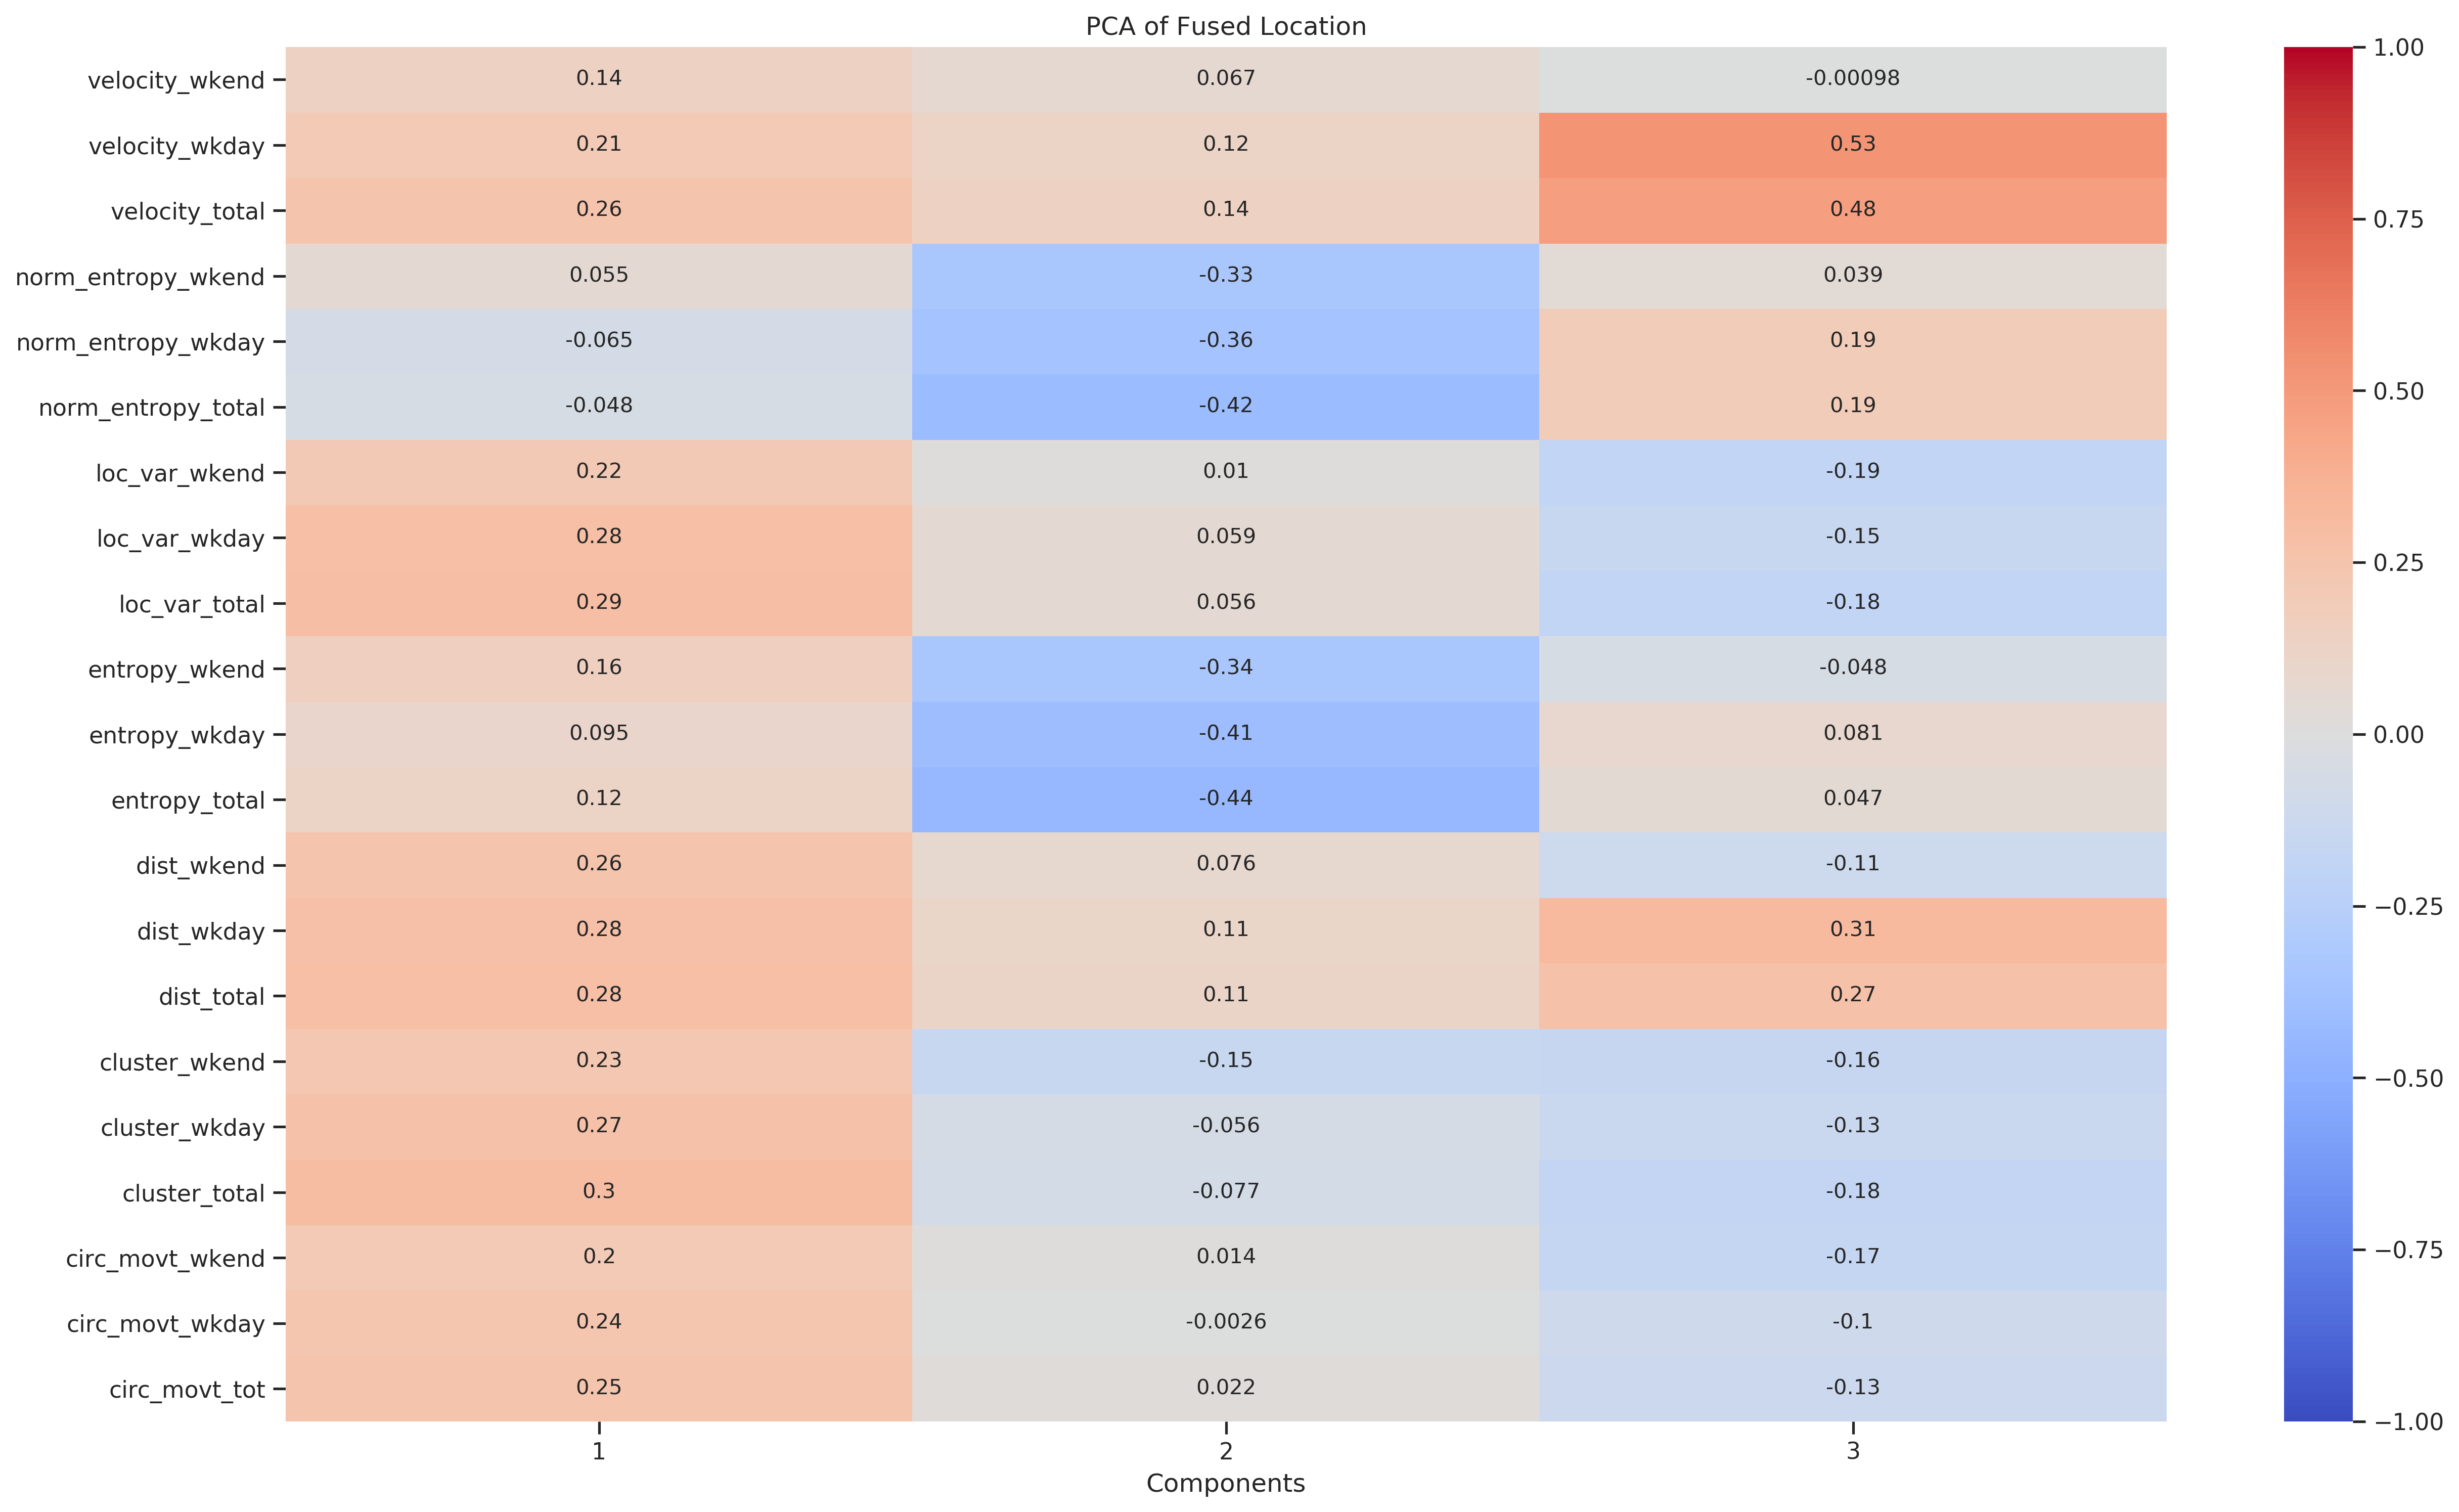

In [530]:
plot_PCA_components(loc_transformer, n_comps, loc_cols, "PCA of Fused Location")

In [531]:
get_var_explained(loc_transformer)

var_explained
0       0.365925
1       0.172756
2       0.140348

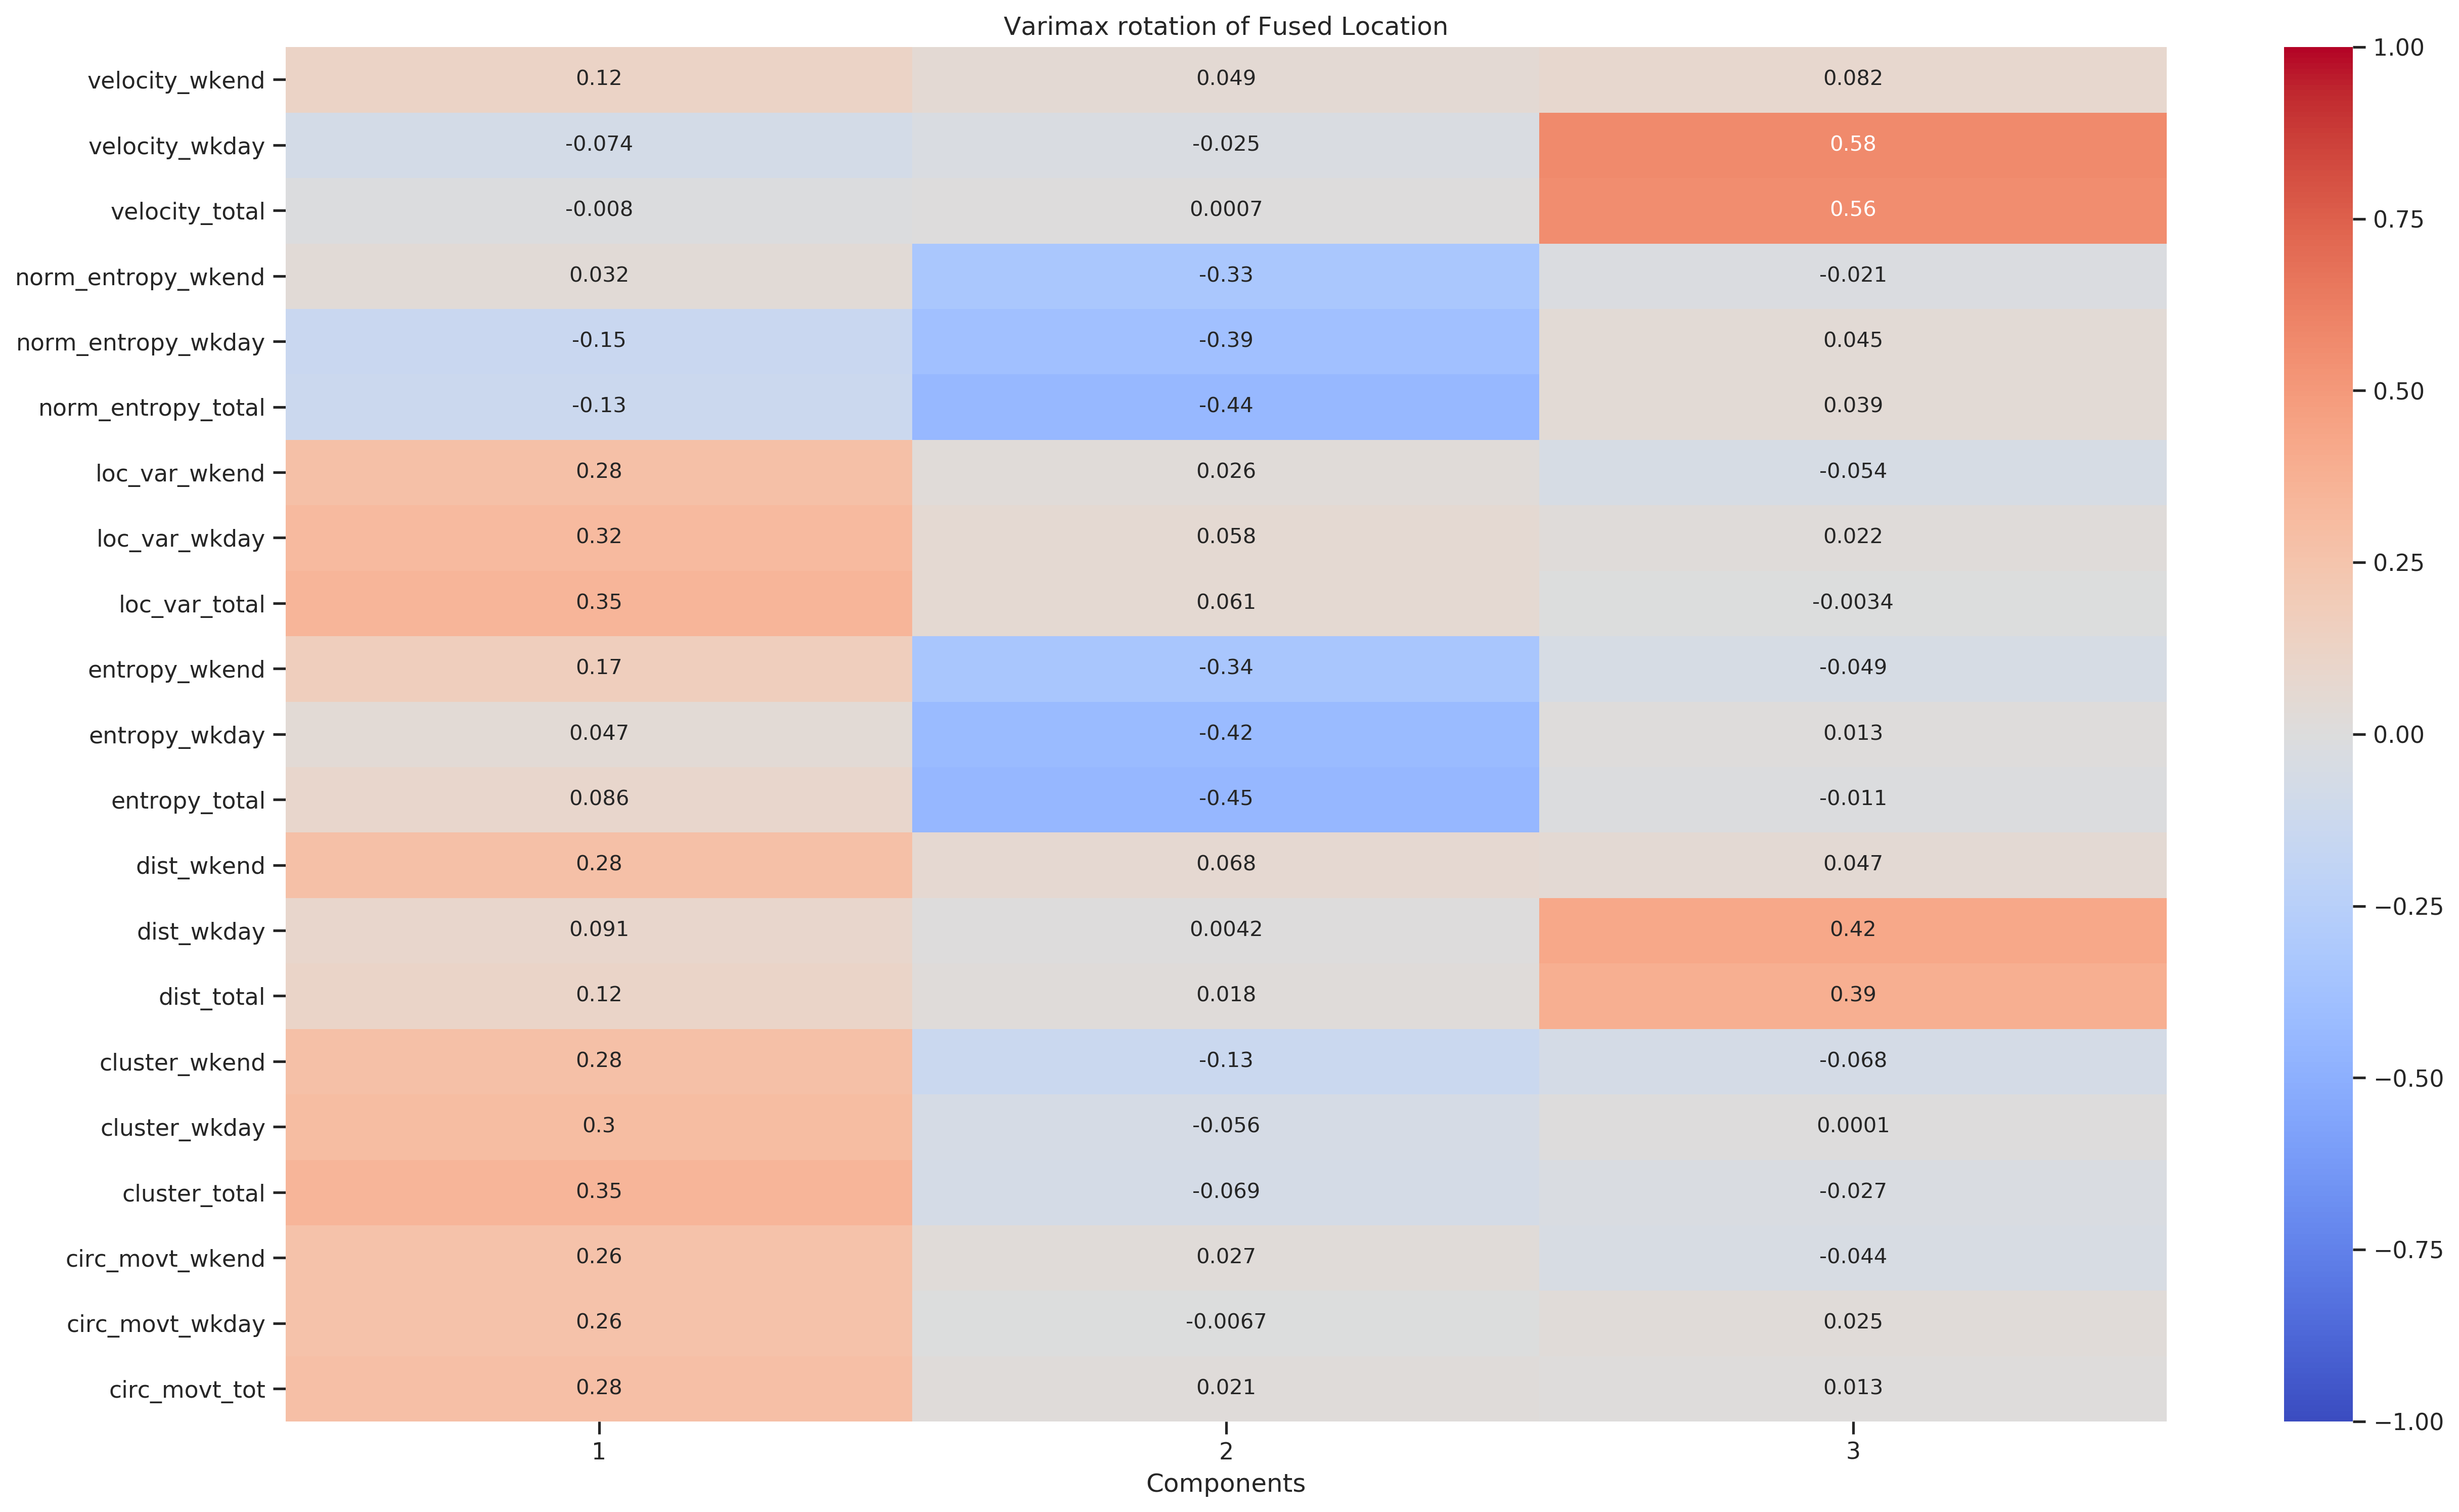

In [532]:
plot_varimax(loc_transformer, n_comps, loc_cols, "Varimax rotation of Fused Location")

In [533]:
pc_cols = ['loc_pc{}_agg'.format(i) for i in range(1, n_comps+1)]
loc_pc = pd.DataFrame(loc_transformed,
                      columns=pc_cols)
loc_pca_df = loc_pca_df.reset_index(drop=True)
loc_pca_df = pd.concat([loc_pca_df, loc_pc], axis=1)
phq_agg_df = phq_agg_df.merge(loc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

In [534]:
agg_cols = phq_agg_df.columns[phq_agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [535]:
phq_agg_df[agg_cols_shift] = phq_agg_df.groupby('pid')[agg_cols].shift(1)

In [536]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    phq_agg_df[change] = phq_agg_df[cur] - phq_agg_df[prev]

## Correlations

### Simple Correlation

#### Entire population

In [537]:
phq_agg_df['phq_diff'].describe()

count    1025.000000
mean        0.008618
std         2.880980
min       -15.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: phq_diff, dtype: float64

In [538]:
print("Pearson")
pair_corr_df = pg.pairwise_corr(phq_agg_df, columns=[agg_cols_change, ['phq_diff']], padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])
print("Spearman")
pair_corr_df = pg.pairwise_corr(phq_agg_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


X         Y    n      r    p-corr p-adjust
14  loc_pc1_agg_change  phq_diff  576 -0.171  0.000613   fdr_bh

Spearman


X         Y    n      r    p-corr p-adjust
14  loc_pc1_agg_change  phq_diff  576 -0.162  0.001669   fdr_bh

#### no_symp

In [539]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'no_symp']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


X         Y    n      r    p-corr p-adjust
15   loc_pc2_agg_change  phq_diff  193  0.270  0.002416   fdr_bh
9   sloc_pc2_agg_change  phq_diff  255 -0.177  0.039033   fdr_bh

Spearman


X         Y    n     r    p-corr p-adjust
15  loc_pc2_agg_change  phq_diff  193  0.24  0.013034   fdr_bh

#### soc_anx

In [540]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'soc_anx']

print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### gen_anx

In [541]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'gen_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', method='pearson', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

Pearson


Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

Spearman


X         Y    n      r    p-corr p-adjust
14  loc_pc1_agg_change  phq_diff  116 -0.255  0.048652   fdr_bh
16  loc_pc3_agg_change  phq_diff  116  0.268  0.048652   fdr_bh

#### dep_anx

In [542]:
sel_state_df = phq_agg_df[phq_agg_df['baseline_cluster'] == 'dep_anx']
print("Pearson")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']])

print("Spearman")
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', padjust="fdr_bh")
display(pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr'))

Pearson


X         Y    n      r    p-corr p-adjust
14      loc_pc1_agg_change  phq_diff  115 -0.437  0.000018   fdr_bh
0   active_apps_agg_change  phq_diff  149 -0.335  0.000254   fdr_bh
5       fga_pc3_agg_change  phq_diff  149  0.238  0.019319   fdr_bh

Spearman


X         Y    method       tail    n      r  \
14  loc_pc1_agg_change  phq_diff  spearman  two-sided  115 -0.286   

             CI95%     r2  adj_r2      z     p-unc    p-corr p-adjust  power  
14  [-0.45, -0.11]  0.082   0.065 -0.294  0.001966  0.033426   fdr_bh  0.877

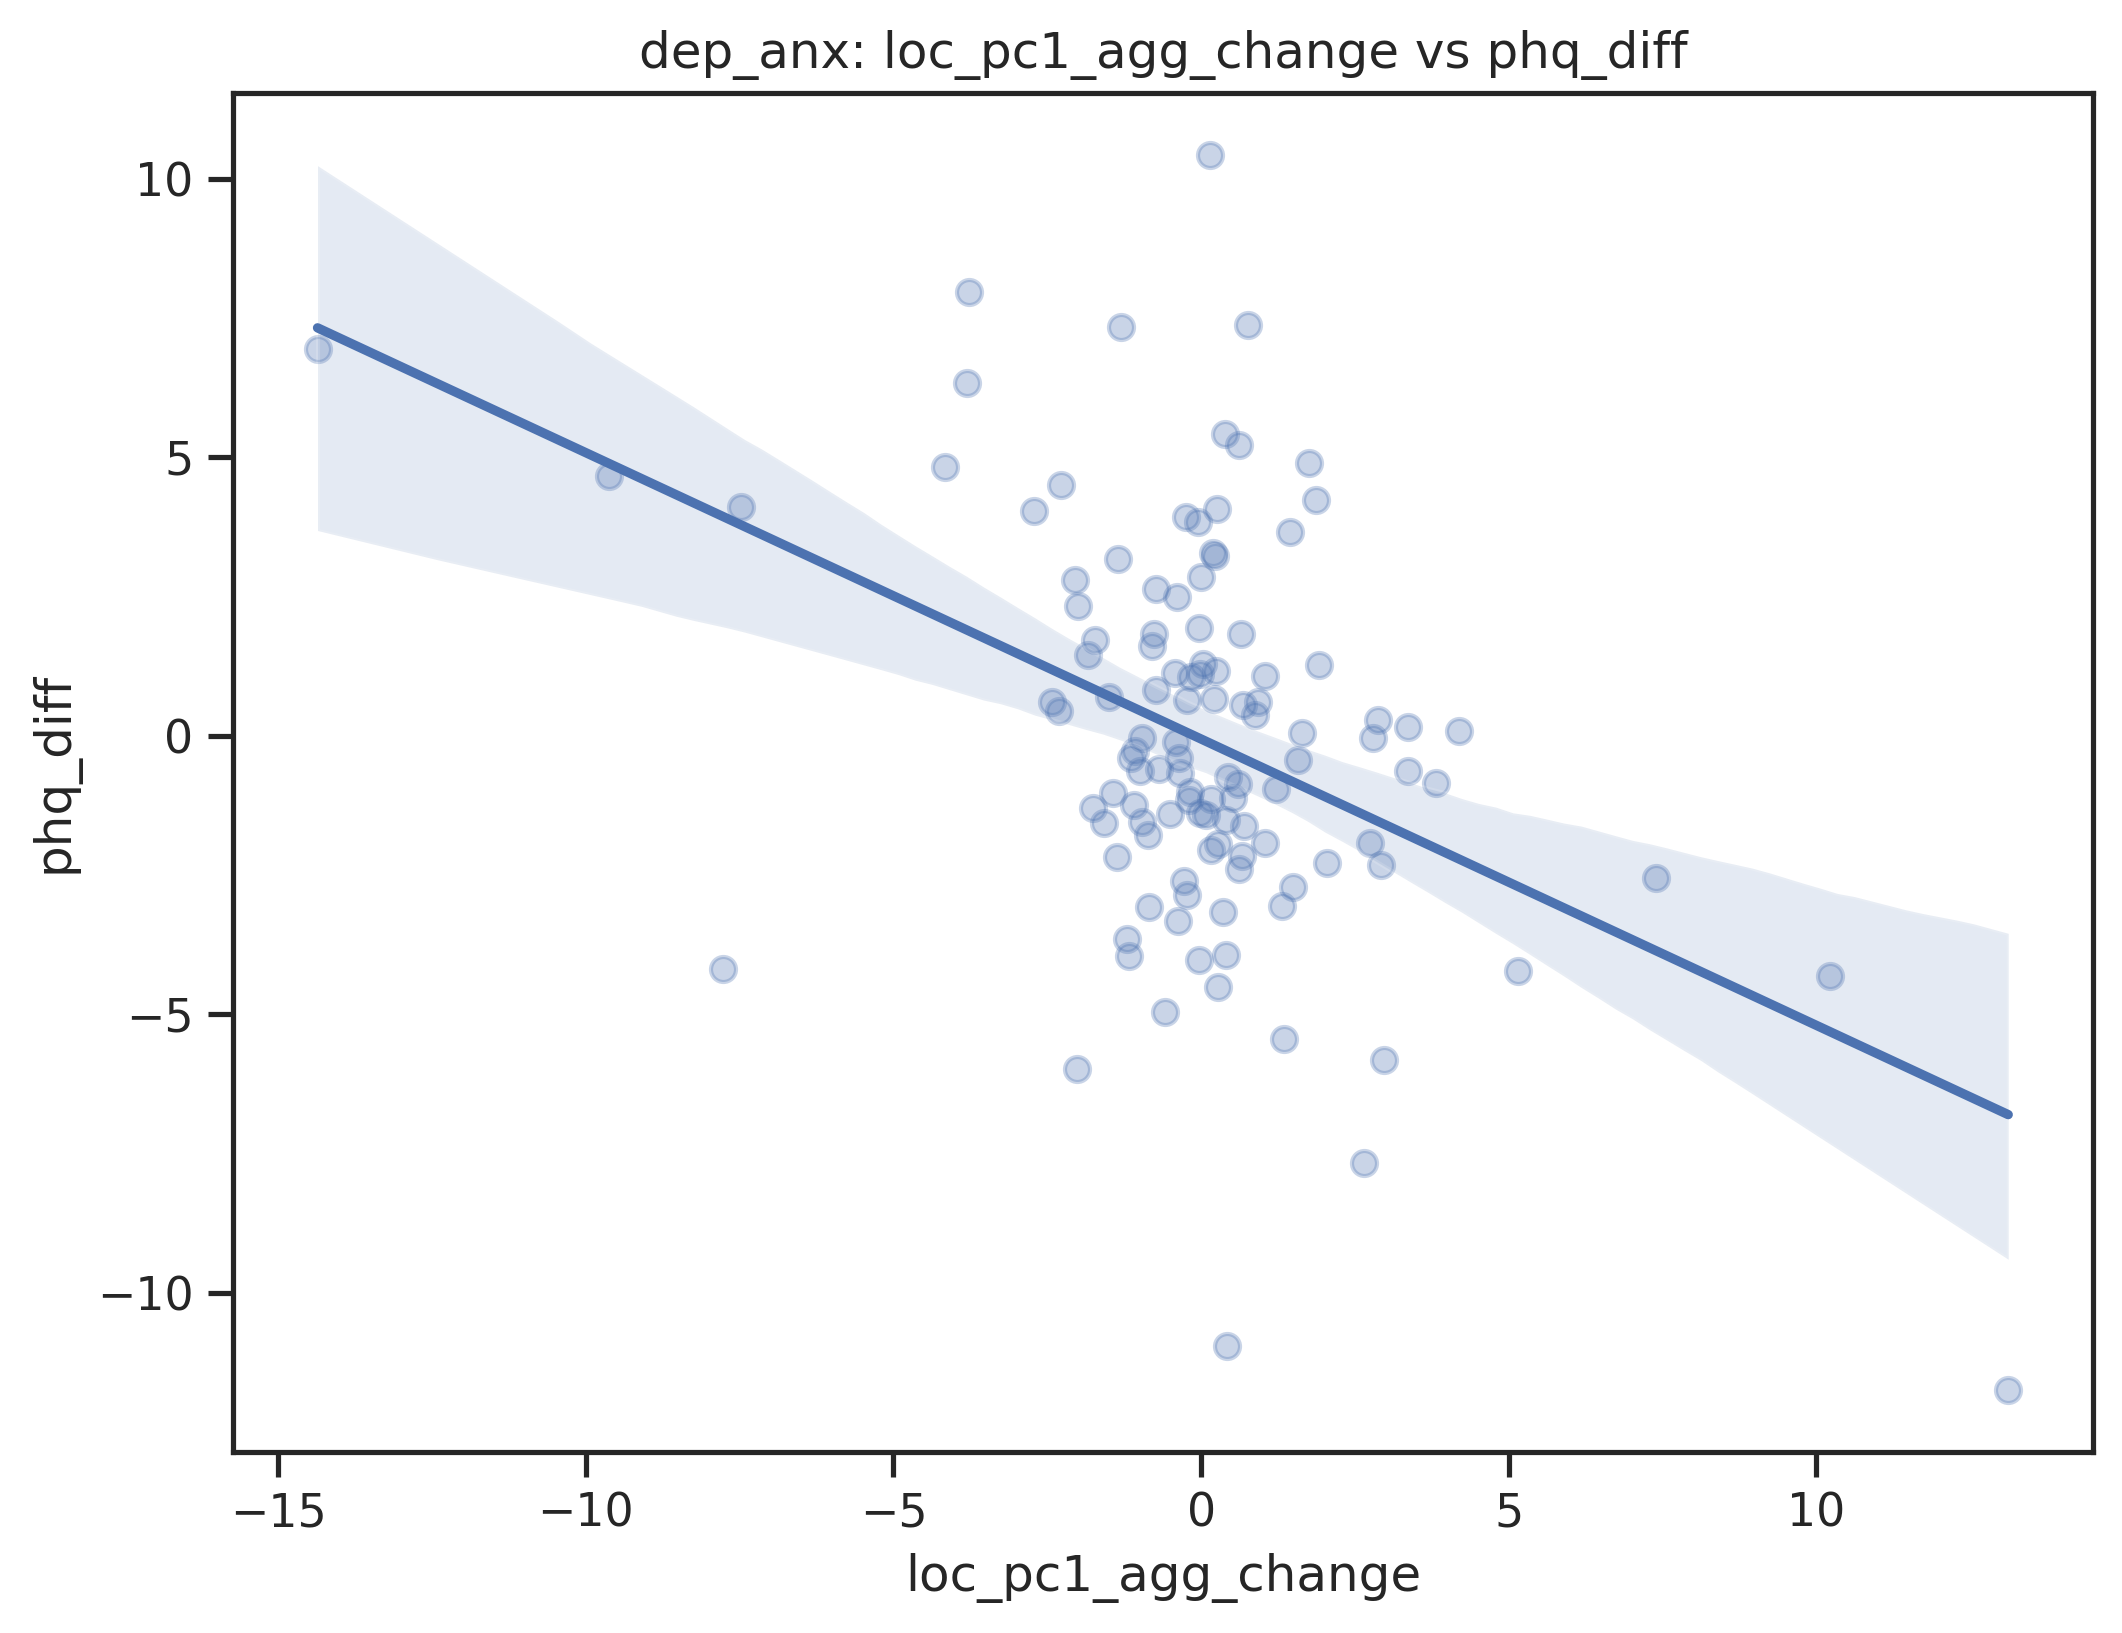

In [599]:
scatter('loc_pc1_agg_change', 'phq_diff', phq_agg_df, 'dep_anx', (8,6))

In [543]:
phq_agg_df[agg_cols_change].isna().sum()

active_apps_agg_change     416
passive_apps_agg_change    416
social_apps_agg_change     416
fga_pc1_agg_change         416
fga_pc2_agg_change         416
fga_pc3_agg_change         416
fga_pc4_agg_change         416
fga_pc5_agg_change         416
sloc_pc1_agg_change        416
sloc_pc2_agg_change        416
sloc_pc3_agg_change        416
sloc_pc4_agg_change        416
sms_agg_change             432
cal_agg_change             423
loc_pc1_agg_change         654
loc_pc2_agg_change         654
loc_pc3_agg_change         654
dtype: int64